# Unemployment Models


In [1]:
library(UsingR)
library(quantmod)
library(ggplot2)
library(grid)
library(gridExtra)
library(knitr)
library(kableExtra)
library(tools)
library(zoo)
library(signal)
library(stringr)
library(corrplot)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest)
library(Quandl)
library(nnet)
library(readr)
#library(devtools)
#install_github("andrewuhl/RollingWindow")
library(RollingWindow)
#install.packages("EIAdata")
library(EIAdata)
library(gtable)
library(data.table)
library(readxl)
library(plotly)

Loading required package: MASS

Loading required package: HistData

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units



Attaching package: 'UsingR'


The following object is masked from 'package:survival':

    cancer


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'quantmod'


The following object is masked from 'package:Hmisc':

    Lag



Attaching package: 'signal'


The following objects are masked from 'package:stats':

    filter, poly


corrplot 0.92 loaded


Attaching packa

Call helper functions

In [2]:
source("plotHelper.r")

Define the source of the data (local or web) and whether to update the models.

In [3]:
b.refresh.models = FALSE

Define the plotting ranges and vertical defaults

In [4]:
dt.recent = as.Date("2017-01-01")
d.GSPC.max = 3500

Load up the off-line data

In [5]:
load("C:/Users/Rainy/OneDrive//RecessionIndicator_Buffer.RData")

Uncomment this line to see all the variables that came in with the data

In [6]:
#ls.str()

This snippet is needed because some of the ticker symbols include are invalid variable names so re-cast those variable names.

In [7]:
df.symbols$string.symbol <-
  str_replace_all(df.symbols$string.symbol, "[^[:alnum:]]", "")

Do the interpolation to daily samples and tidy the data

In [8]:
source("calcInterpolate.r")

In [9]:
df.data <- calcInterpolate(df.symbols)

Warning message in merge.xts(xtsData, get(df.symbols$string.symbol[idx])):
"NAs introduced by coercion"
Warning message in merge.xts(xtsData, get(df.symbols$string.symbol[idx])):
"NAs introduced by coercion"
Warning message in merge.xts(xtsData, get(df.symbols$string.symbol[idx])):
"NAs introduced by coercion"


Truncate the data. A very few data series do go back to 1854, but most don't even go past WWII so truncate the dataframe

In [10]:
df.data <- df.data[as.Date(rownames(df.data)) > as.Date("1940-01-01"),]

Create aggreagate data series
Some analysis requires that two or more series be combined. For example, normallizing debt by GDP to get a sense of the proportion of debt to the total economy helps understand the debt cycle.

In [11]:
source("calcAggregateSeries.r")

Calculate the year-over-year, 50 day moving average, and other features in the data

In [12]:
source("calcFeatures.r")

In [13]:
lst.df <- calcFeatures(df.data, df.symbols)
df.data <- lst.df[[1]]
df.symbols <- lst.df[[2]]

[1] "USREC has zero or negative values. Log series will be zero."
[1] "GSFTX.Volume has zero or negative values. Log series will be zero."
[1] "LFMIX.Volume has zero or negative values. Log series will be zero."
[1] "LFMCX.Volume has zero or negative values. Log series will be zero."
[1] "LFMAX.Volume has zero or negative values. Log series will be zero."
[1] "LCSIX.Volume has zero or negative values. Log series will be zero."
[1] "VBIRX.Volume has zero or negative values. Log series will be zero."
[1] "VFSUX.Volume has zero or negative values. Log series will be zero."
[1] "LTUIX.Volume has zero or negative values. Log series will be zero."
[1] "PTTPX.Volume has zero or negative values. Log series will be zero."
[1] "NERYX.Volume has zero or negative values. Log series will be zero."
[1] "STIGX.Volume has zero or negative values. Log series will be zero."
[1] "HLGAX.Volume has zero or negative values. Log series will be zero."
[1] "FTRGX.Volume has zero or negative values. Log series 

These are auxilliary series that use the YoY and smoothed data.

In [14]:
source("calcFeaturesAggregate.r")

Build the recession data frame

In [15]:
source("calcRecession.r")

## Unployment models

### Labor force normalization

The BLS statistics (U3, U6, etc.) calculates labor force by summing the number of employed and unemployed people (https://www.bls.gov/cps/lfcharacteristics.htm#laborforce). The problem is that when the survey is troubled, as it was during Covid19, the labor force shows a sudden drop. For example, during the Covid19 outbreak in the spring of 2020 the labor force dropped from 164MM to 155MM. In reality, the labor force did not really drop by this much. In other words there were approximately the same number of people who wanted to work on March 1st of 2020 as there were on June 1st of 2020.

This makes the BLS measures of labor force less useful when I want to normalized by working force population. To get around this I do a linear fit of BLS labor force to general U.S. population (POPTHM) and take the slope of that fit as the average labor force participation rate. I then multiply POPTHM this value to get a constant labor force rate. This has some drawbacks, especially in that it cannot account for demographic shifts. But it should be an okay first order approximation.

In [16]:
dt.start.prediction <- as.Date(max(c(index(CLF16OV[1]), index(POPTHM[1]))))
dt.end.prediction <- as.Date("2020-01-01")

df.lf.model <-
  df.data[df.data$date >= dt.start.prediction &
            df.data$date <= dt.end.prediction,]

# Perform the fit
list.fit.clf16ovpopthm <- train(
  CLF16OV ~ POPTHM,
  data = df.lf.model,
  method = "lm",
  preProcess = c('center', 'scale')
)

In [17]:
# Add linear prediction to the dataframe
str.symbol <- "CLF16OV.lm.POPTHM"
df.data[str.symbol] <-
  predict(list.fit.clf16ovpopthm, newdata = df.data)

# Add the linear model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "Linear Model Prediction\nCLF16OV given POPTHM",
      string.label.y = getPlotYLabel(df.symbols, "POPTHM")[1],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

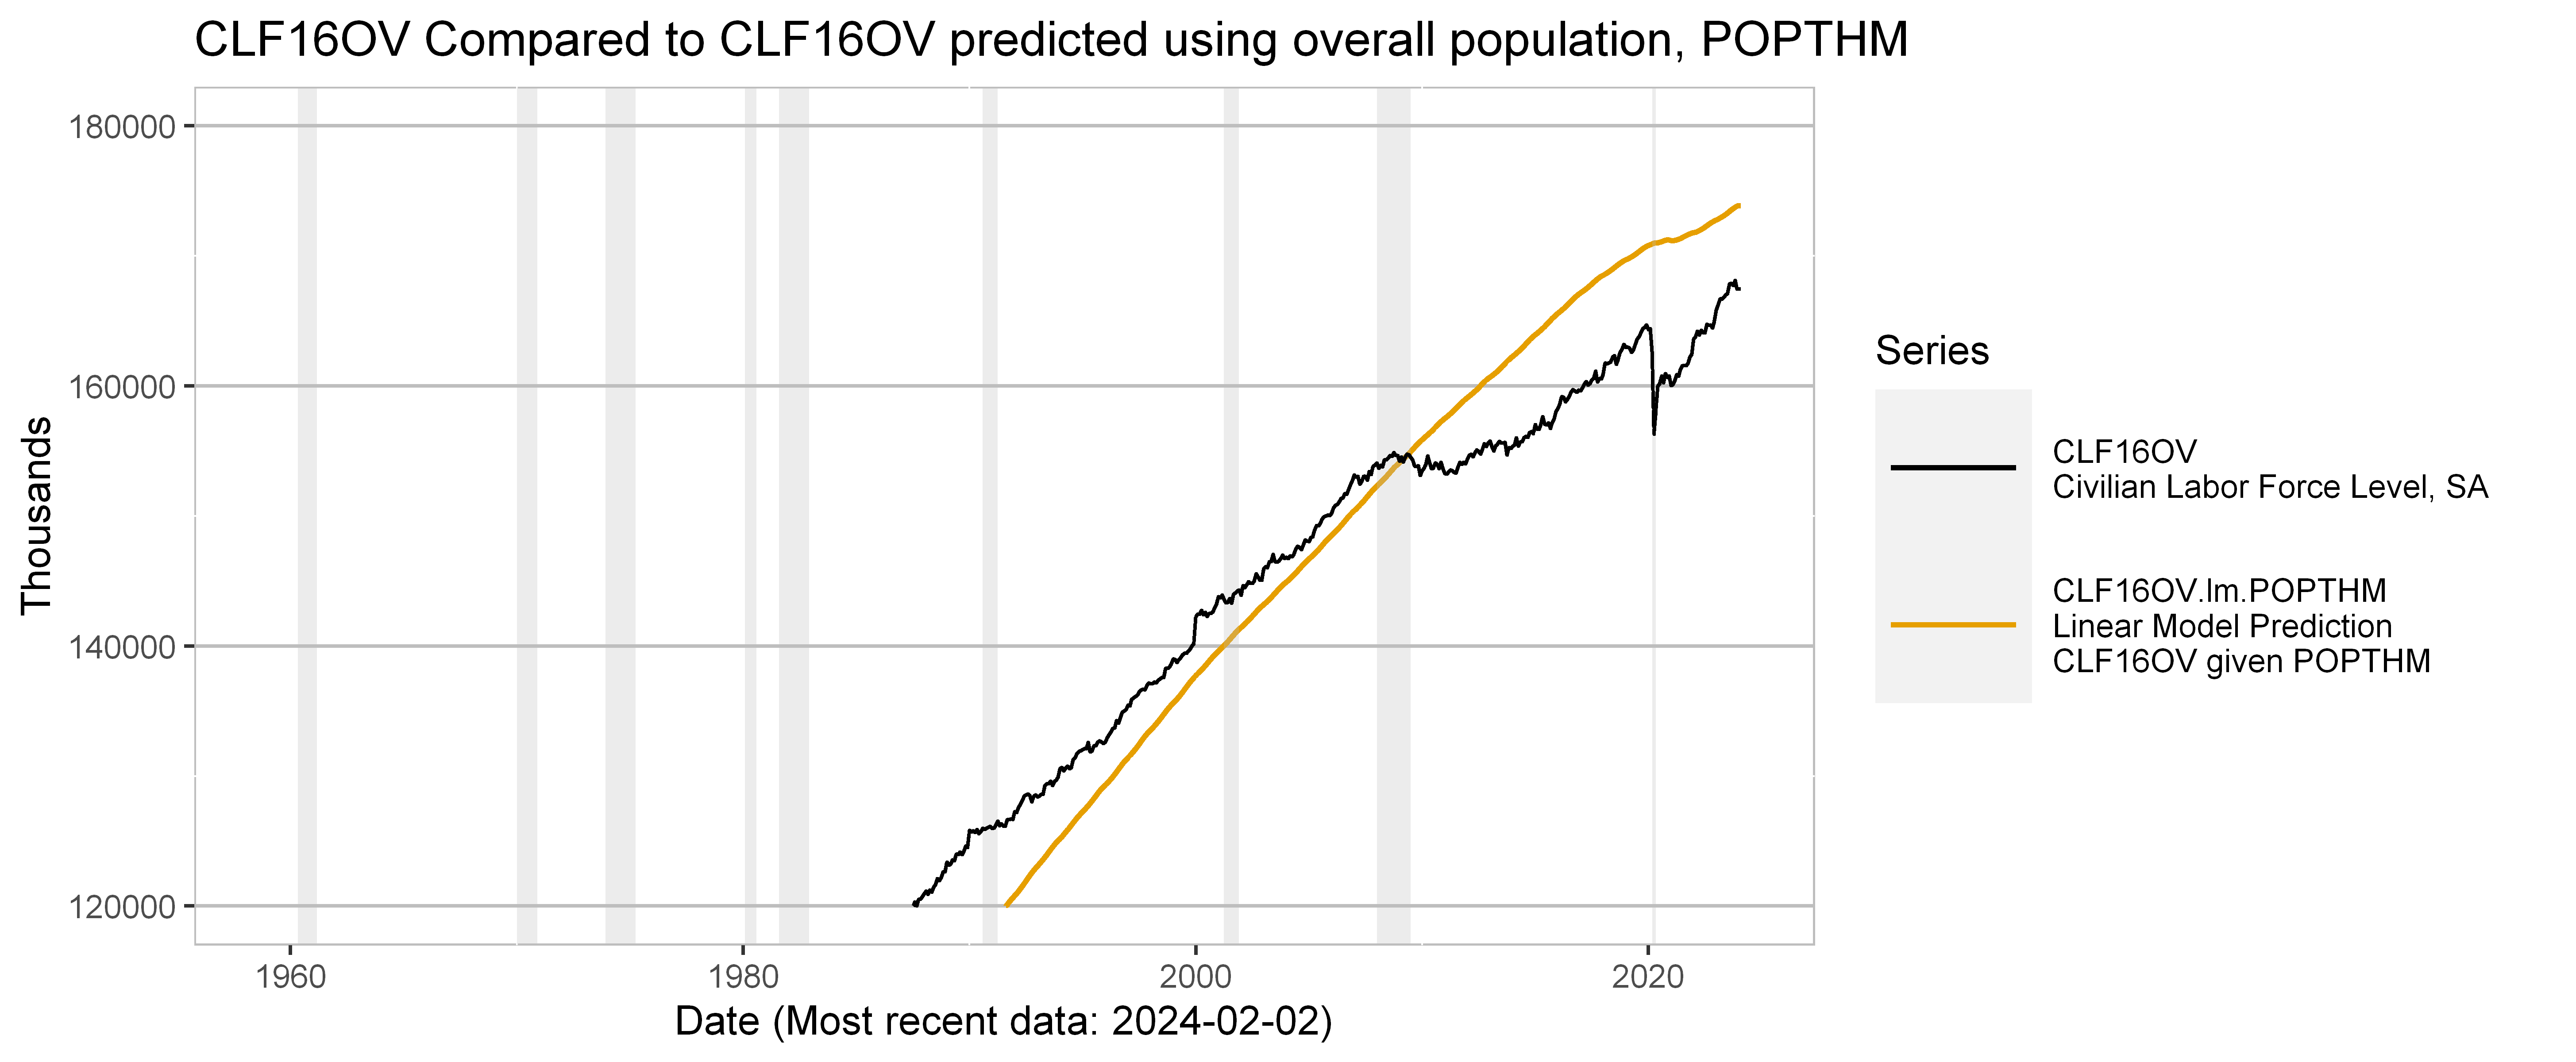

In [18]:
options(repr.plot.width = 9.7, repr.plot.height = 4, repr.plot.res = 600)
datay <- "CLF16OV.lm.POPTHM"
datay.aux <- "CLF16OV"
ylim <- c(120000, 180000)
dt.end <- Sys.Date()
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "CLF16OV Compared to CLF16OV predicted using overall population, POPTHM",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start.prediction, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

print(myPlot)

In [19]:
# Civilian work force divided by the general population
str.symbol <- "CLF16OV.by.POPTHM"
df.data[str.symbol] <- (df.data$CLF16OV / df.data$POPTHM) * 100

# Add the work force/population to the symbols
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Calc",
      string.description = "Civilian Work Force (CLF160V) / US Population (POPTHM)",
      string.label.y = "Percent",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start =  as.Date(max(c(
        index(CLF16OV[1]), index(POPTHM[1])
      )))  ,
      date.series.end = as.Date(min(c(
        index(tail(CLF16OV, 1)), index(tail(POPTHM, 1))
      )))
    )
  )

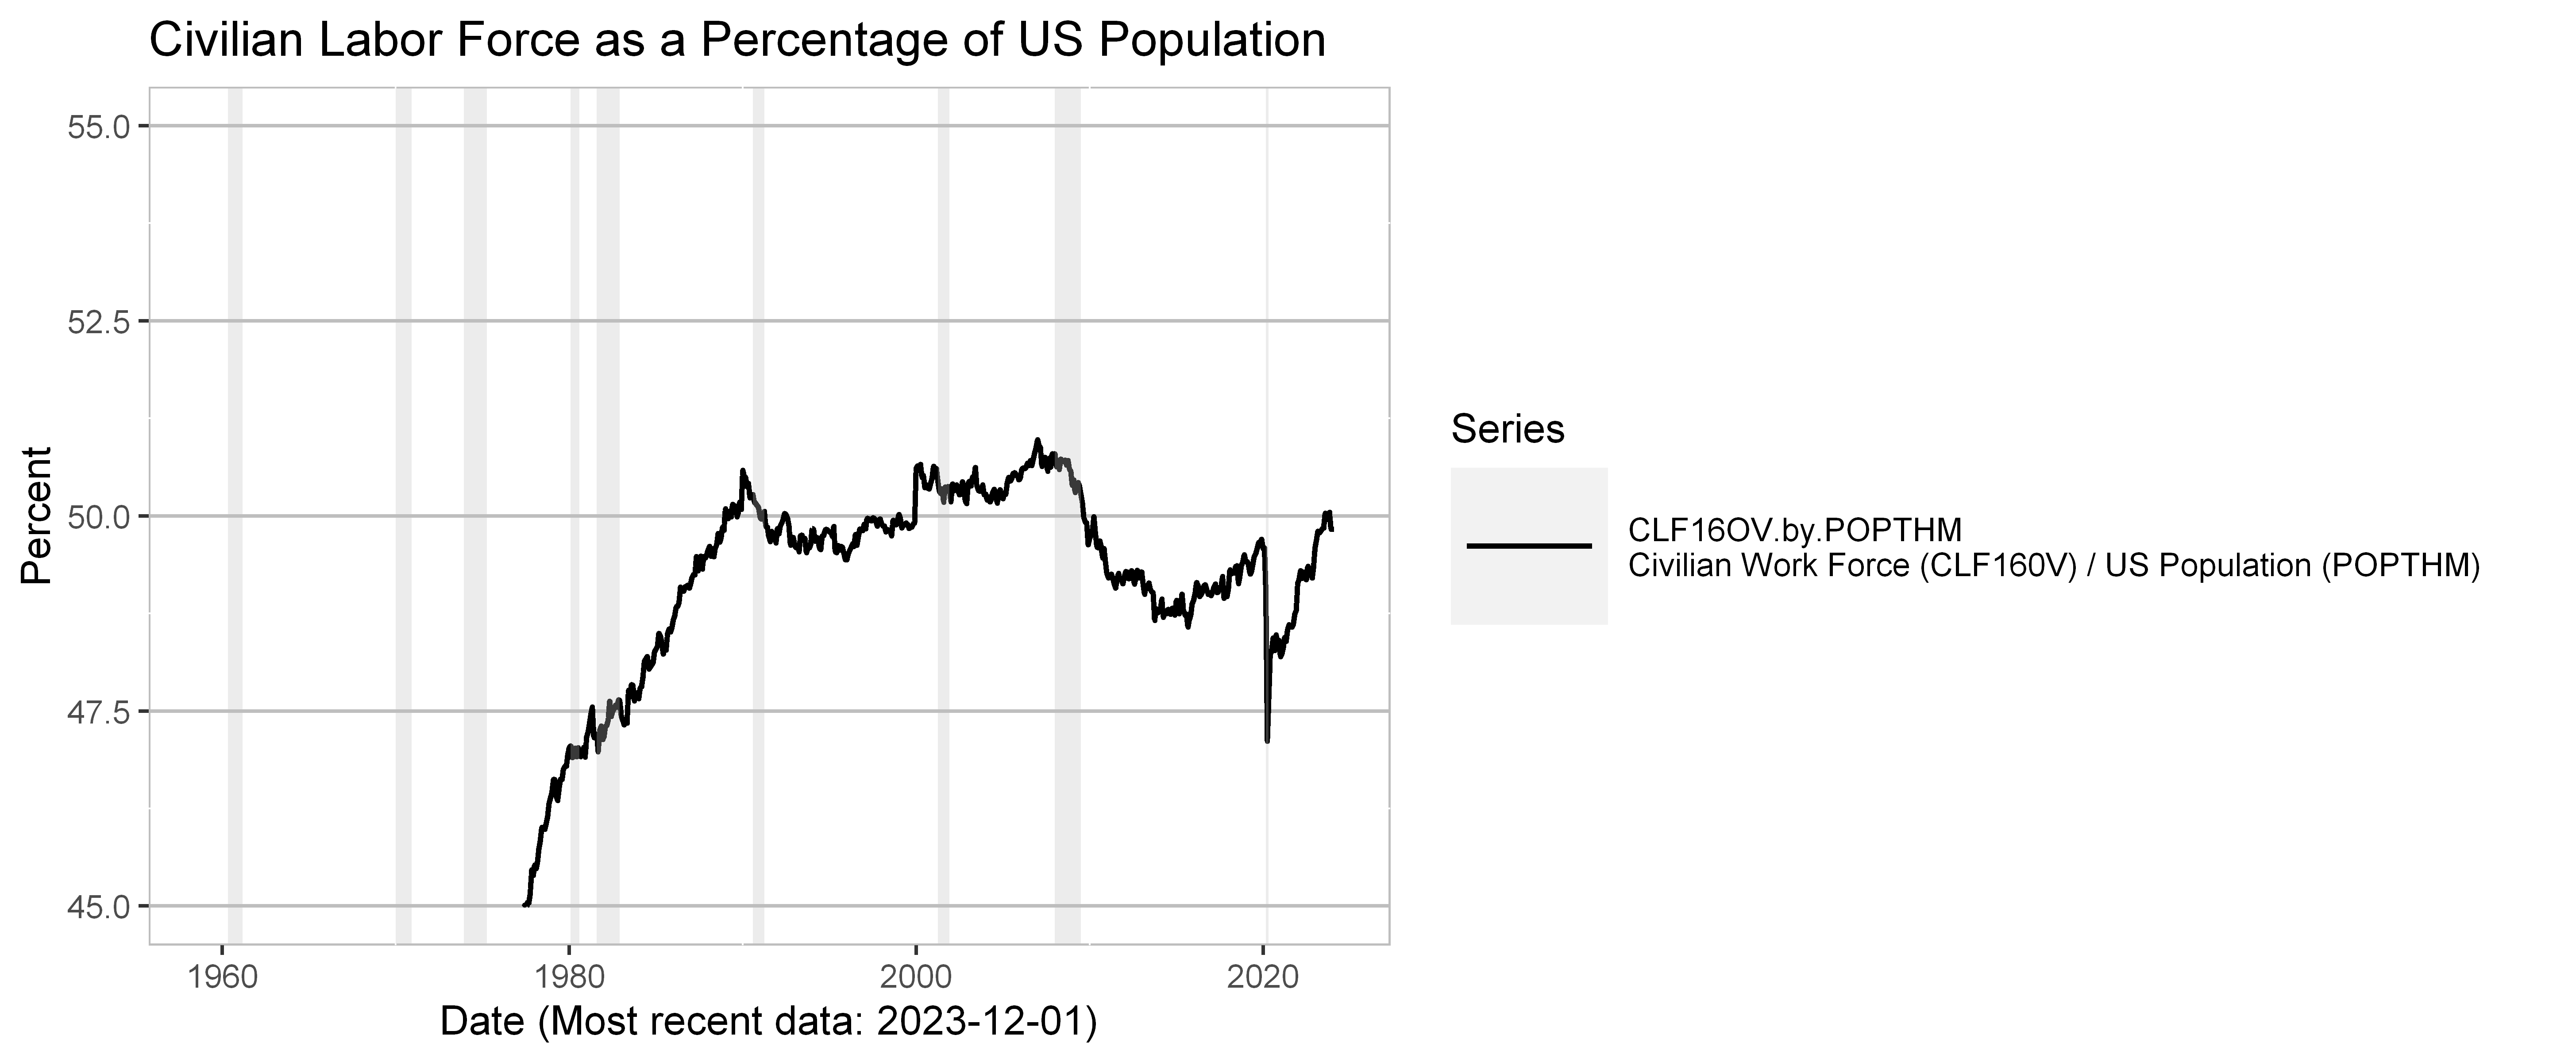

In [20]:
options(repr.plot.width = 9.7, repr.plot.height = 4, repr.plot.res = 600)
datay <- "CLF16OV.by.POPTHM"
ylim <- c(45, 55)
dt.end <- Sys.Date()
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "Civilian Labor Force as a Percentage of US Population",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start.prediction, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )


print(myPlot)

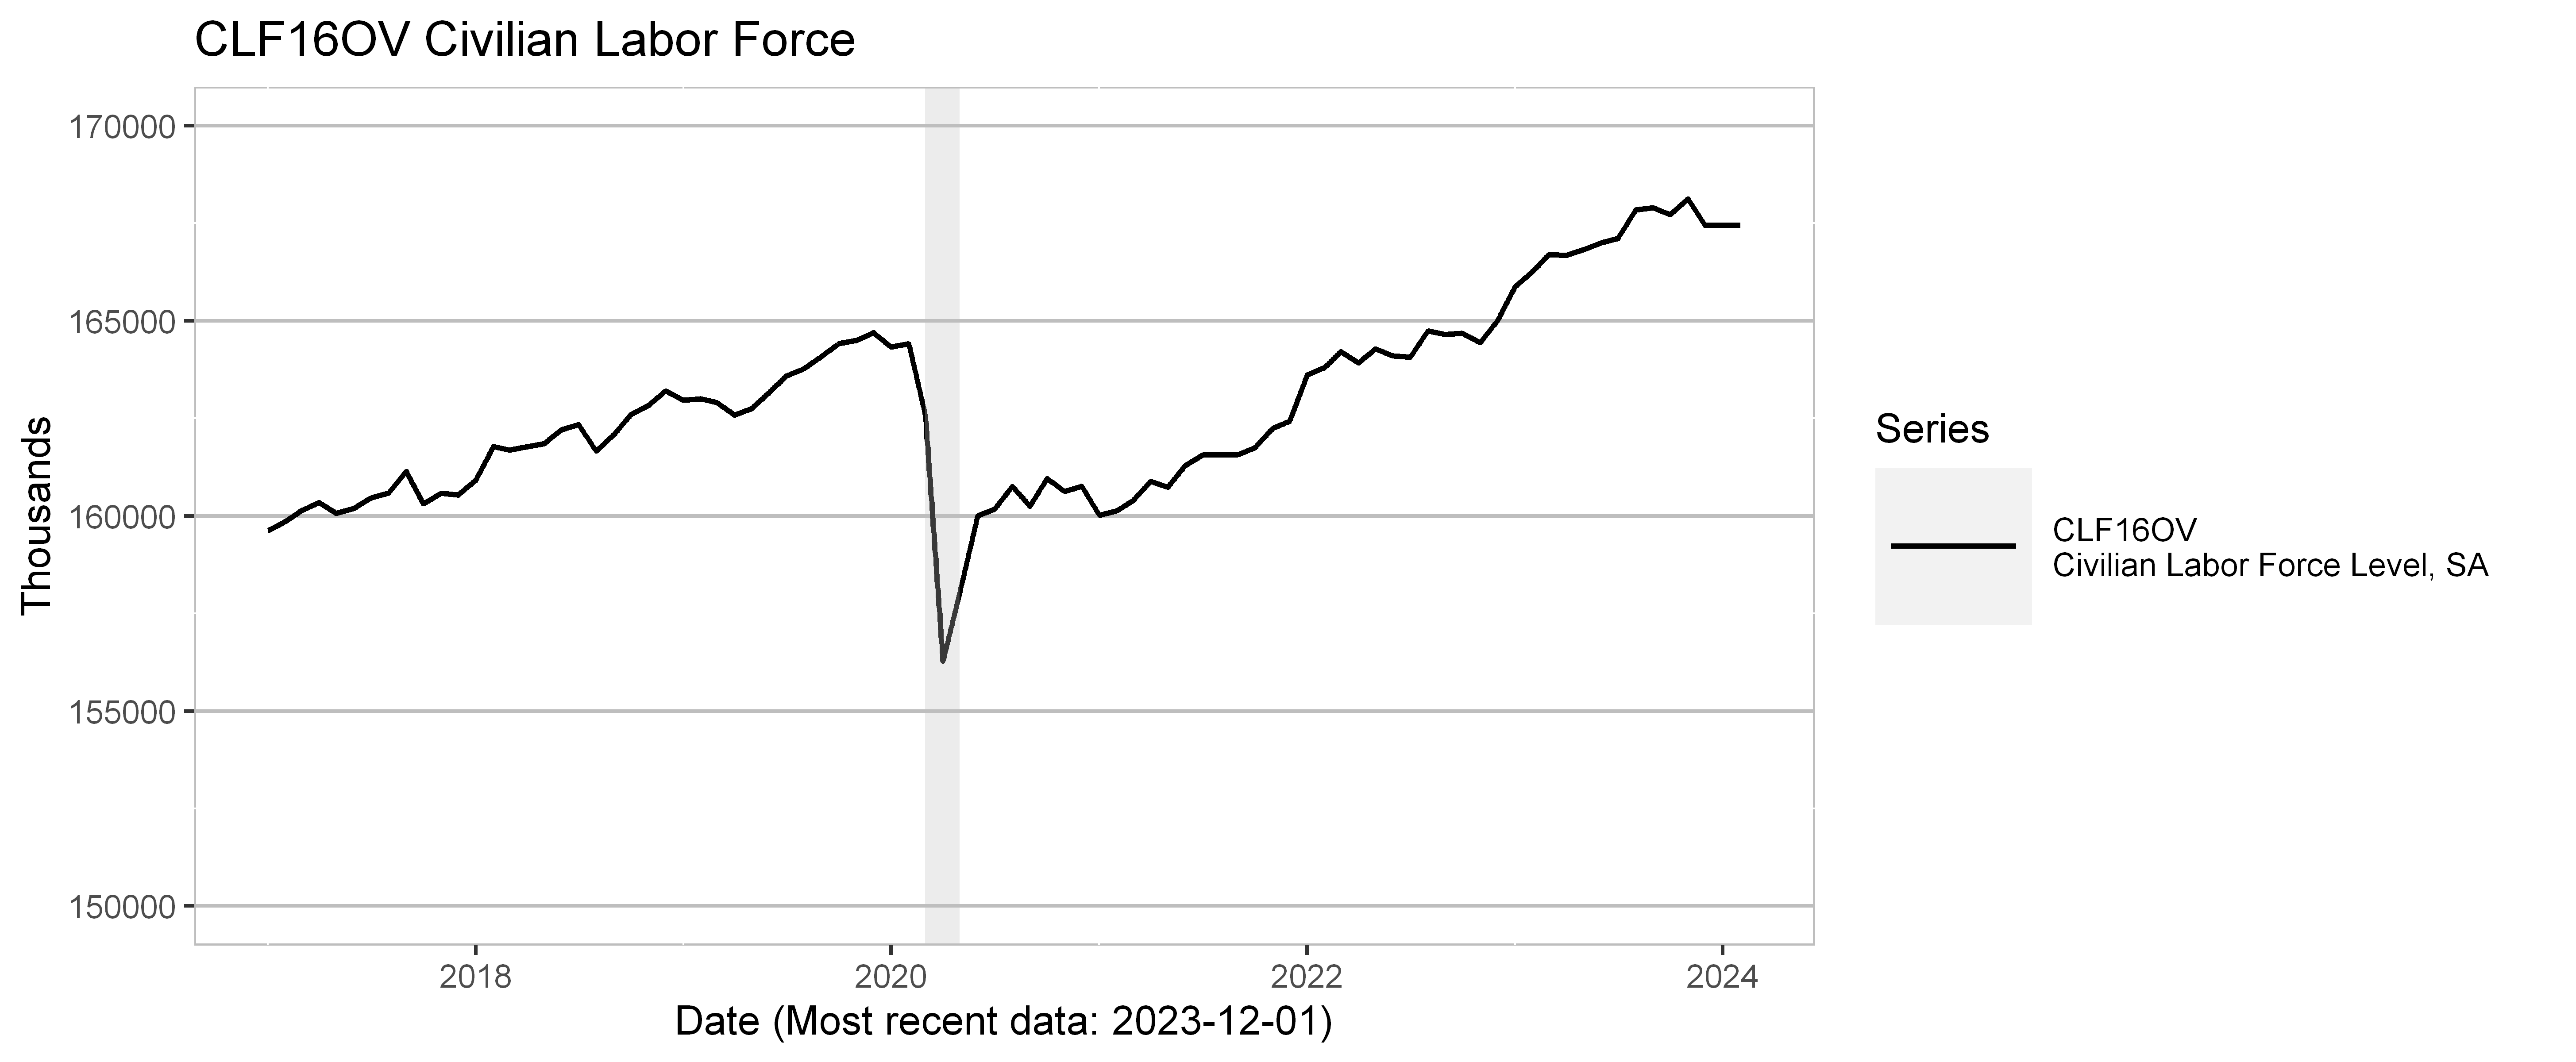

In [21]:
options(repr.plot.width = 9.7, repr.plot.height = 4, repr.plot.res = 600)
datay <- "CLF16OV"
ylim <- c(150000, 170000)
dt.end <- Sys.Date()
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "CLF16OV Civilian Labor Force",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.recent, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )


print(myPlot)

This section normalizes initial claims, ICSA, by the labor force estimated from the U.S. population, POPTHM.

In [22]:
# Add linear prediction to the dataframe
str.symbol <- "ICSA.by.CLF16OV.lm.POPTHM"
df.data[str.symbol] <- df.data$ICSA / df.data$CLF16OV.lm.POPTHM

# Add the linear model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "ICSA normalized by\nlabor force from POPTHM",
      string.label.y = "Percent",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


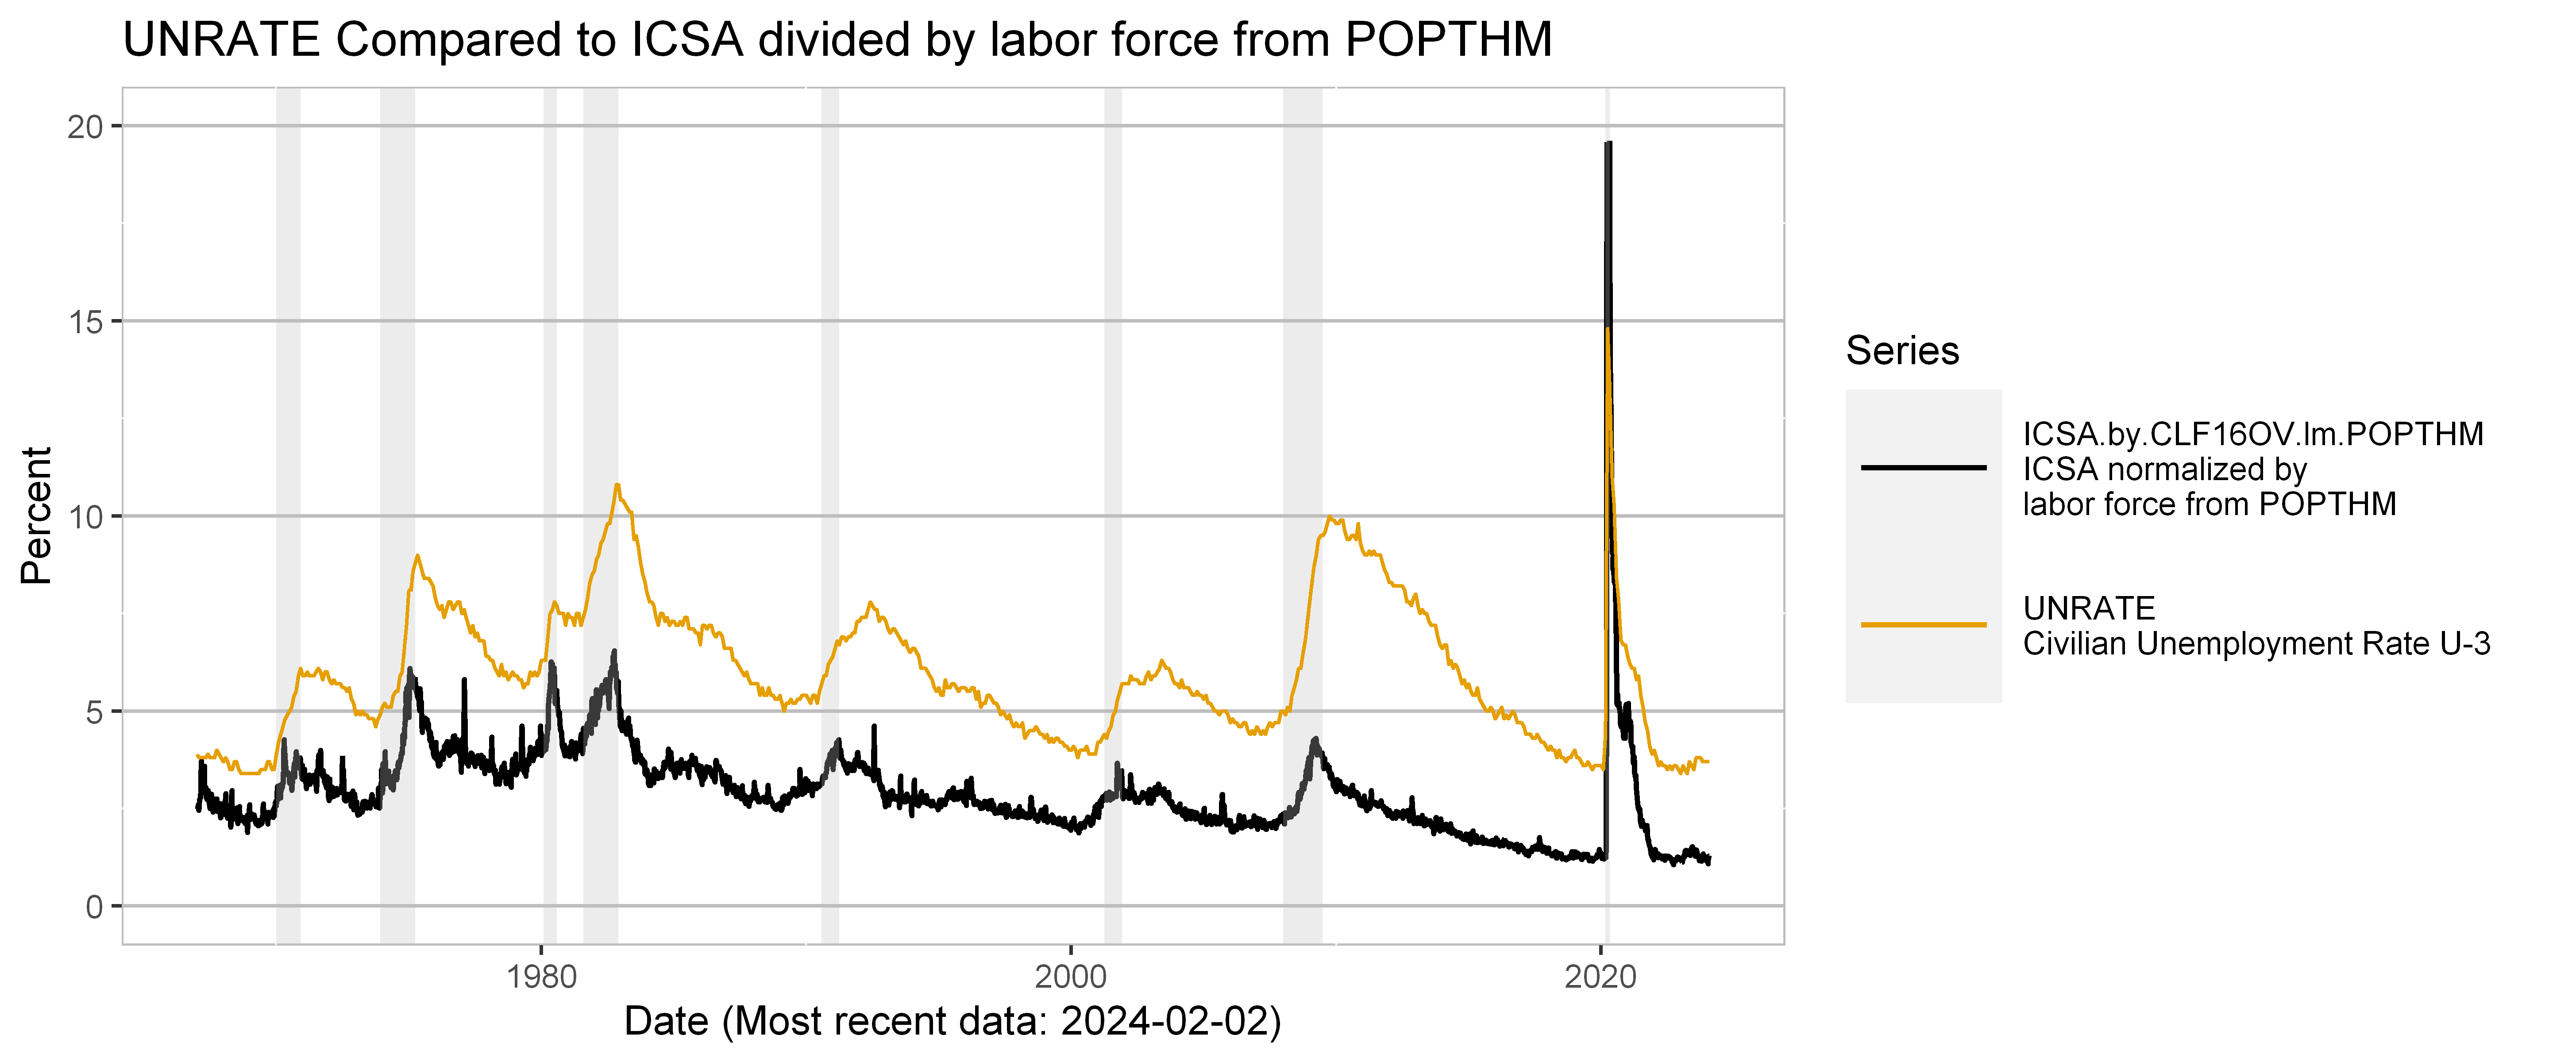

In [23]:
datay <- "ICSA.by.CLF16OV.lm.POPTHM"
datay.aux <- "UNRATE"
ylim <- c(0, 20)
dt.end <- Sys.Date()
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "UNRATE Compared to ICSA divided by labor force from POPTHM",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(index(ICSA[1]), dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

print(myPlot)

This section normalizes continued claims, CCSA, by the labor force estimated from the U.S. population, POPTHM.

In [24]:
# Add linear prediction to the dataframe
str.symbol <- "CCSA.by.CLF16OV.lm.POPTHM"
df.data[str.symbol] <- df.data$CCSA / df.data$CLF16OV.lm.POPTHM

# Add the linear model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "CCSA normalized by\nlabor force from POPTHM",
      string.label.y = "Percent",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


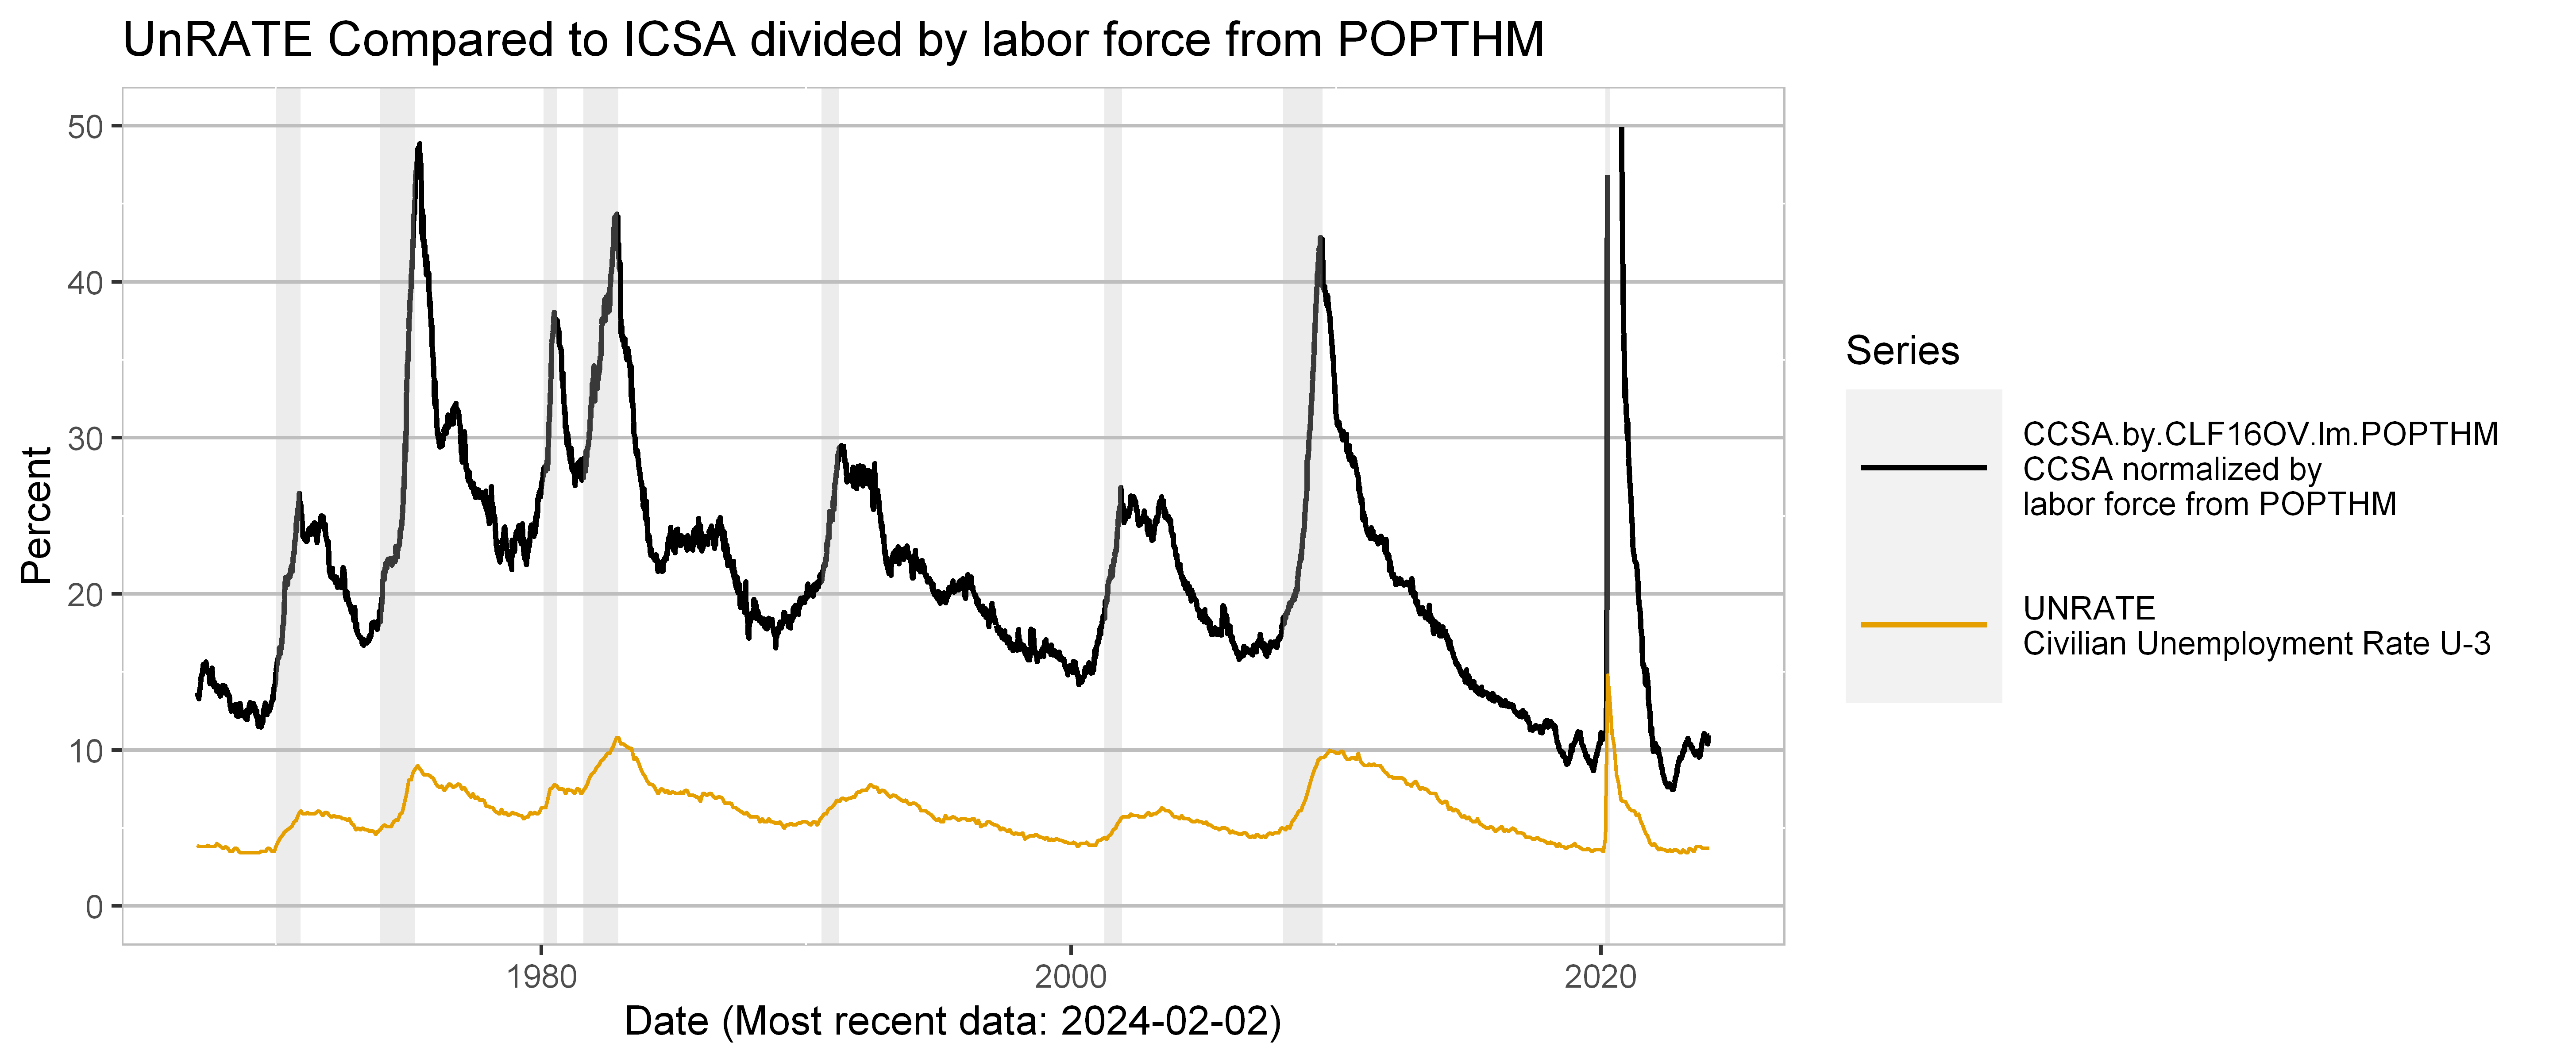

In [25]:
datay <- "CCSA.by.CLF16OV.lm.POPTHM"
datay.aux <- "UNRATE"
ylim <- c(0, 50)
dt.end <- Sys.Date()
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "UnRATE Compared to ICSA divided by labor force from POPTHM",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(index(CCSA[1]), dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

print(myPlot)

This section normalizes total non-farm payroll data provided by ADP and in the NPPTTL series on FRED. Unlike ICSA or CCSA the values here are thousands rather than numbers.

In [26]:
# Add linear prediction to the dataframe
str.symbol <- "NPPTTL.by.CLF16OV.lm.POPTHM"
df.data[str.symbol] <- 100 * ( 1 - (df.data$NPPTTL / df.data$CLF16OV.lm.POPTHM) )

# Add the linear model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "NPPTTL (ADP) normalized by\nlabor force from POPTHM",
      string.label.y = "Percent",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


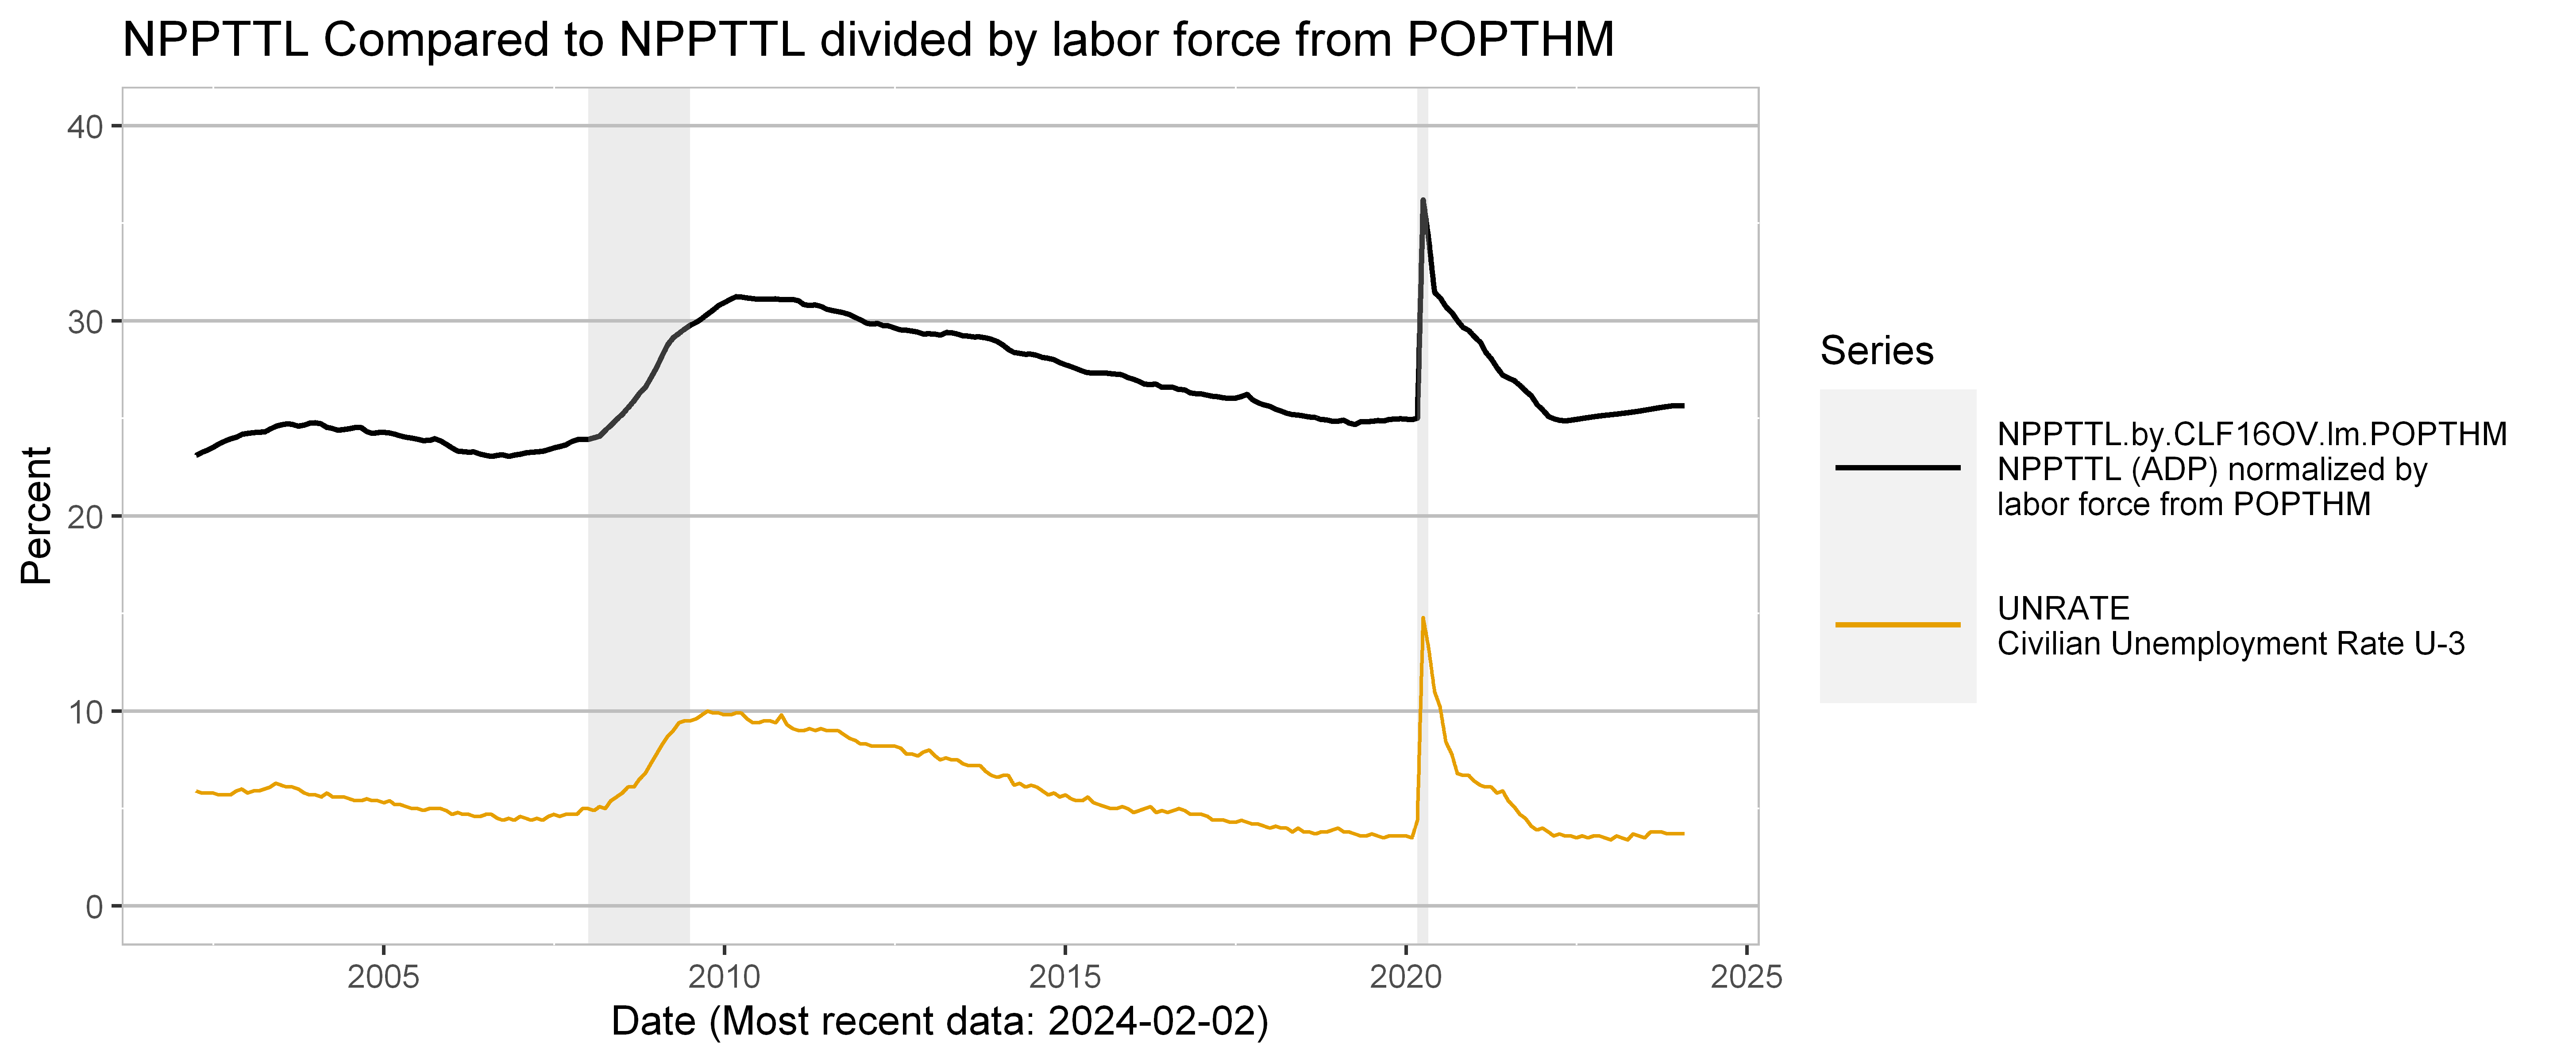

In [27]:
datay <- "NPPTTL.by.CLF16OV.lm.POPTHM"
datay.aux <- "UNRATE"
ylim <- c(0, 40)
dt.end <- Sys.Date()
dt.start <- index(NPPTTL[1])
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "NPPTTL Compared to NPPTTL divided by labor force from POPTHM",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

print(myPlot)

### Employment Correlation, U6 and U3

Correlation across some of the series. This section checks that survey data is coherent within itself. Do the U3 and U5 series generally agree?

The U6 numbers do not have as much historical data as the U3 so valid data for fit begins early. I also exluded the Covid 16 mess of data.

In [28]:
dt.start.prediction <- as.Date("1994-01-01")
dt.end.prediction <- as.Date("2020-01-01")
df.emp.model <-
  df.data[df.data$date >= dt.start.prediction &
            df.data$date <= dt.end.prediction,]


# I break the data into three sets: 50% for training, 25% for testing, and 25% for validation.
set.seed(123456)
in.train <- createDataPartition(y=df.emp.model$U6RATE, p = 0.50, list=FALSE)
df.train <- df.emp.model[in.train,]
df.data.rest <- df.emp.model[-in.train,]
in.val <- createDataPartition(y = df.data.rest$U6RATE, p = 0.50, list = FALSE)
df.val <- df.data.rest[in.val,]
df.test <- df.data.rest[-in.val,]
rm(df.data.rest)

In [29]:
# Perform the linear fit
list.fit.u3u6 <- train(
  U6RATE ~ UNRATE,
  data = df.train,
  method = "lm",
  preProcess = c('center', 'scale')
)

# Perform the knn fit
list.fit.knn.u3u6 <- train(
  U6RATE ~ UNRATE,
  data = df.train,
  method = "knn",
  preProcess = c('center', 'scale')
)

# Perform the neural net fit
# list.fit.nnet.u3u6 <- train(
#   U6RATE ~ UNRATE,
#   data = df.train,
#   method = "nnet",
#   preProcess = c('center', 'scale'),
#   trace = FALSE
# )

rm(df.emp.model)
rm(df.train)
rm(df.val)


In [30]:
# Add prediction to the dataframe
str.symbol <- "U6.lm.U3"
df.data[str.symbol] <-
  predict(list.fit.u3u6, newdata = df.data)

# Add the linear model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "Linear Model Prediction\nU6 given U3",
      string.label.y = df.symbols[df.symbols$string.symbol=="UNRATE","string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Document the residual as well
str.symbol.res <- "U6.lm.U3.res"
df.data[str.symbol.res] <- df.data$U6RATE - df.data[str.symbol]

# Add the u6 linear model residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.res,
      string.source = "Predict Resid.",
      string.description = "Linear Model Residual\nU6 given U3",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Add knn prediction to the dataframe
str.symbol.knn <- "U6.knn.U3"
df.data[str.symbol.knn] <-
  predict(list.fit.knn.u3u6, newdata = df.data)

# Add the knn prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.knn,
      string.source = "Predict",
      string.description = "KNN Model Prediction\nU6 given U3",
      string.label.y = df.symbols[df.symbols$string.symbol=="UNRATE","string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Document the residual as well
str.symbol.res.knn <- "U6.knn.U3.res"
df.data[str.symbol.res.knn] <- df.data$U6RATE - df.data[str.symbol.knn]

# Add the u6 linear model residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.res.knn,
      string.source = "Predict Resid.",
      string.description = "KNN Model Residual\nU6 given U3",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


# # Add nnet prediction to the dataframe
# str.symbol.nnet <- "U6.nnet.U3"
# df.data[str.symbol.nnet] <-
#   predict(list.fit.nnet.u3u6, newdata = df.data)
# 
# # Add the nnet prediction to the symbols table
# df.symbols <-
#   rbind(
#     df.symbols,
#     data.frame(
#       string.symbol = str.symbol.nnet,
#       string.source = "Predict",
#       string.description = "NN Model Prediction\nU6 given U3",
#       string.label.y = df.symbols[df.symbols$string.symbol=="UNRATE","string.label.y"],
#       float.expense.ratio = -1.00,
#       Max030 = FALSE,
#       Max180 = FALSE,
#       date.series.start = dt.start.prediction,
#       date.series.end = as.Date(Sys.Date())
#     )
#   )
# 
# # Document the residual as well
# str.symbol.res.nnet <- "U6.nnet.U3.res"
# df.data[str.symbol.res.nnet] <- df.data$U6RATE - df.data[str.symbol.nnet]
# 
# # Add the u6 nnet model residual to the symbols table
# df.symbols <-
#   rbind(
#     df.symbols,
#     data.frame(
#       string.symbol = str.symbol.res.nnet,
#       string.source = "Predict Resid.",
#       string.description = "NN Model Residual\nU6 given U3",
#       string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
#       float.expense.ratio = -1.00,
#       Max030 = FALSE,
#       Max180 = FALSE,
#       date.series.start = dt.start.prediction,
#       date.series.end = as.Date(Sys.Date())
#     )
#   )


Look at how the fits performed on the test data partition

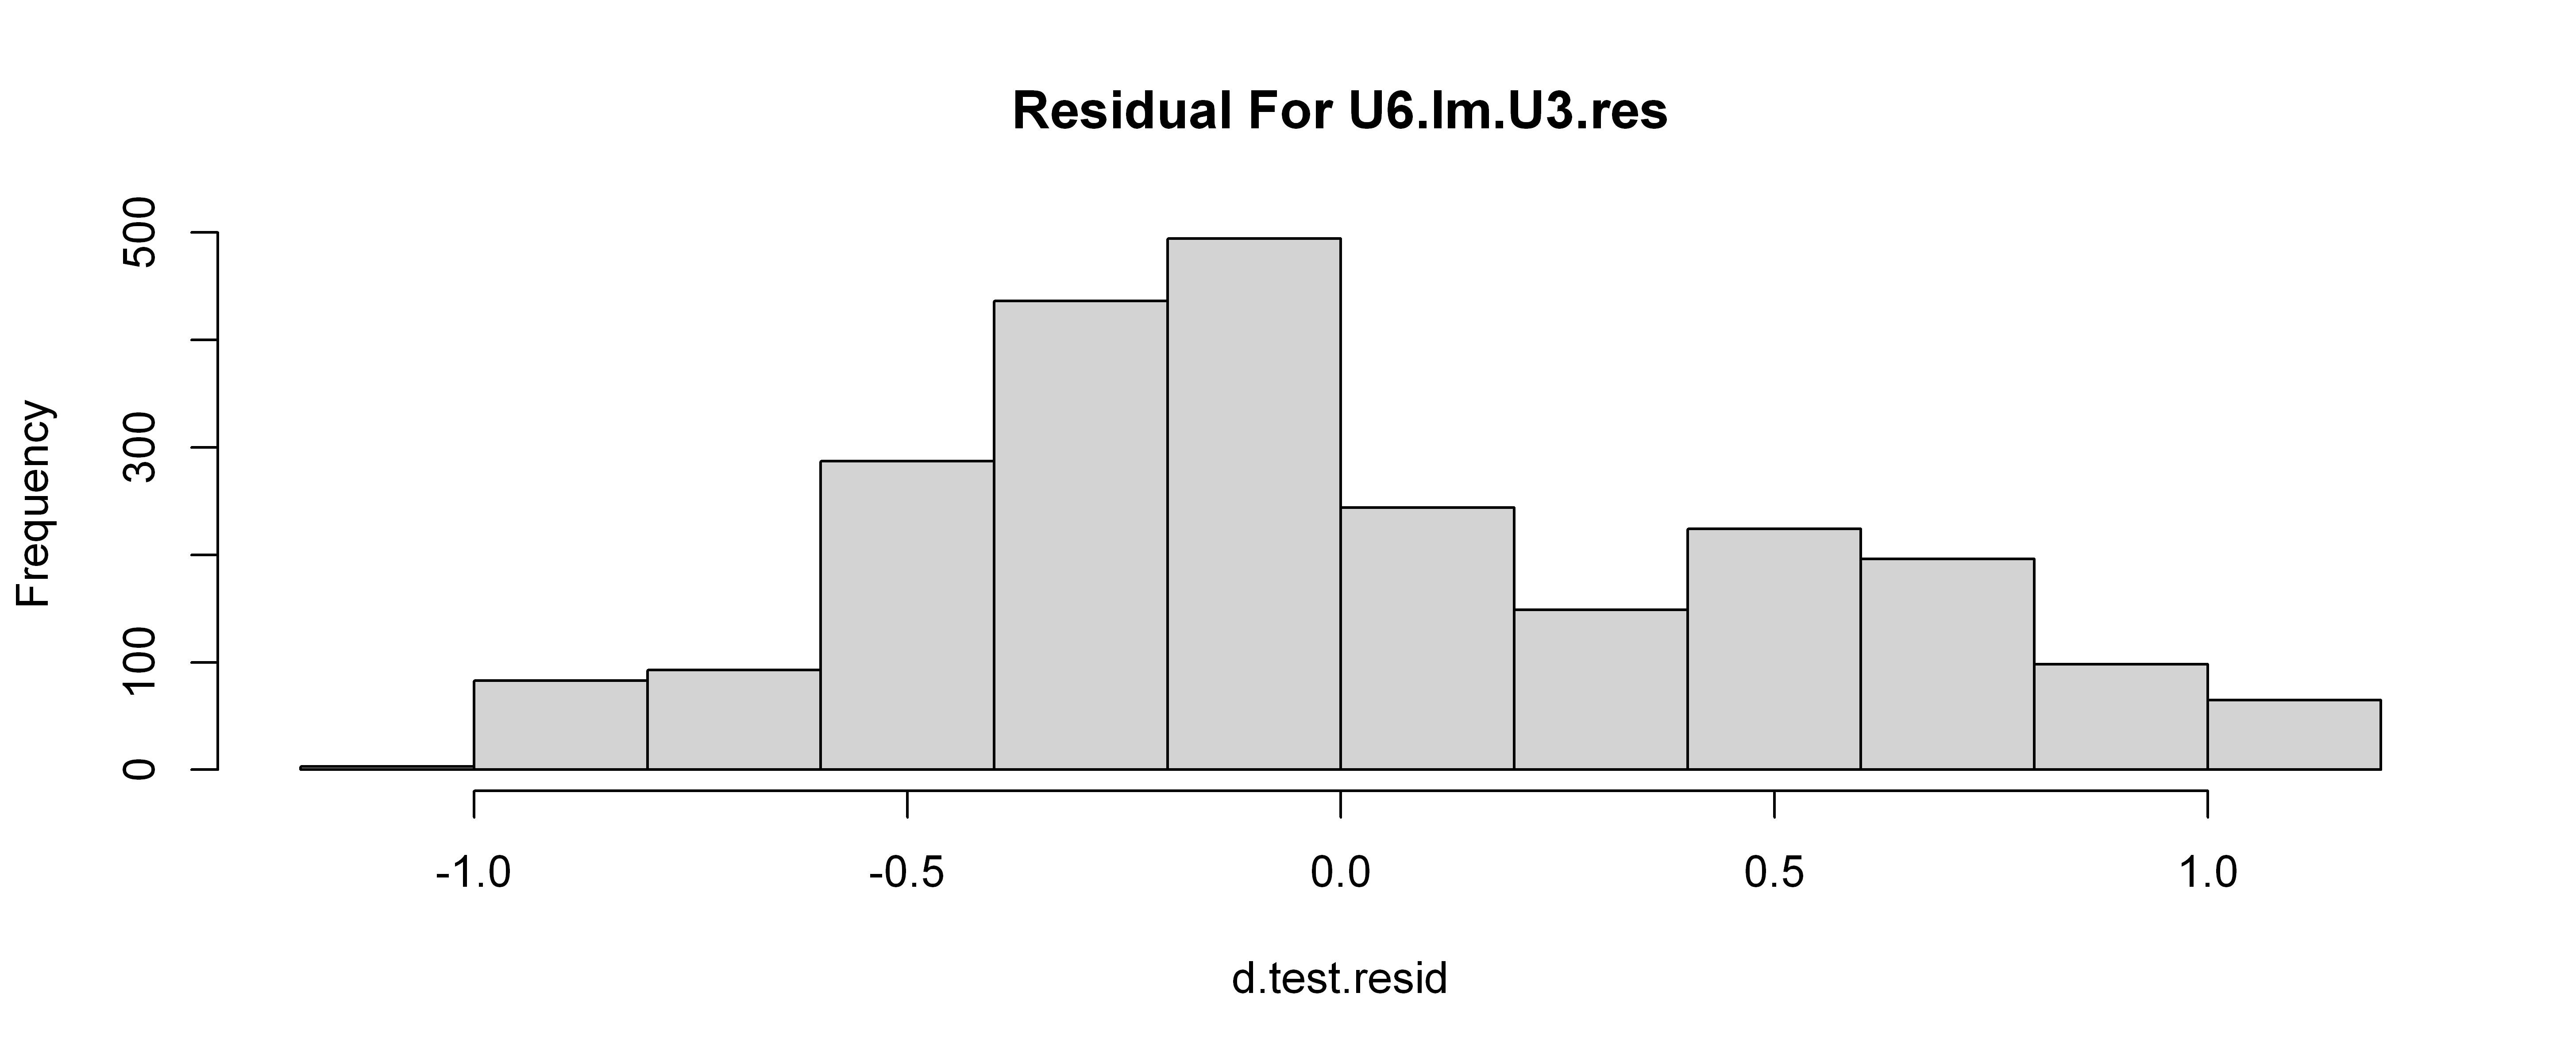

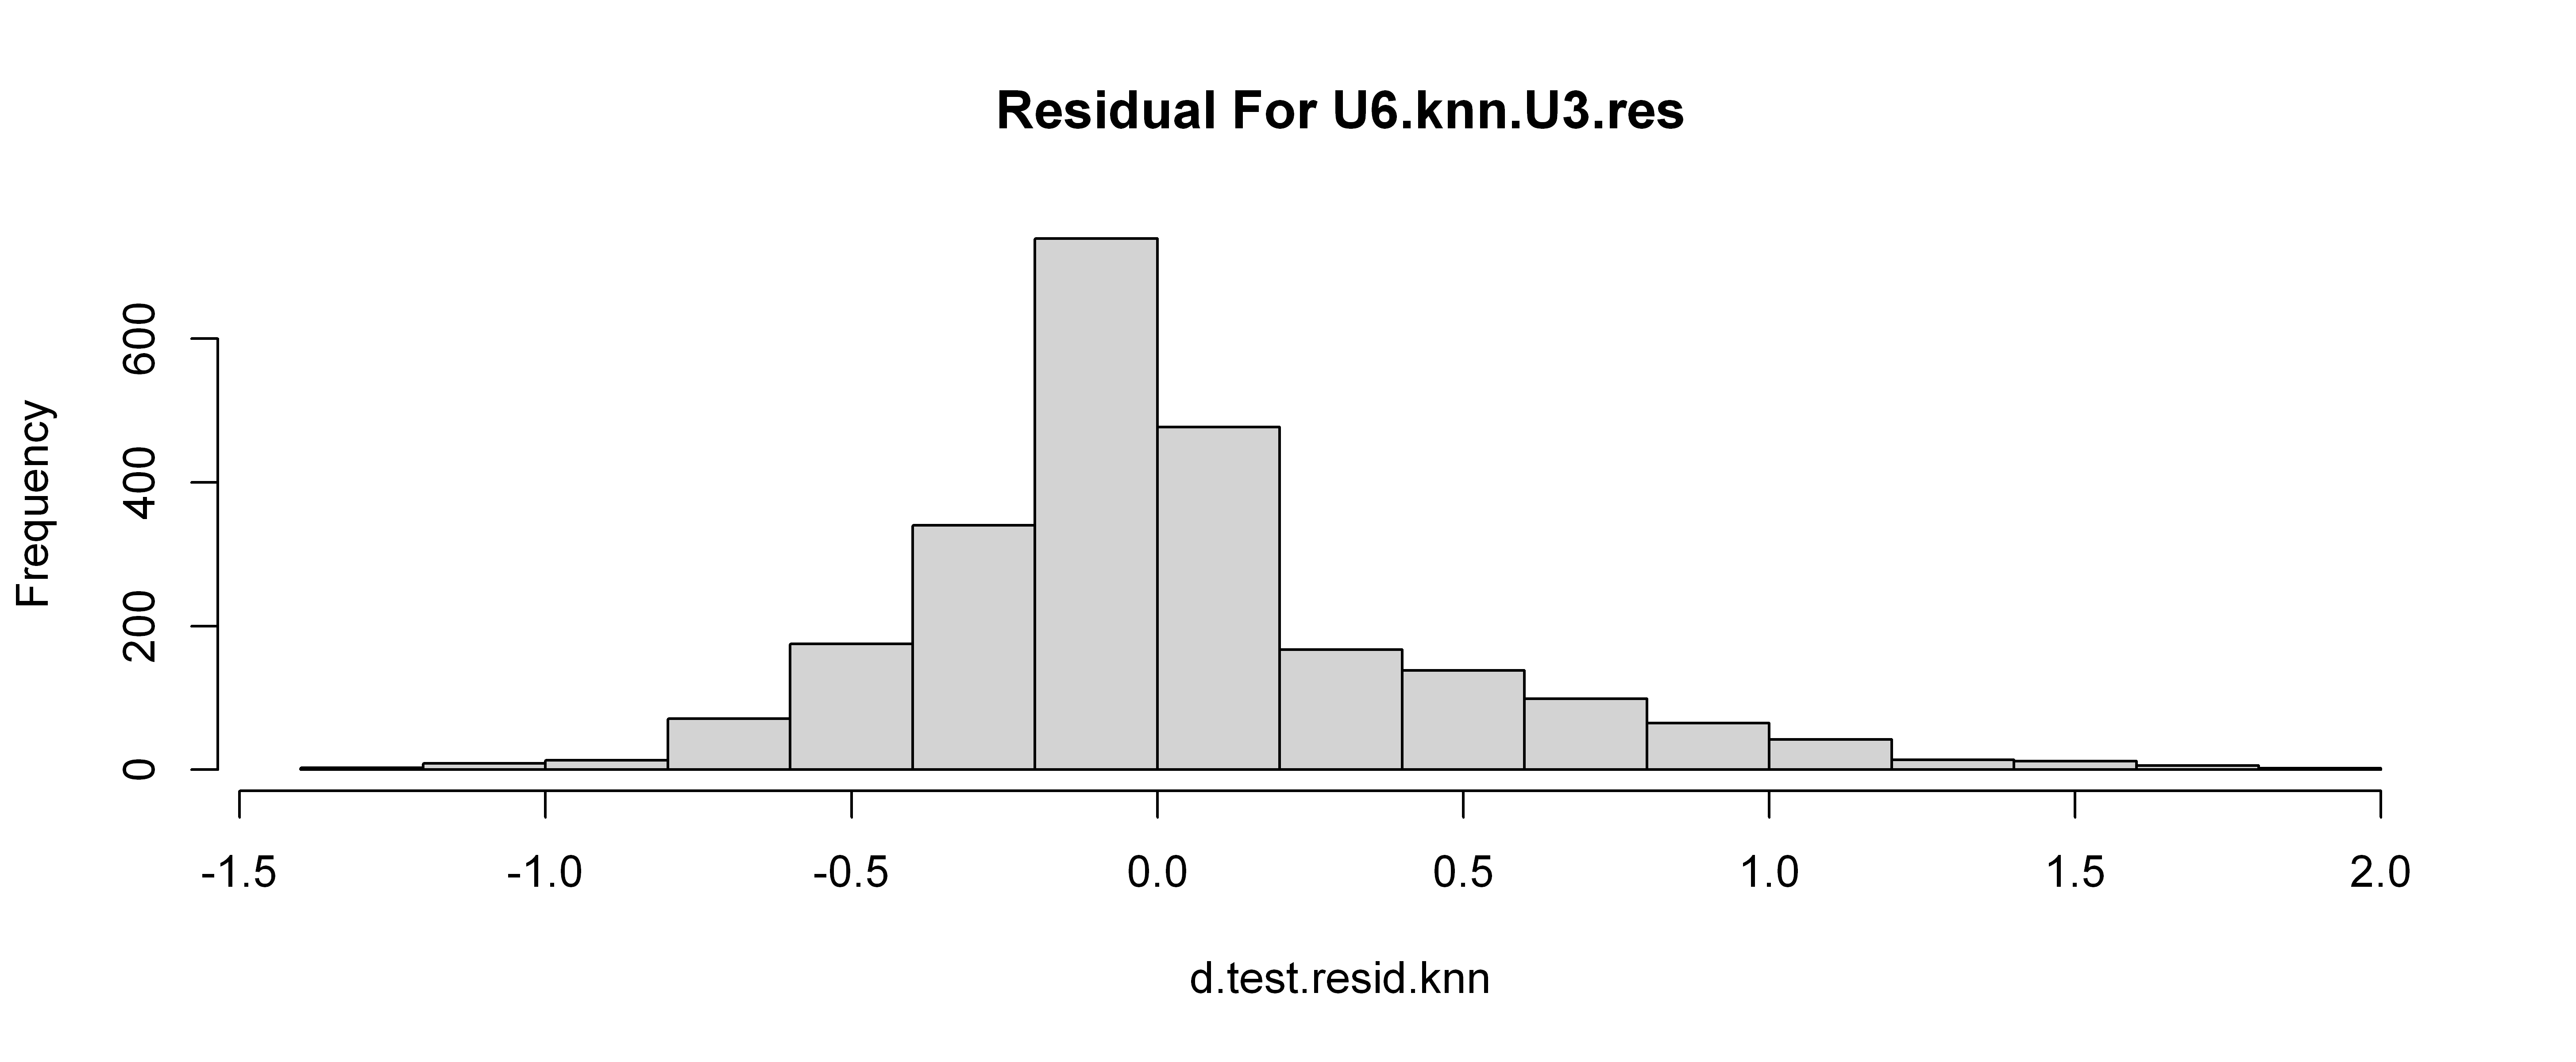

In [31]:
d.test.resid = (df.test$U6RATE - predict(list.fit.u3u6, newdata = df.test))
hist(d.test.resid, main=paste("Residual For", str.symbol.res, sep=" "))
sd.fit.u3u6 = sd(d.test.resid)


d.test.resid.knn = (df.test$U6RATE - predict(list.fit.knn.u3u6, newdata = df.test))
hist(d.test.resid.knn, main=paste("Residual For", str.symbol.res.knn, sep=" "))
sd.fit.knn.u3u6 = sd(d.test.resid.knn)

# d.test.resid.nnet = (df.test$U6RATE - predict(list.fit.nnet.u3u6, newdata = df.test))
# hist(d.test.resid.nnet, main=paste("Residual For", str.symbol.res.nnet, sep=" "))
# sd.fit.nnet.u3u6 = sd(d.test.resid.nnet)

Plot the measured U6 (U6RATE) to U6 predicted by a linear fit to U3.

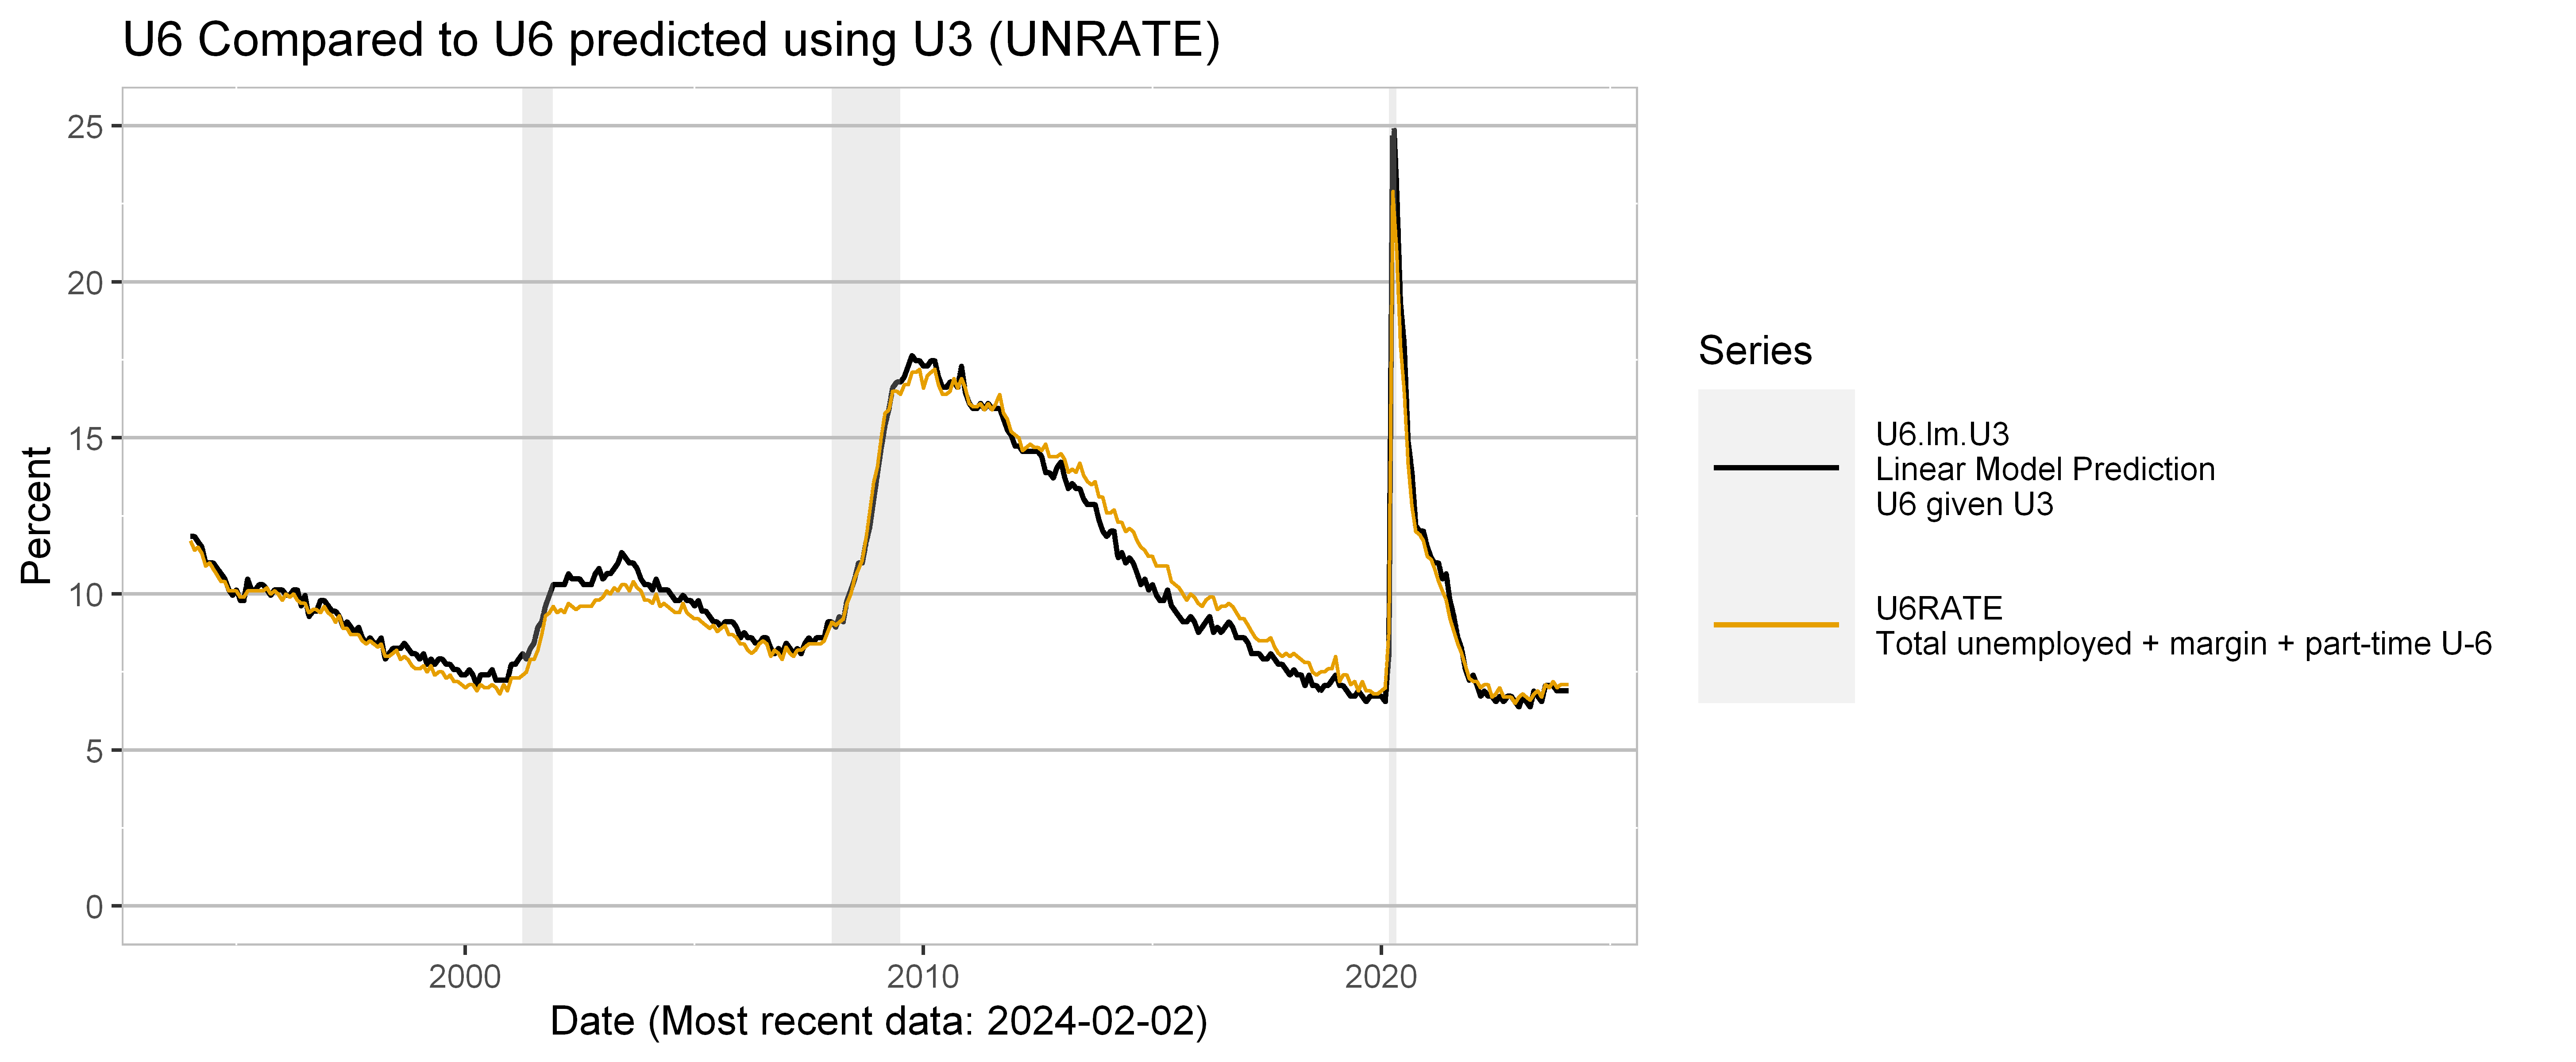

In [32]:
datay <- "U6.lm.U3"
# datay.aux <- str.symbol.nnet
datay.aux <- "U6RATE"
# datay.aux.1 <- "U6RATE"
ylim <- c(0, 25)
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "U6 Compared to U6 predicted using U3 (UNRATE)",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(as.Date("1jan1994", "%d%b%Y"), Sys.Date()),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

# myPlot <- myPlot + geom_line(
#   data = df.data,
#   aes_string(
#     x = "date",
#     y = datay.aux.1,
#     colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
#   ),
#   na.rm = TRUE
# )

# myPlot <- myPlot + geom_line(
#   data = df.data,
#   aes_string(
#     x = "date",
#     y = datay.aux.2,
#     colour = shQuote(getPlotTitle(df.symbols, datay.aux.2))
#   ),
#   na.rm = TRUE
# )

print(myPlot)

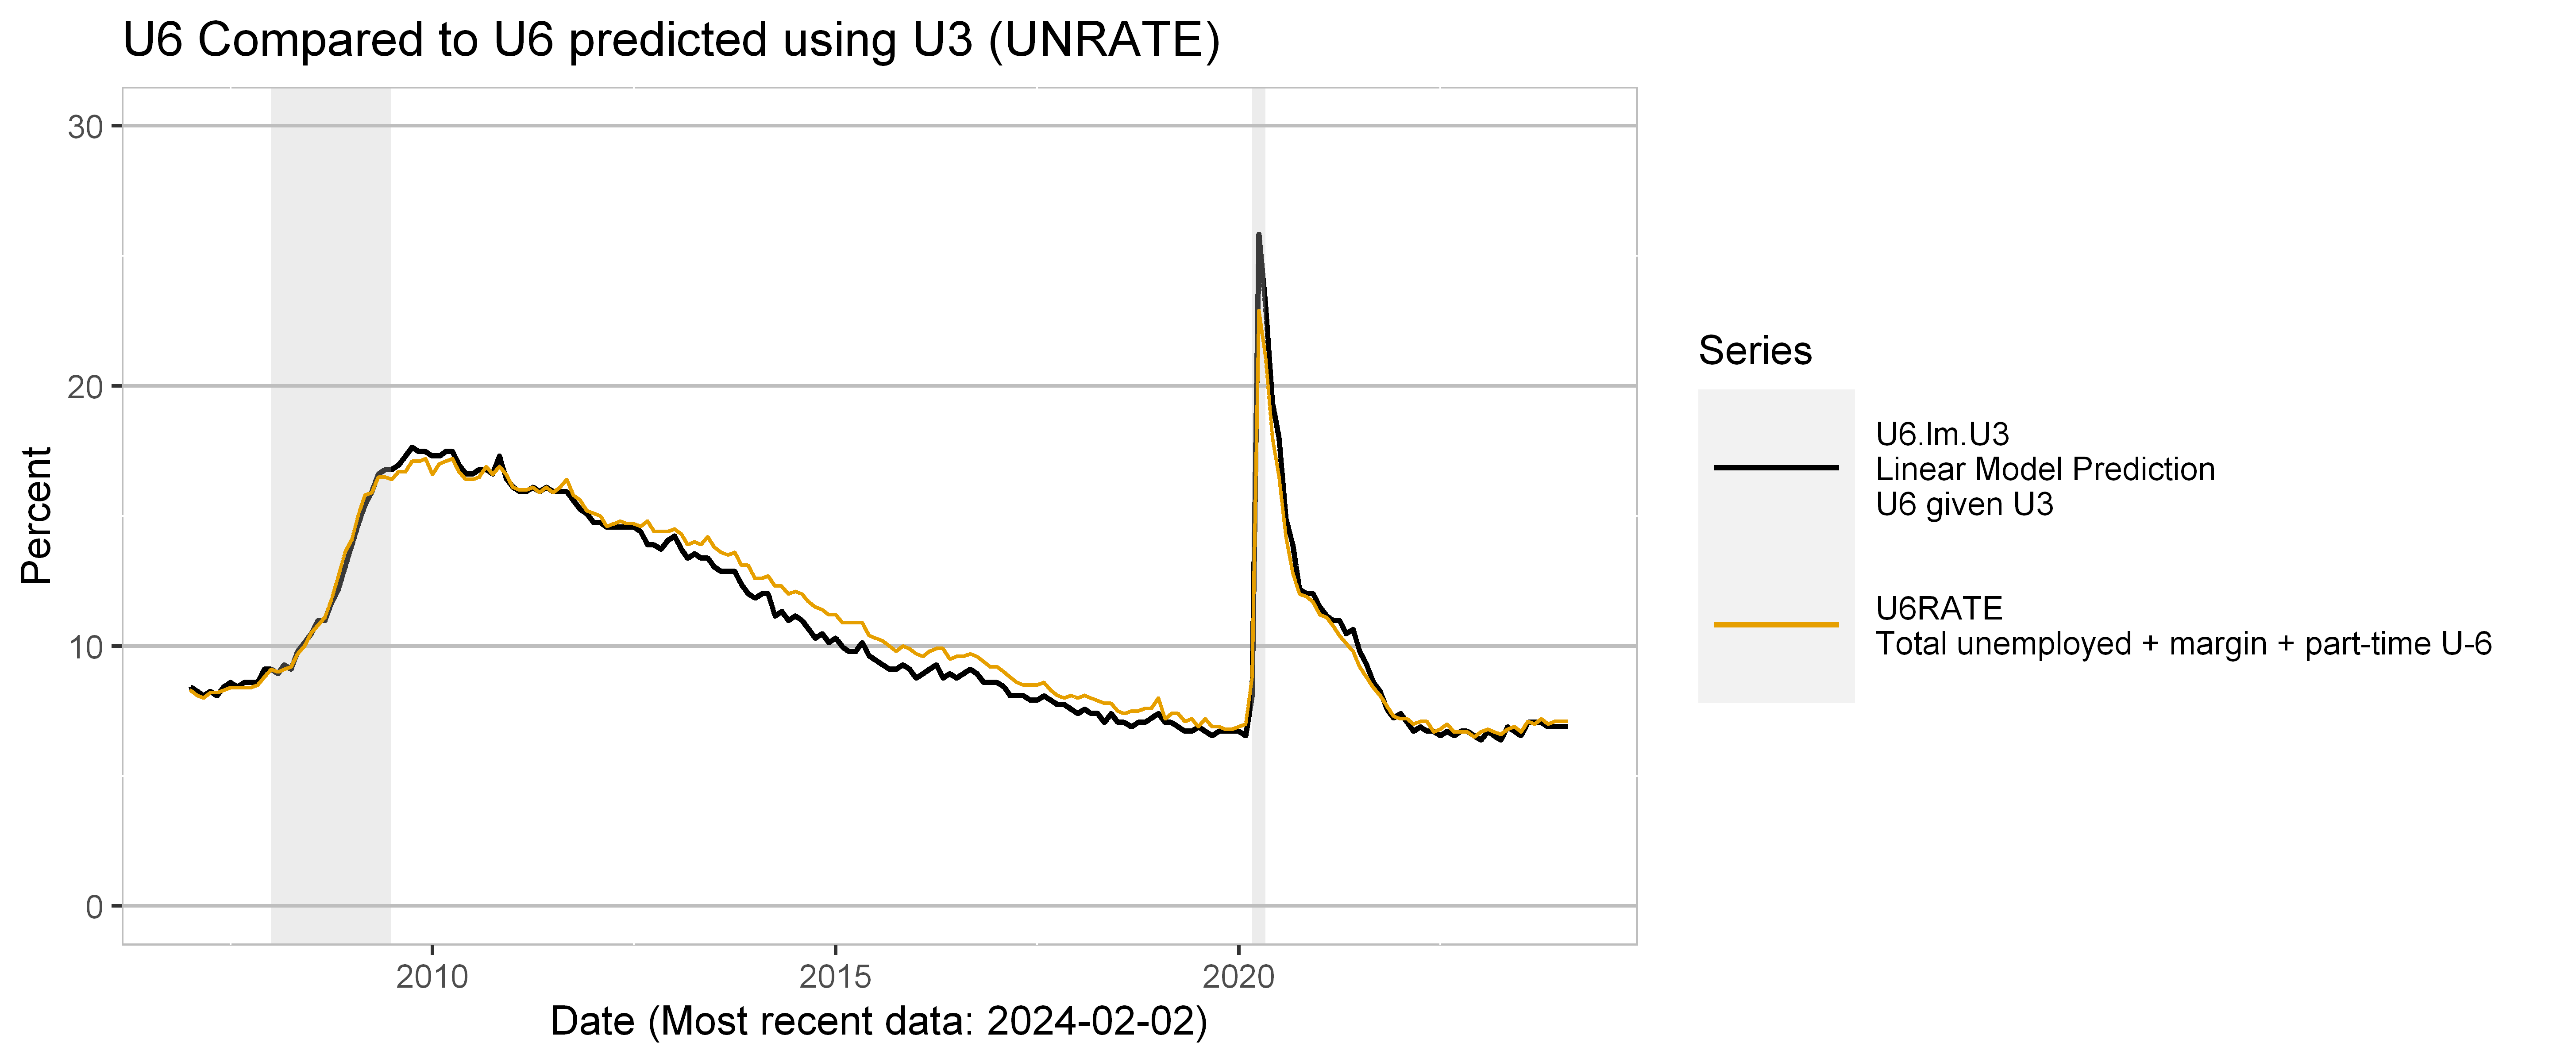

In [33]:
datay <- "U6.lm.U3"
datay.aux <- "U6RATE"
# datay.aux.1 <- "U6RATE"
ylim <- c(0, 30)
dt.start <- as.Date('2007-01-02')
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "U6 Compared to U6 predicted using U3 (UNRATE)",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start, Sys.Date()),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)
# myPlot <- myPlot + geom_line(
#   data = df.data,
#   aes_string(
#     x = "date",
#     y = datay.aux.1,
#     colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
#   ),
#   na.rm = TRUE
# )


print(myPlot)

Plot the residual for the U6 linear fit. The residuals decrease quite a bit during the Covid numbers, at least as of Jun 2020. Probably indicates uncertainty in the numbers.

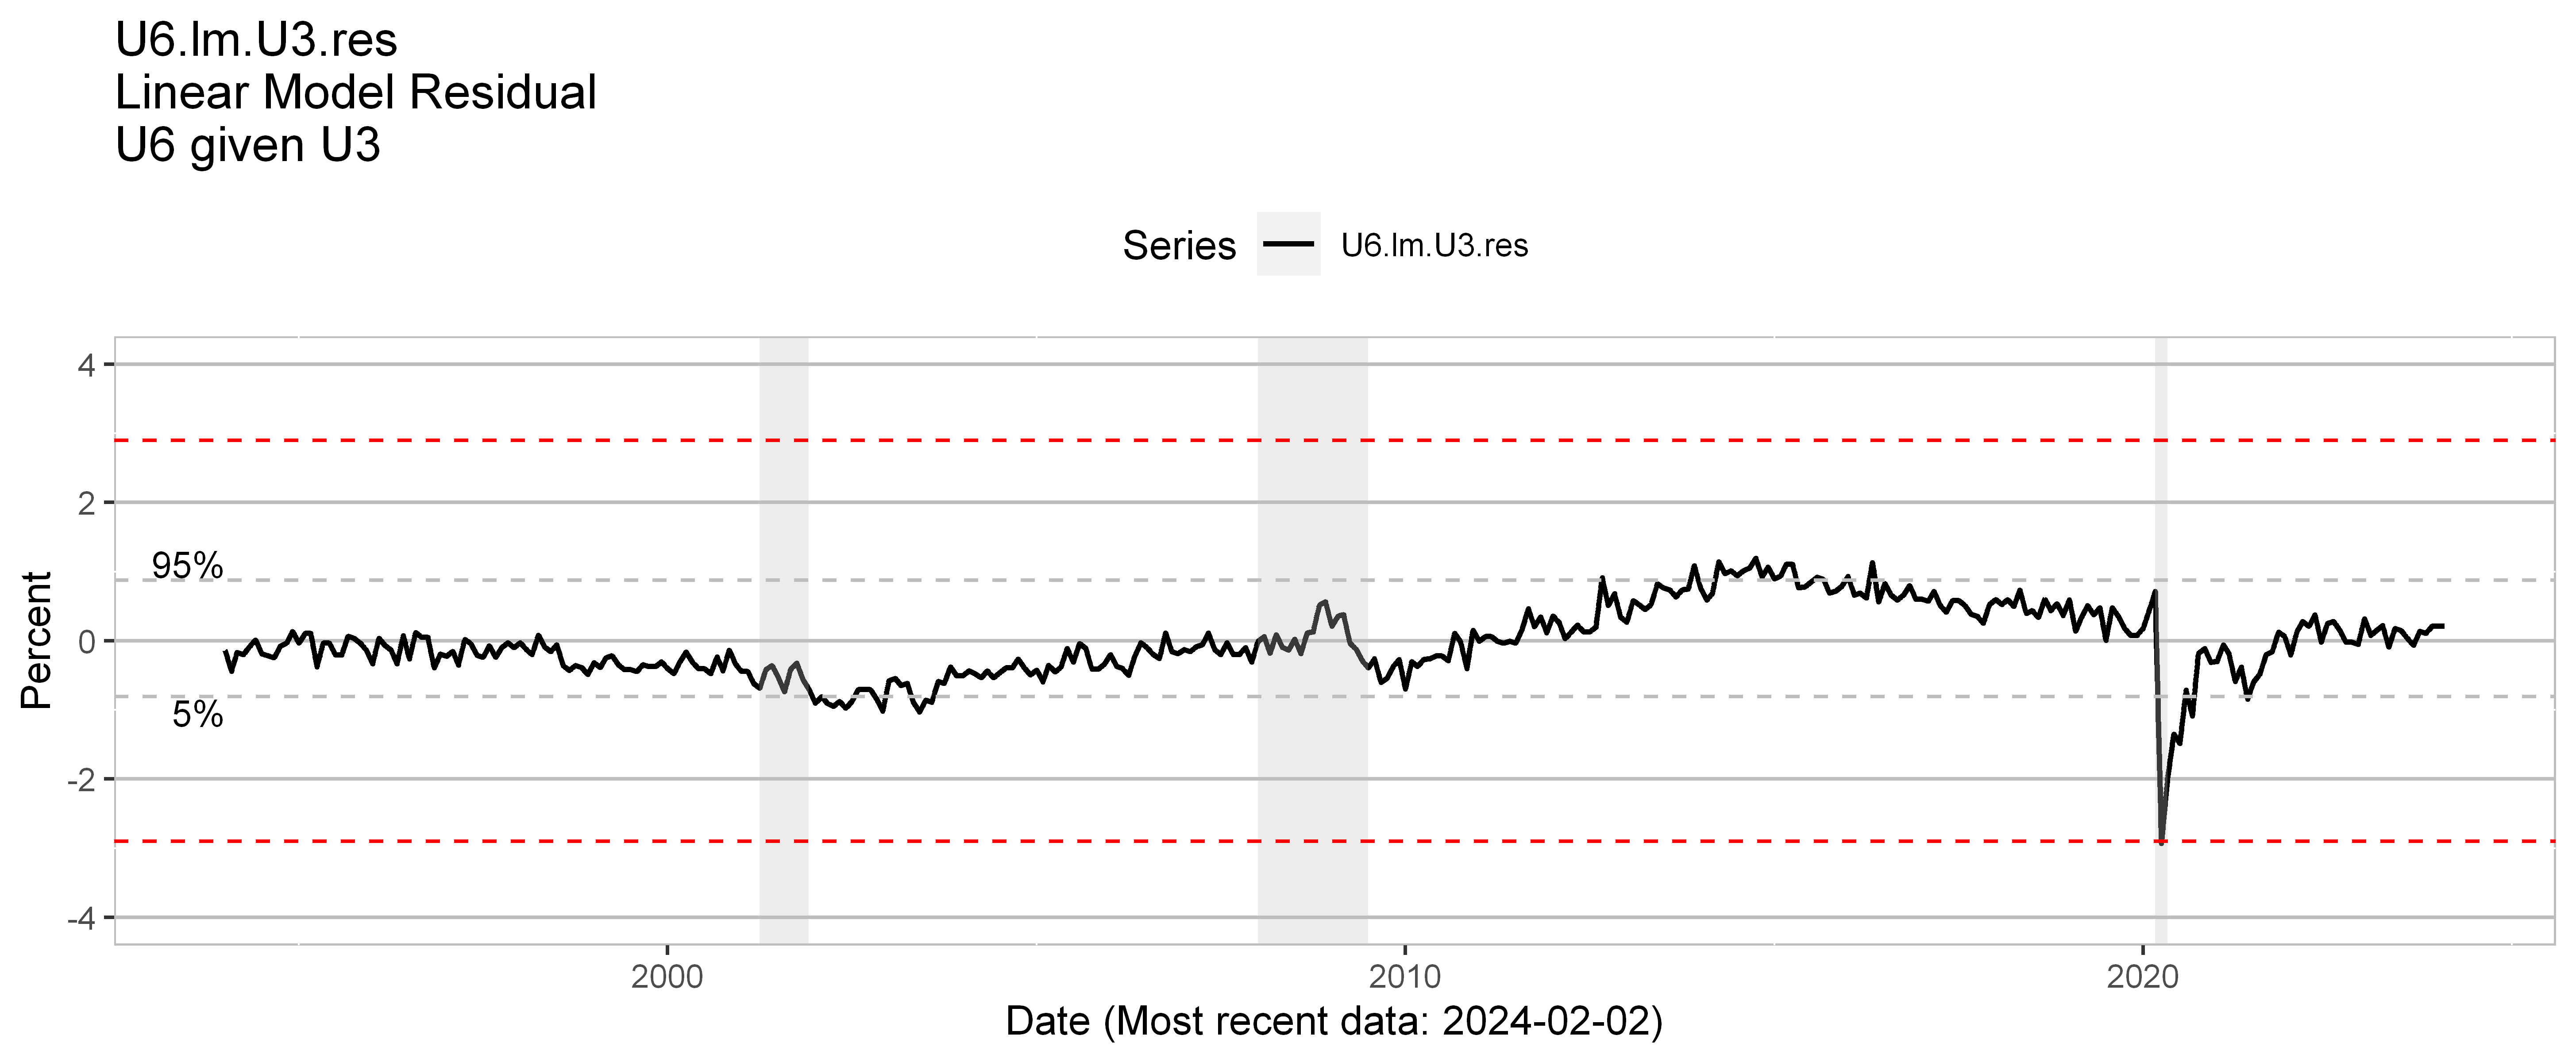

In [34]:
datay <- str.symbol.res
datay.aux <- str.symbol.res.knn
ylim <- c(-4, 4)
myPlot <- plotSingle(
  dfRecession,
  df.data,
  "date",
  datay,
  getPlotTitle(df.symbols, datay),
  "Date",
  getPlotYLabel(df.symbols, datay),
  c(as.Date("1jan1994", "%d%b%Y"), Sys.Date()),
  ylim,
  b.legend = TRUE,
  b.percentile = TRUE,
  b.long.legend = FALSE
)

myPlot <- myPlot + geom_hline(yintercept=(6*sd.fit.u3u6), color = "red", linetype="dashed")
myPlot <- myPlot + geom_hline(yintercept=(-6*sd.fit.u3u6), color = "red", linetype="dashed")

print(myPlot)

### Employment Correlation, U3 (UNRATE) and ICSA by labor force 
Calculate linear model fit across the series. ISCA only records those claiming benefits. Presumably, only a subset of those claiming benefits will prove out to be eligible to receive benefits. It should always be greater than the contining claim numbers.

https://fredblog.stlouisfed.org/2020/04/things-to-know-about-initial-claims-data/

ICSA is normalized by the labor force value estimated from the U.S. population, POPTHM.

The linear fit for this series will not likely be as accurate as the CCSA prediction

In [35]:
# The U6 numbers do not have as much historical data as the U3 so valid data for fit
# begins early. I also exluded the Covid 16 mess of data.
dt.start.prediction <- as.Date("1967-01-07")
dt.end.prediction <- as.Date("2020-01-01")
df.emp.model <-
  df.data[df.data$date >= dt.start.prediction &
            df.data$date <= dt.end.prediction,]

# I break the data into three sets: 50% for training, 25% for testing, and 25% for validation.
set.seed(123456)
in.train <- createDataPartition(y=df.emp.model$ICSA, p = 0.50, list=FALSE)
df.train <- df.emp.model[in.train,]
df.data.rest <- df.emp.model[-in.train,]
in.val <- createDataPartition(y = df.data.rest$ICSA, p = 0.50, list = FALSE)
df.val <- df.data.rest[in.val,]
df.test <- df.data.rest[-in.val,]
rm(df.data.rest)


Perform the fit

In [36]:
# Perform the fit
list.fit.u3icsapaynsa <- train(
  UNRATE ~ ICSA.by.CLF16OV.lm.POPTHM,
  data = df.train,
  method = "lm",
  preProcess = c('center', 'scale')
)

list.fit.knn.u3icsapaynsa <- train(
  UNRATE ~ ICSA.by.CLF16OV.lm.POPTHM,
  data = df.train,
  method = "knn",
  preProcess = c('center', 'scale')
)

rm(df.emp.model)
rm(df.train)
rm(df.val)

Update the symbols table

In [37]:
# Add linear prediction to the dataframe
str.symbol <- "U3.lm.ICSA.by.CLF16OV.lm.POPTHM"
df.data[str.symbol] <-
  predict(list.fit.u3icsapaynsa, newdata = df.data)

# Add the linear model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "Linear Model Prediction\nU3 given ICSA",
      string.label.y = df.symbols[df.symbols$string.symbol=="UNRATE","string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Document the residual as well
str.symbol.res <- "U3.lm.ICSA.by.CLF16OV.lm.POPTHM.res"
df.data[str.symbol.res] <- df.data$UNRATE - df.data[str.symbol]

# Add the U3 linear model prediction residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.res,
      string.source = "Predict Resid.",
      string.description = "Linear Model Residual\nU3 given ICSA",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Add knn prediction to the dataframe
str.symbol.knn <- "U3.knn.ICSA.by.CLF16OV.lm.POPTHM"
df.data[str.symbol.knn] <-
  predict(list.fit.knn.u3icsapaynsa, newdata = df.data)

# Add the nearest neighbors prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.knn,
      string.source = "Predict",
      string.description = "KNN Model Prediction\nU3 given ICSA",
      string.label.y = df.symbols[df.symbols$string.symbol=="UNRATE","string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Document the residual as well
str.symbol.res.knn <- "U3.knn.ICSA.by.CLF16OV.lm.POPTHM.res"
df.data[str.symbol.res.knn] <- df.data$UNRATE - df.data[str.symbol.knn]

# Add the U3 nearest neighbor prediction residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.res.knn,
      string.source = "Predict Resid.",
      string.description = "KNN Model Residual\nU3 given ICSA",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol.knn,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


Look at how the fits performed on the test data partition

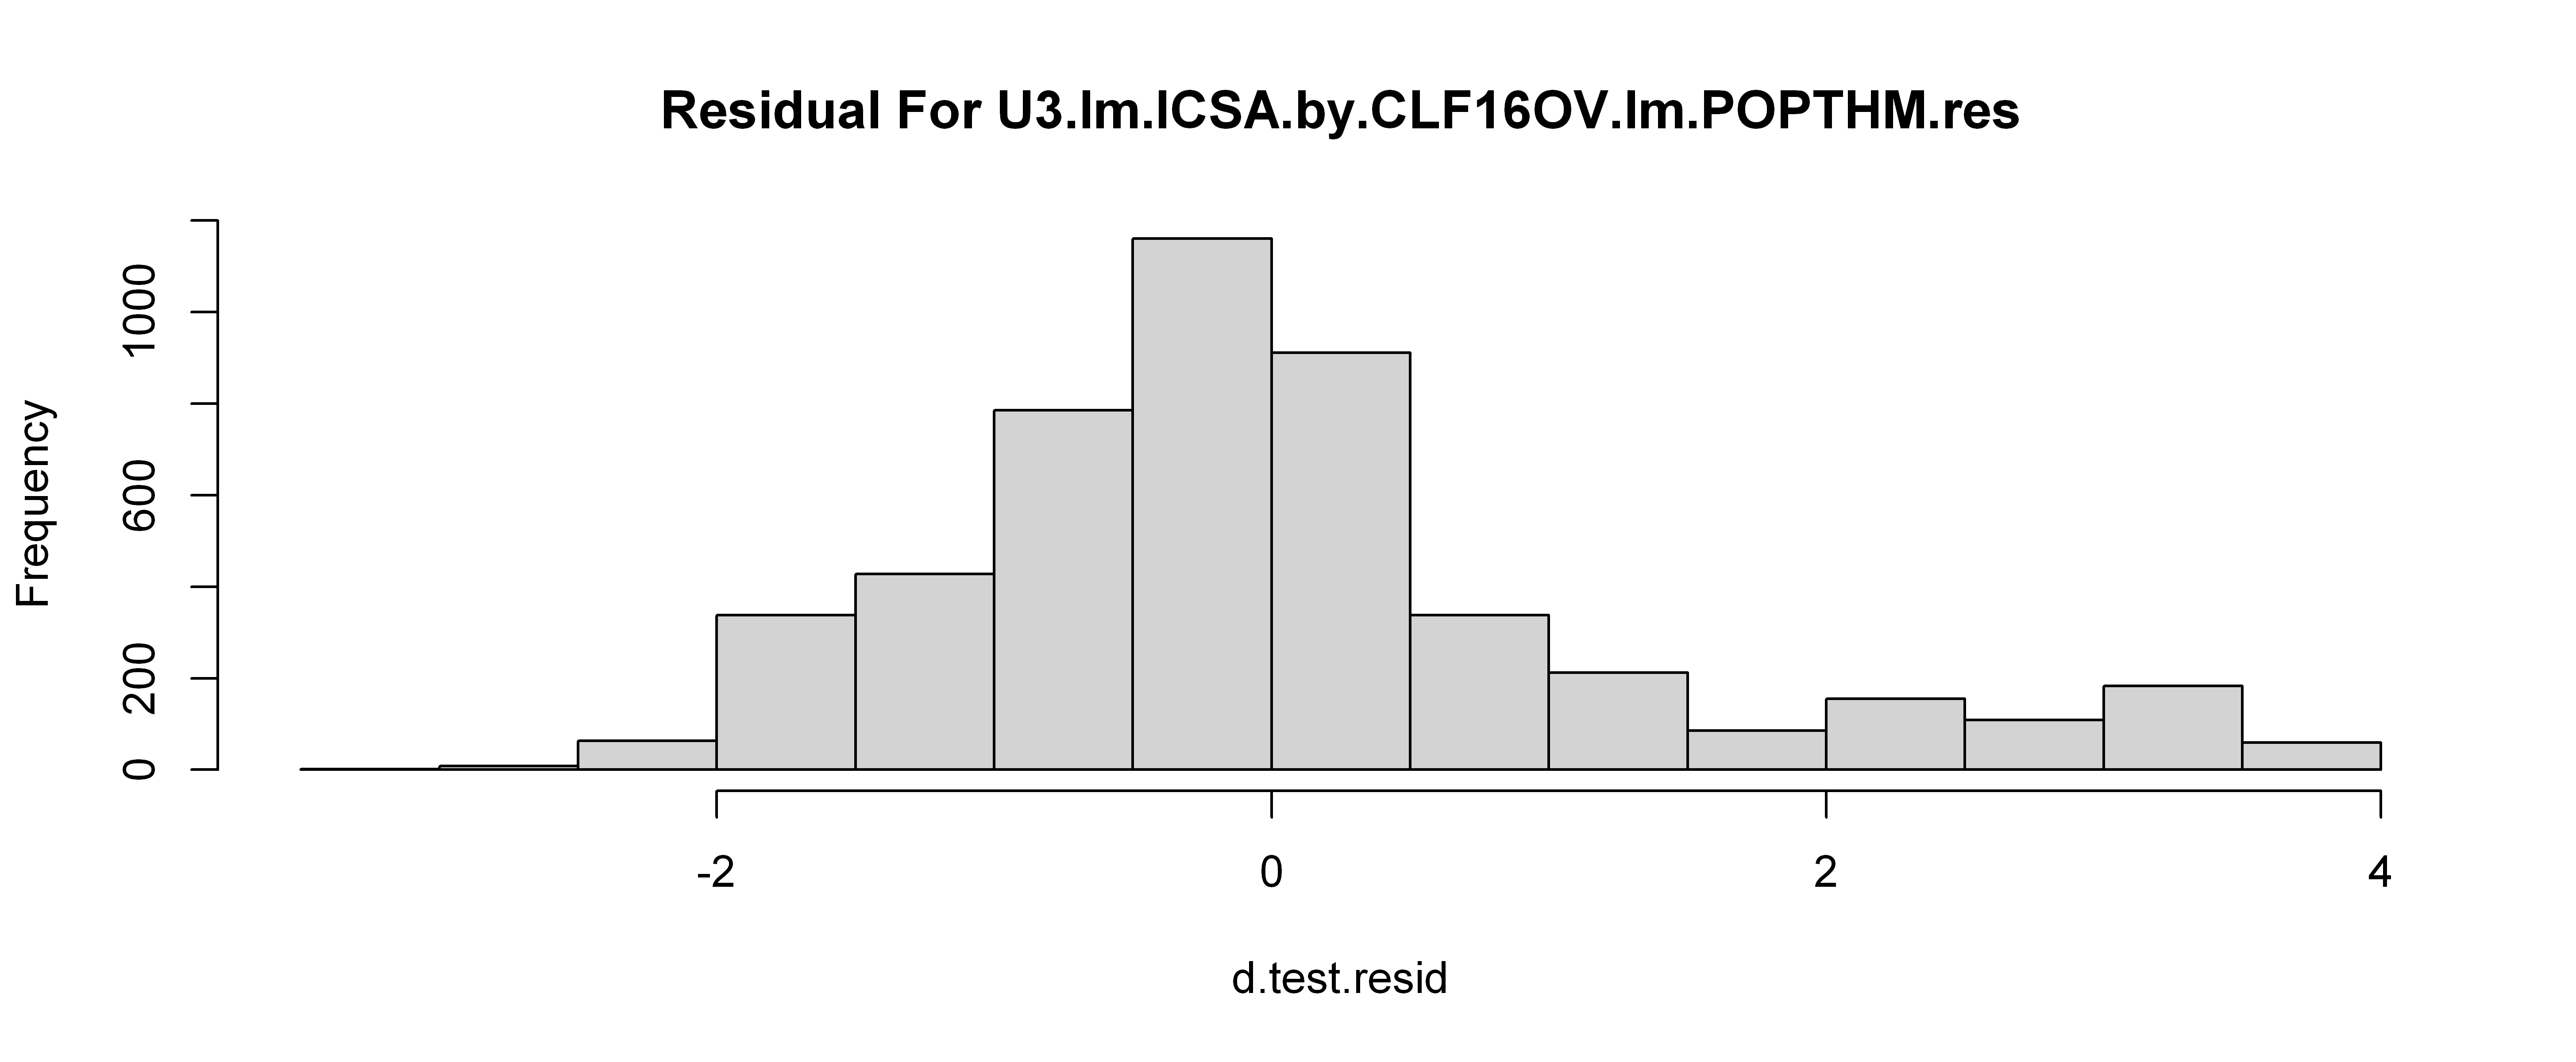

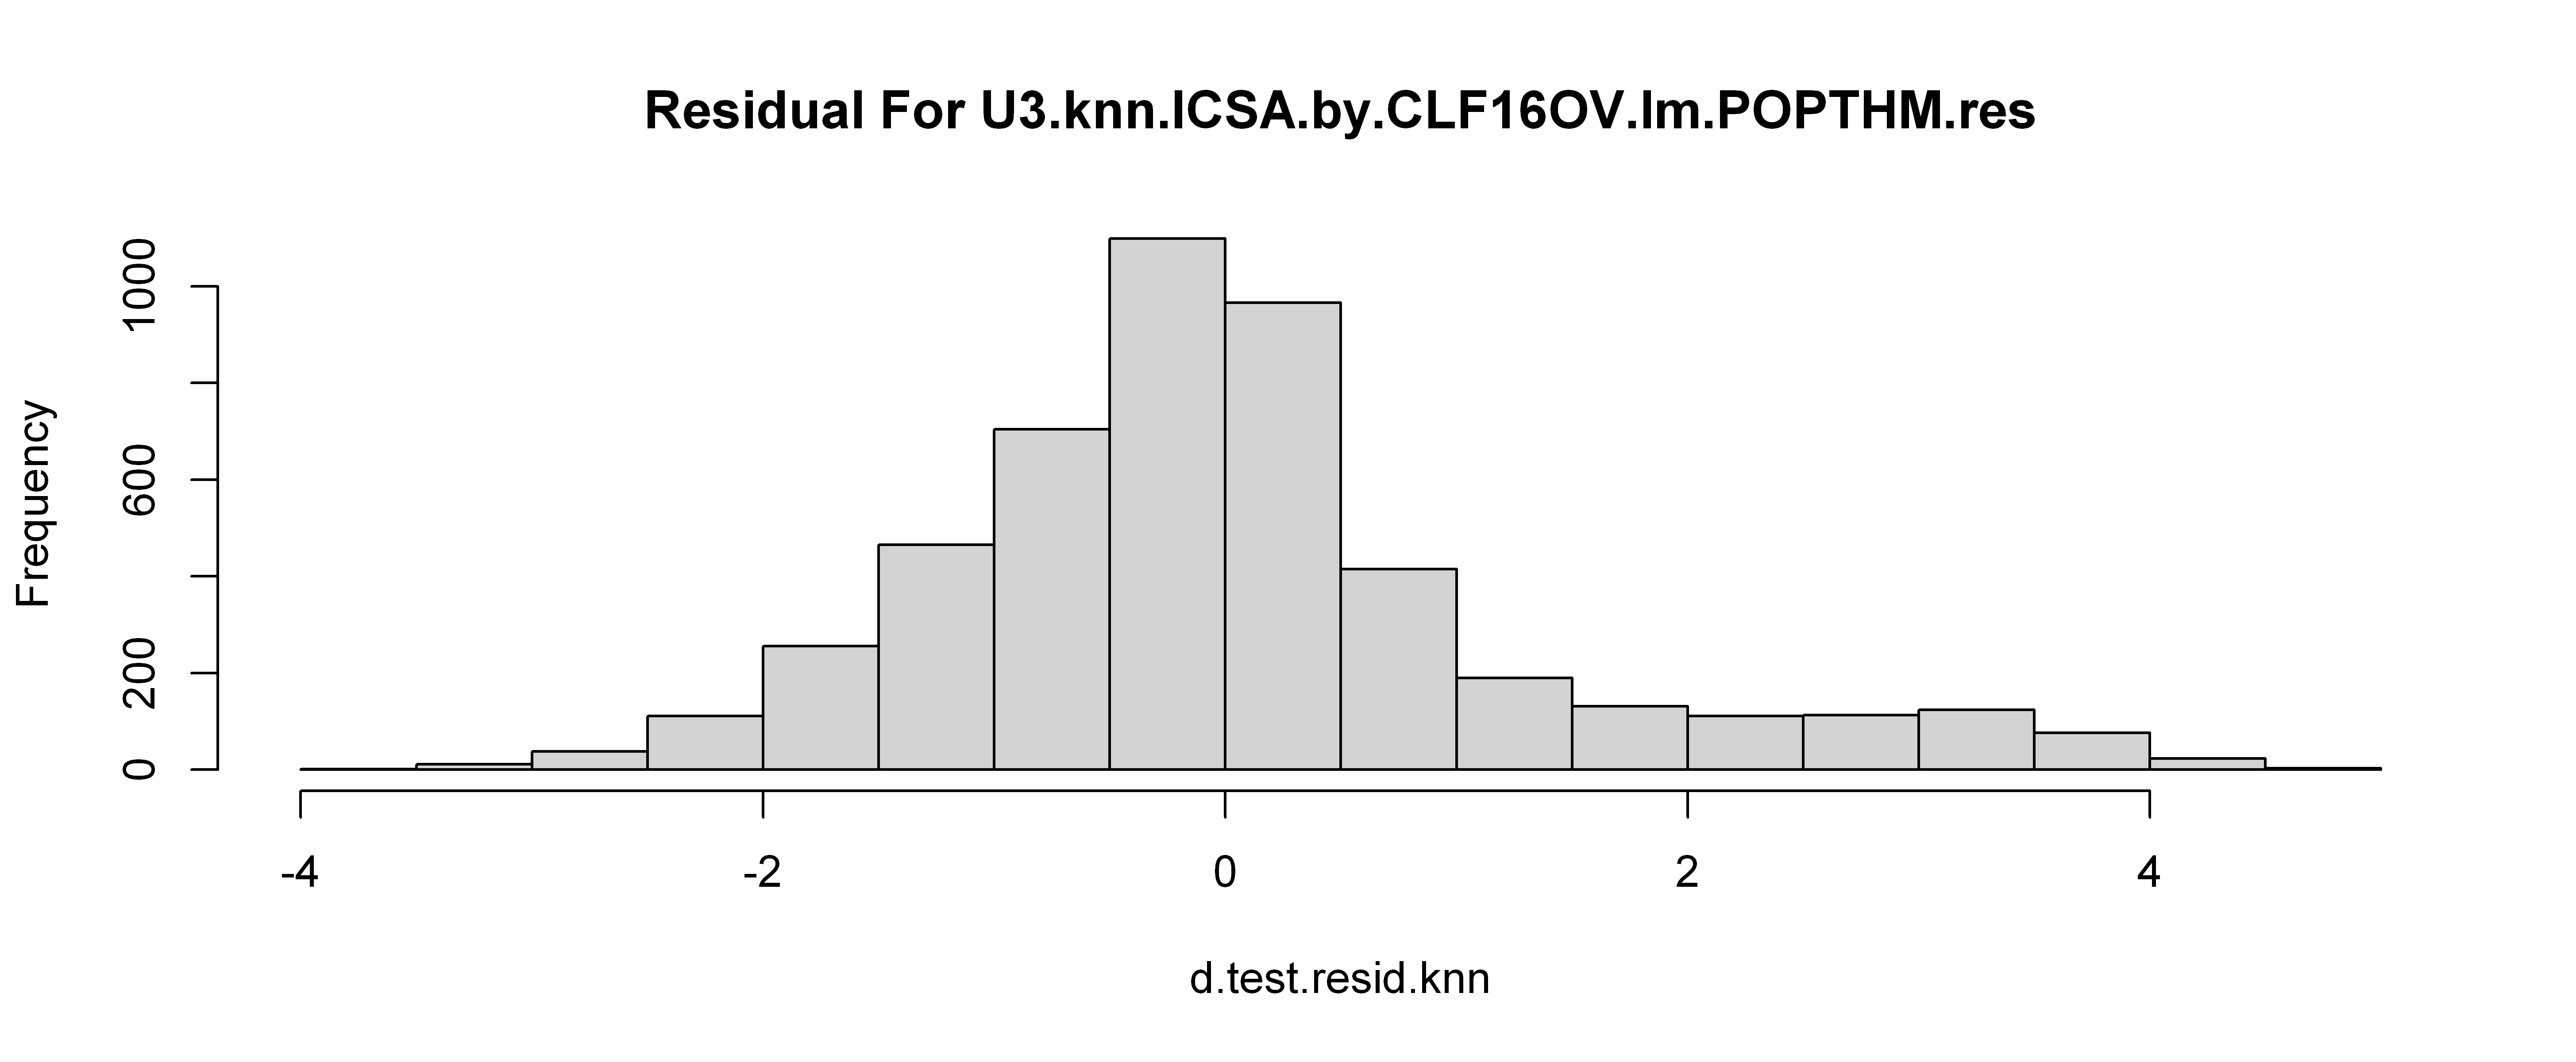

In [38]:
d.test.resid = (df.test$UNRATE - predict(list.fit.u3icsapaynsa, newdata = df.test))
hist(d.test.resid, main=paste("Residual For", str.symbol.res, sep=" "))
sd.fit.u3icsapaynsa = sd(d.test.resid)


d.test.resid.knn = (df.test$UNRATE - predict(list.fit.knn.u3icsapaynsa, newdata = df.test))
hist(d.test.resid.knn, main=paste("Residual For", str.symbol.res.knn, sep=" "))
sd.fit.knn.u3icsapaynsa = sd(d.test.resid.knn)
rm(list.fit.knn.u3icsapaynsa)


Plot the measured U3 (UNRATE) to U3 predicted by a linear fit to ICSA.

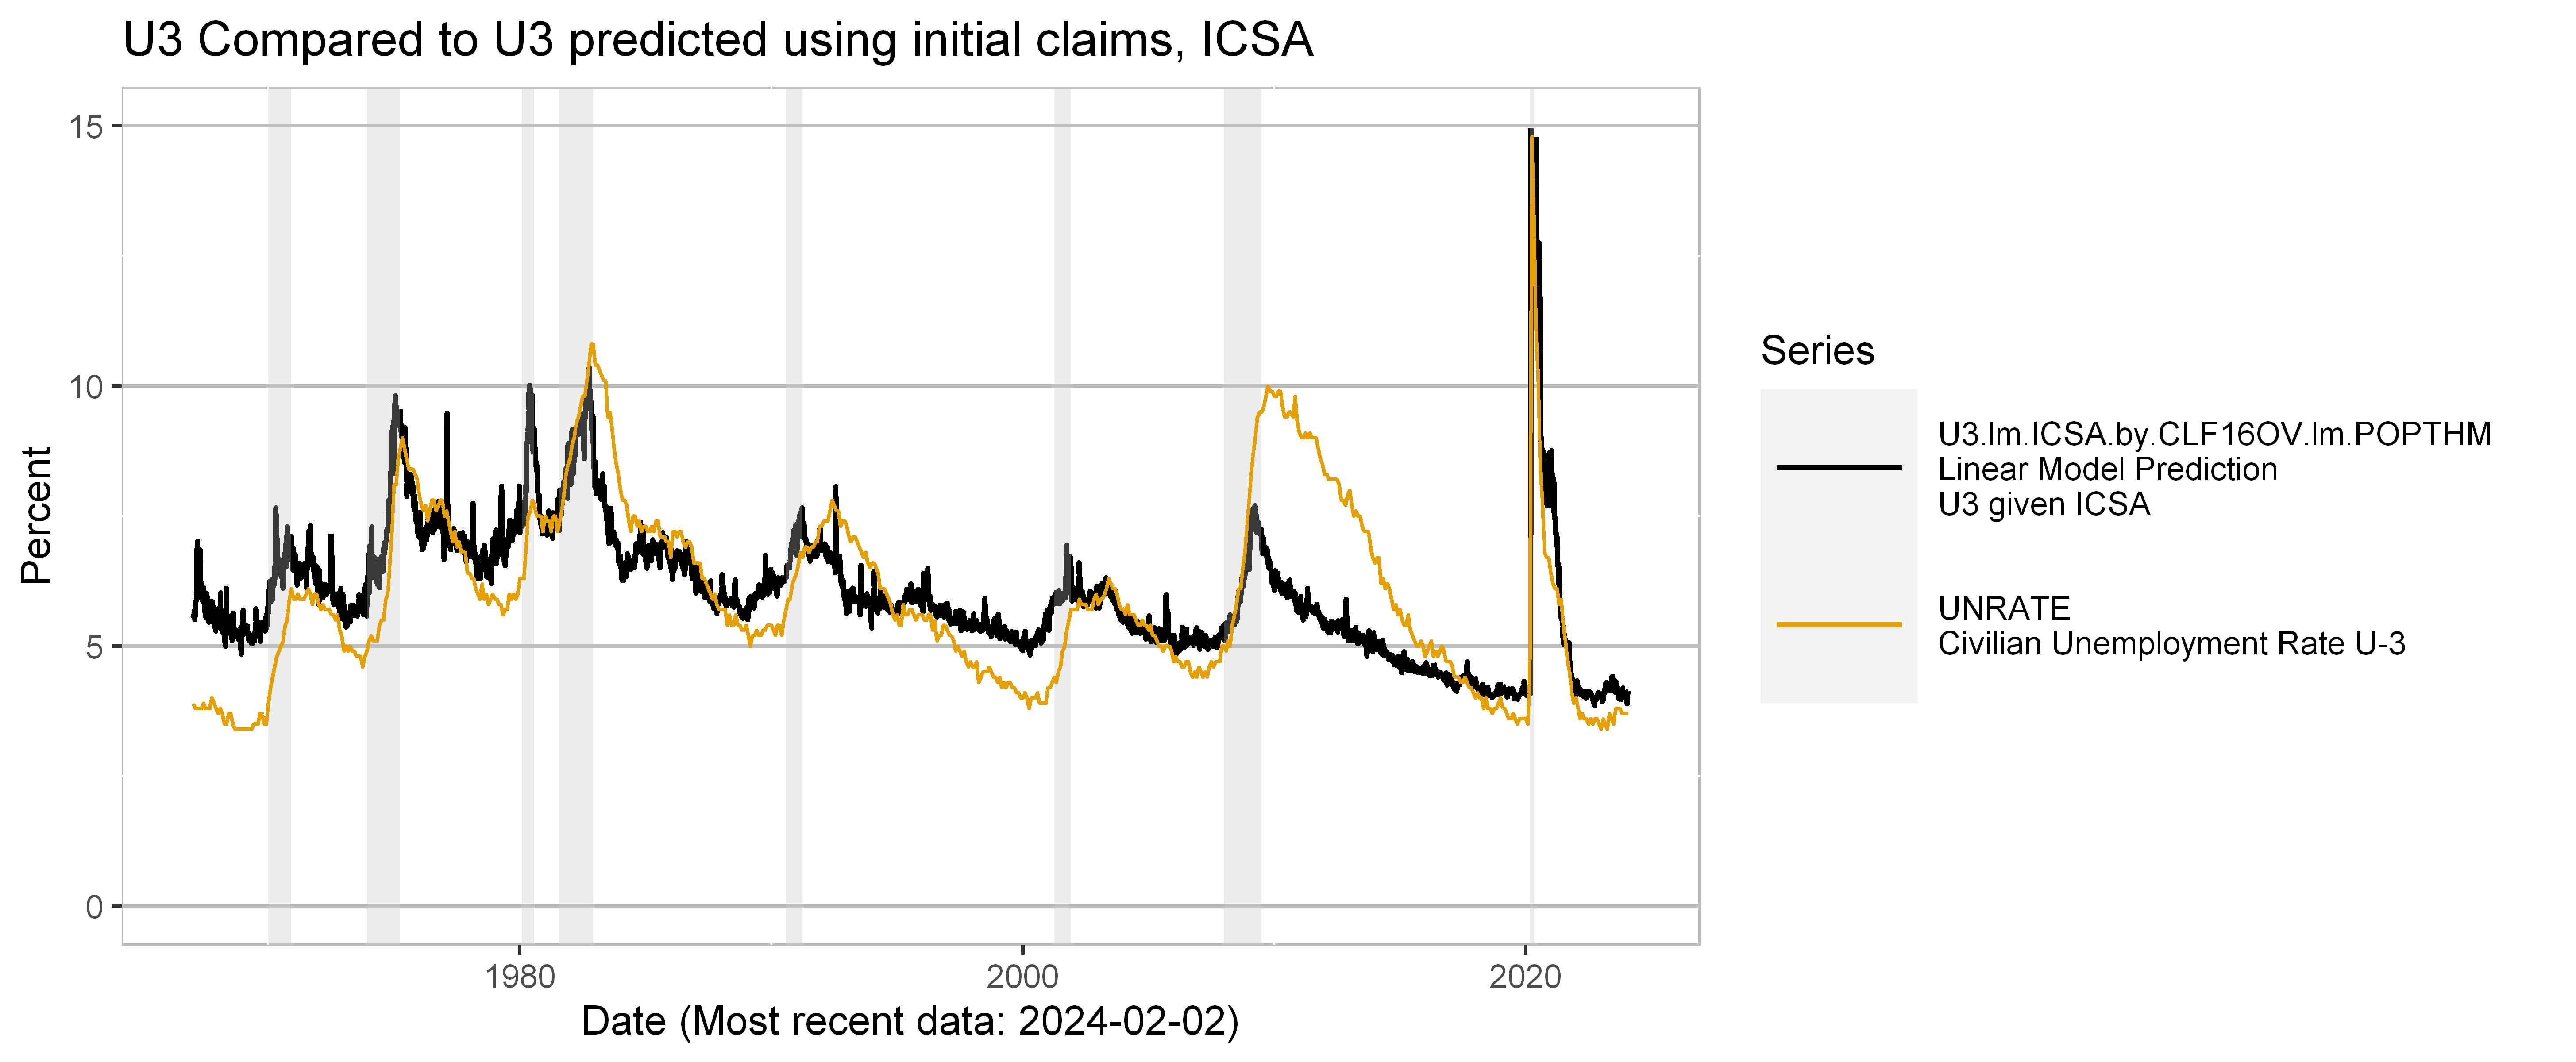

In [39]:
datay <- "U3.lm.ICSA.by.CLF16OV.lm.POPTHM"
datay.aux <- "UNRATE"
# datay.aux.1 <- "UNRATE"
ylim <- c(0, 15)
dt.end <- Sys.Date()
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "U3 Compared to U3 predicted using initial claims, ICSA",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(index(ICSA[1]), dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

# myPlot + geom_line(
#   data = df.data,
#   aes_string(
#     x = "date",
#     y = datay.aux.1,
#     colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
#   ),
#   na.rm = TRUE
# )

print(myPlot)

Take a closer look, given the interest around latest U3 numbers

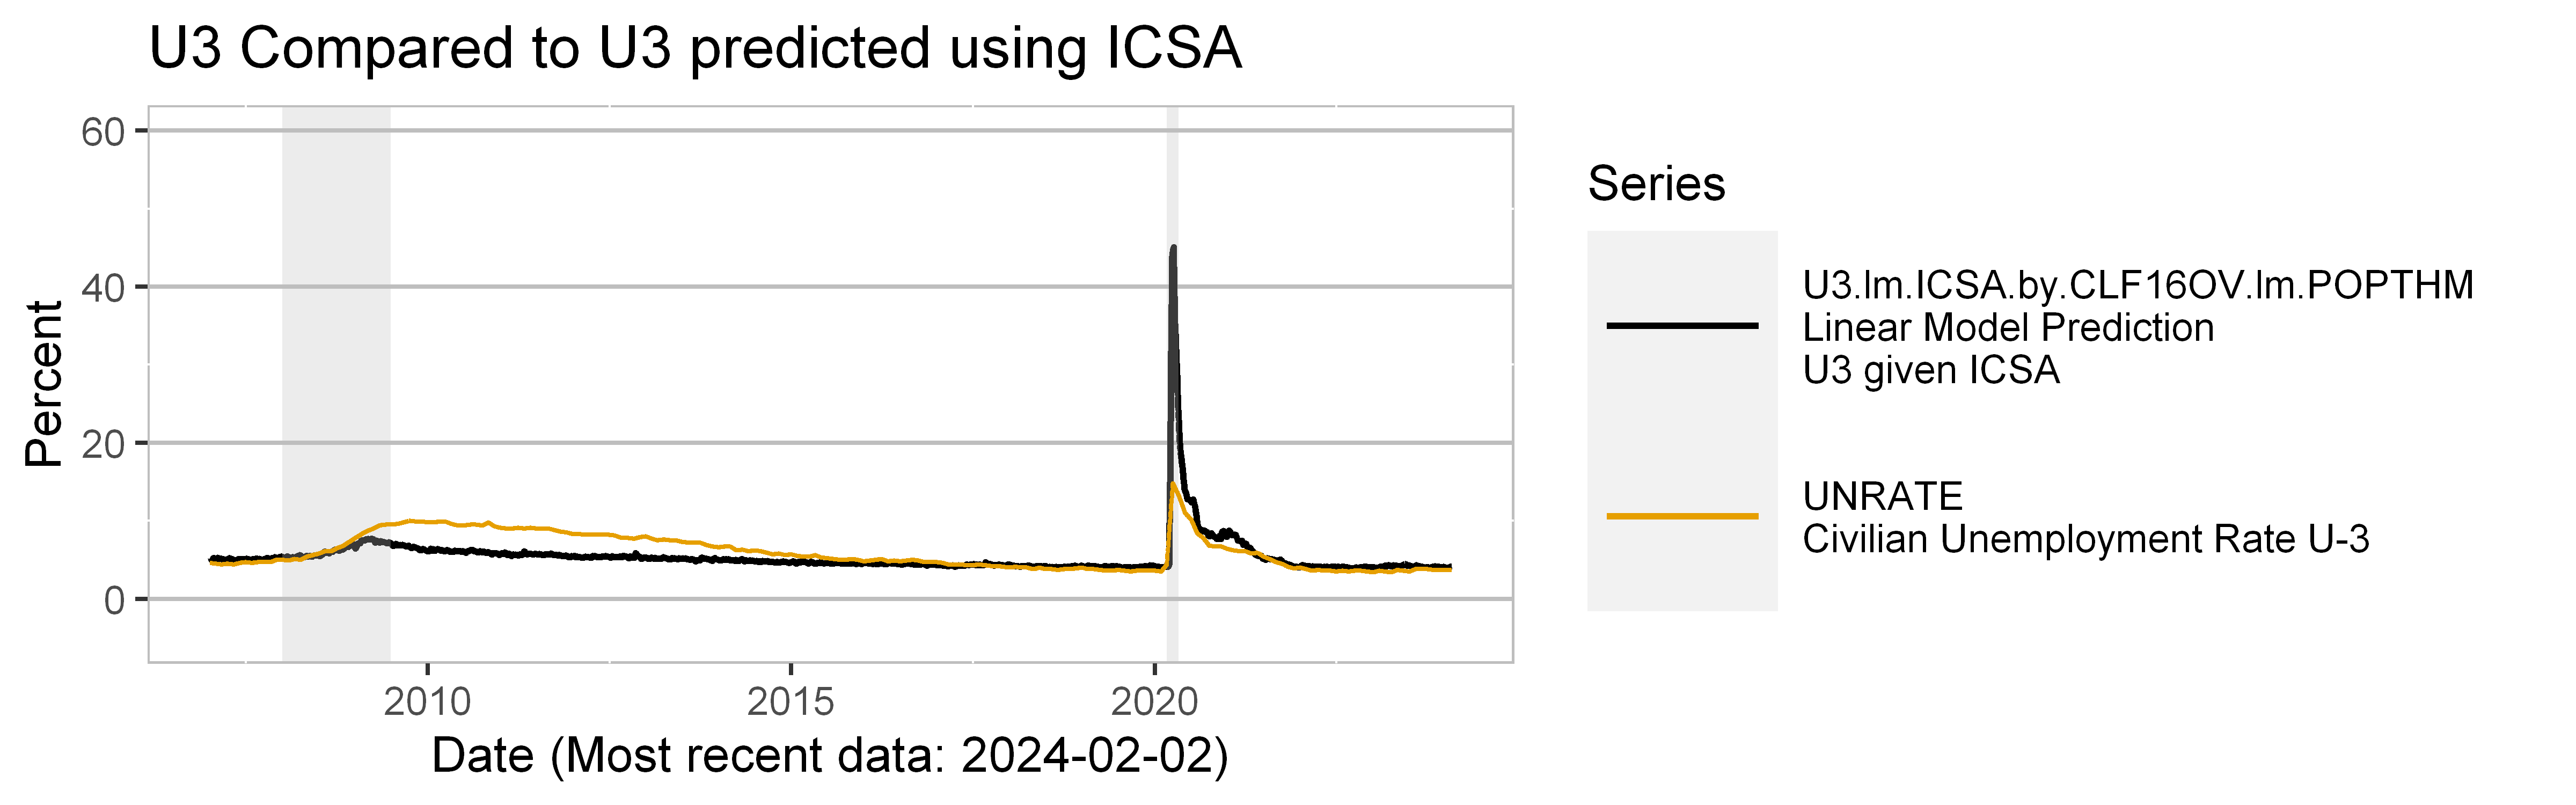

In [40]:
options(repr.plot.width = 8, repr.plot.height = 2.5, repr.plot.res = 600)
datay <- "U3.lm.ICSA.by.CLF16OV.lm.POPTHM"
datay.aux <- "UNRATE"
datay.aux.1 <- "UNRATE"
ylim <- c(-5, 60)
dt.end <- Sys.Date()
dt.start <- as.Date("2007-01-01")
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "U3 Compared to U3 predicted using ICSA",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

# myPlot <- myPlot + geom_line(
#   data = df.data,
#   aes_string(
#     x = "date",
#     y = datay.aux.1,
#     colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
#   ),
#   na.rm = TRUE
# )

print(myPlot)

Plot the residual for the U3 to predict U3 from ICSA.

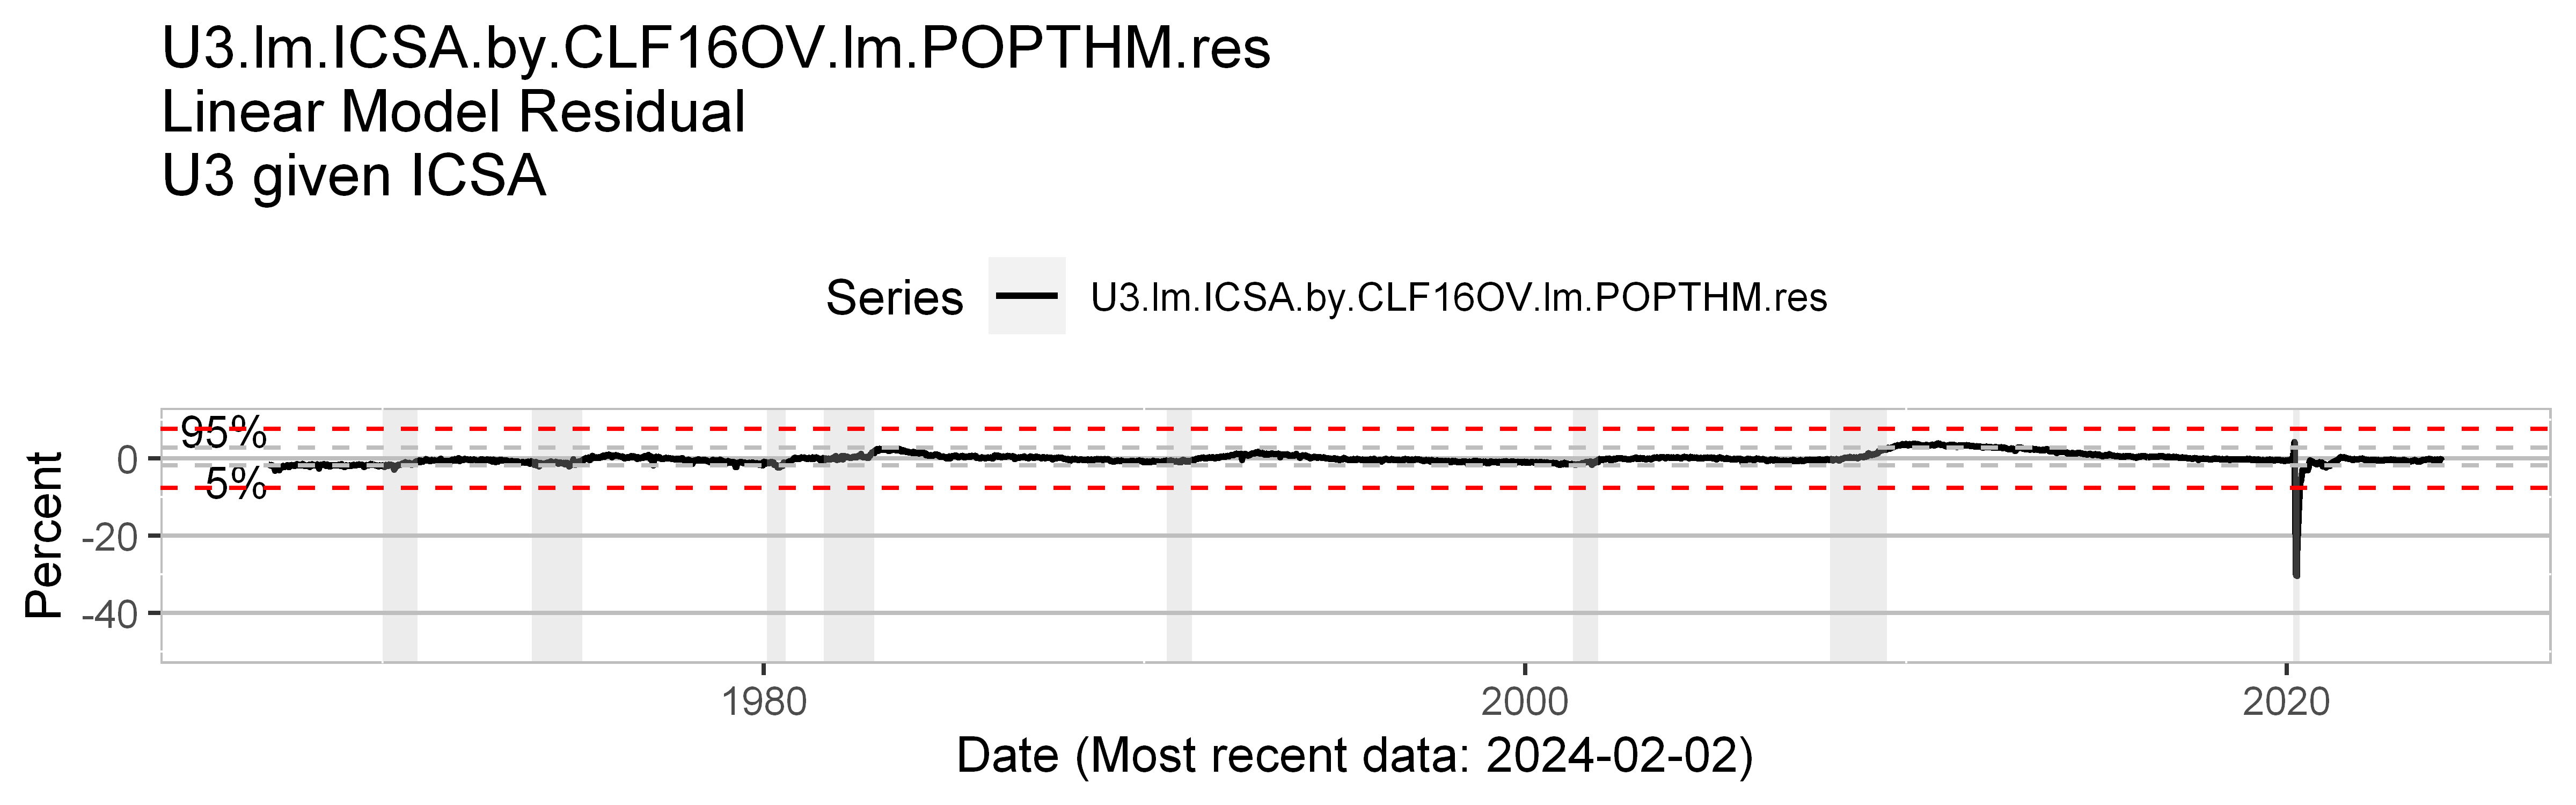

In [41]:
datay <- str.symbol.res
ylim <- c(-50, 10)
myPlot <- plotSingle(
  dfRecession,
  df.data,
  "date",
  datay,
  getPlotTitle(df.symbols, datay),
  "Date",
  getPlotYLabel(df.symbols, datay),
  c(dt.start.prediction, Sys.Date()),
  ylim,
  b.legend = TRUE,
  b.percentile = TRUE,
  b.long.legend = FALSE
)


myPlot <- myPlot + geom_hline(yintercept=(6*sd.fit.u3icsapaynsa), color = "red", linetype="dashed")
myPlot <- myPlot + geom_hline(yintercept=(-6*sd.fit.u3icsapaynsa), color = "red", linetype="dashed")

print(myPlot)

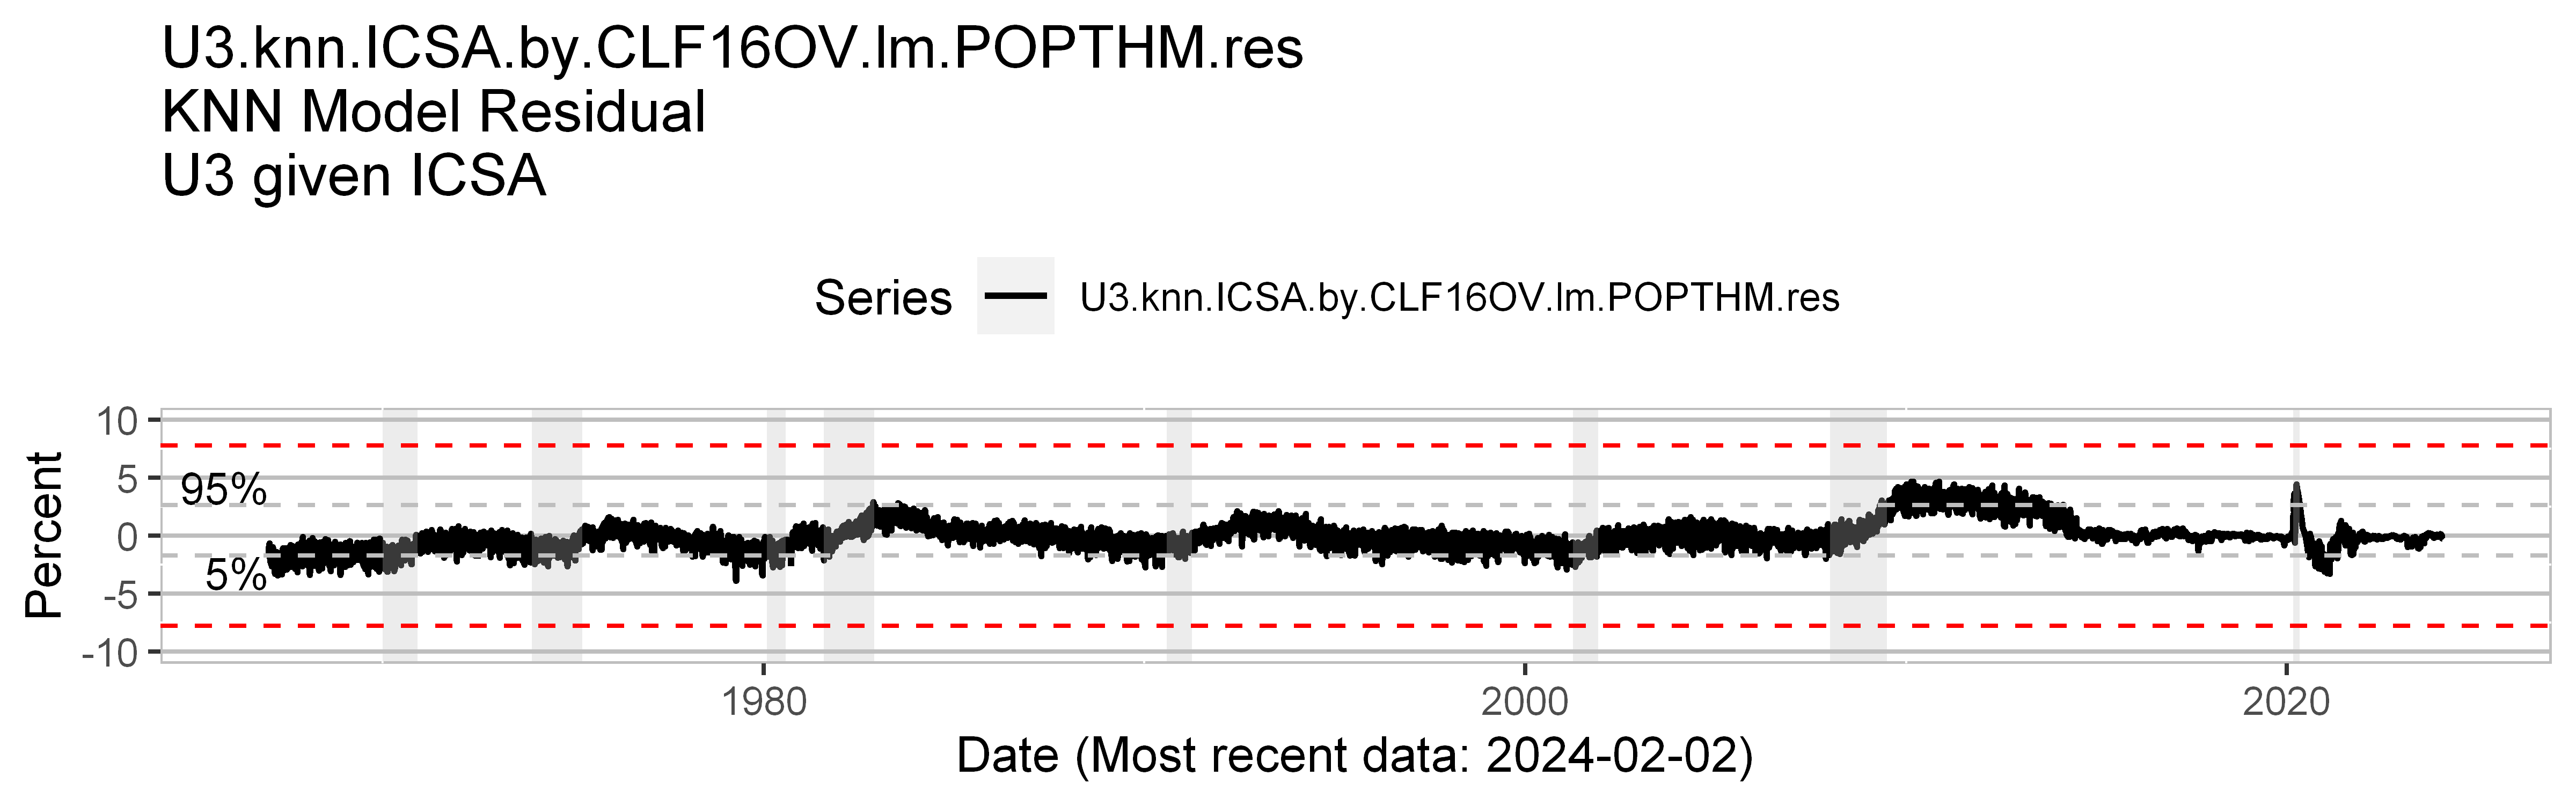

In [42]:
datay <- "U3.knn.ICSA.by.CLF16OV.lm.POPTHM.res"
ylim <- c(-10, 10)
myPlot <- plotSingle(
  dfRecession,
  df.data,
  "date",
  datay,
  getPlotTitle(df.symbols, datay),
  "Date",
  getPlotYLabel(df.symbols, datay),
  c(dt.start.prediction, Sys.Date()),
  ylim,
  b.legend = TRUE,
  b.percentile = TRUE,
  b.long.legend = FALSE
)


myPlot <- myPlot + geom_hline(yintercept=(6*sd.fit.knn.u3icsapaynsa), color = "red", linetype="dashed")
myPlot <- myPlot + geom_hline(yintercept=(-6*sd.fit.knn.u3icsapaynsa), color = "red", linetype="dashed")

print(myPlot)


### Employment Correlation, U3 (UNRATE) and CCSA 
Calculate linear model fit across the series. CCSA only records those who have experienced a week of unemployment and the filed a continuing claim.

In [43]:
# The U6 numbers do not have as much historical data as the U3 so valid data for fit
# begins early. I also exluded the Covid 16 mess of data.
dt.start.prediction <- as.Date("1967-01-07")
dt.end.prediction <- as.Date("2020-01-01")
df.emp.model <-
  df.data[df.data$date >= dt.start.prediction &
            df.data$date <= dt.end.prediction,]

# I break the data into three sets: 50% for training, 25% for testing, and 25% for validation.
set.seed(123456)
in.train <- createDataPartition(y=df.emp.model$ICSA, p = 0.50, list=FALSE)
df.train <- df.emp.model[in.train,]
df.data.rest <- df.emp.model[-in.train,]
in.val <- createDataPartition(y = df.data.rest$ICSA, p = 0.50, list = FALSE)
df.val <- df.data.rest[in.val,]
df.test <- df.data.rest[-in.val,]
rm(df.data.rest)

In [44]:
rm(df.emp.model)
gc()

# Perform the fit
list.fit.u3ccsa <- train(
  UNRATE ~ CCSA.by.CLF16OV.lm.POPTHM,
  data = df.train,
  method = "lm",
  preProcess = c('center', 'scale')
)

list.fit.knn.u3ccsa <- train(
  UNRATE ~ CCSA.by.CLF16OV.lm.POPTHM,
  data = df.train,
  method = "knn",
  preProcess = c('center', 'scale')
)

rm(df.train)
rm(df.val)


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2887334,154.3,4615075,246.5,4615075,246.5
Vcells,832559752,6352.0,1518519089,11585.4,1320571099,10075.2


Update the symbols table

In [45]:

# Add linear model prediction to the dataframe
str.symbol <- "U3.lm.CCSA.by.CLF16OV.lm.POPTHM"
df.data[str.symbol] <-
  predict(list.fit.u3ccsa, newdata = df.data)

# Add the linear model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "\nLinear Model Prediction\nU3 given CCSA",
      string.label.y = df.symbols[df.symbols$string.symbol=="UNRATE","string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Document the residual as well
str.symbol.res <- "U3.lm.CCSA.by.CLF16OV.lm.POPTHM.res"
df.data[str.symbol.res] <- df.data$UNRATE - df.data[str.symbol]

# Add the U3 linear model model prediction residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.res,
      string.source = "Predict Resid.",
      string.description = "\nLinear Model Residual\nU3 given CCSA",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Add KNN model prediction to the dataframe
str.symbol <- "U3.knn.CCSA.by.CLF16OV.lm.POPTHM"
df.data[str.symbol] <-
  predict(list.fit.knn.u3ccsa, newdata = df.data)

# Add the knn model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "KNN Prediction\nU3 given CCSA",
      string.label.y = df.symbols[df.symbols$string.symbol=="UNRATE","string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Document the residual as well
str.symbol.res.knn <- "U3.knn.CCSA.by.CLF16OV.lm.POPTHM.res"
df.data[str.symbol.res.knn] <- df.data$UNRATE - df.data[str.symbol]

# Add the U3 knn model prediction residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.res.knn,
      string.source = "Predict Resid.",
      string.description = "KNN Residual\nU3 given CCSA",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

Look at how the fits performed on the test data partition

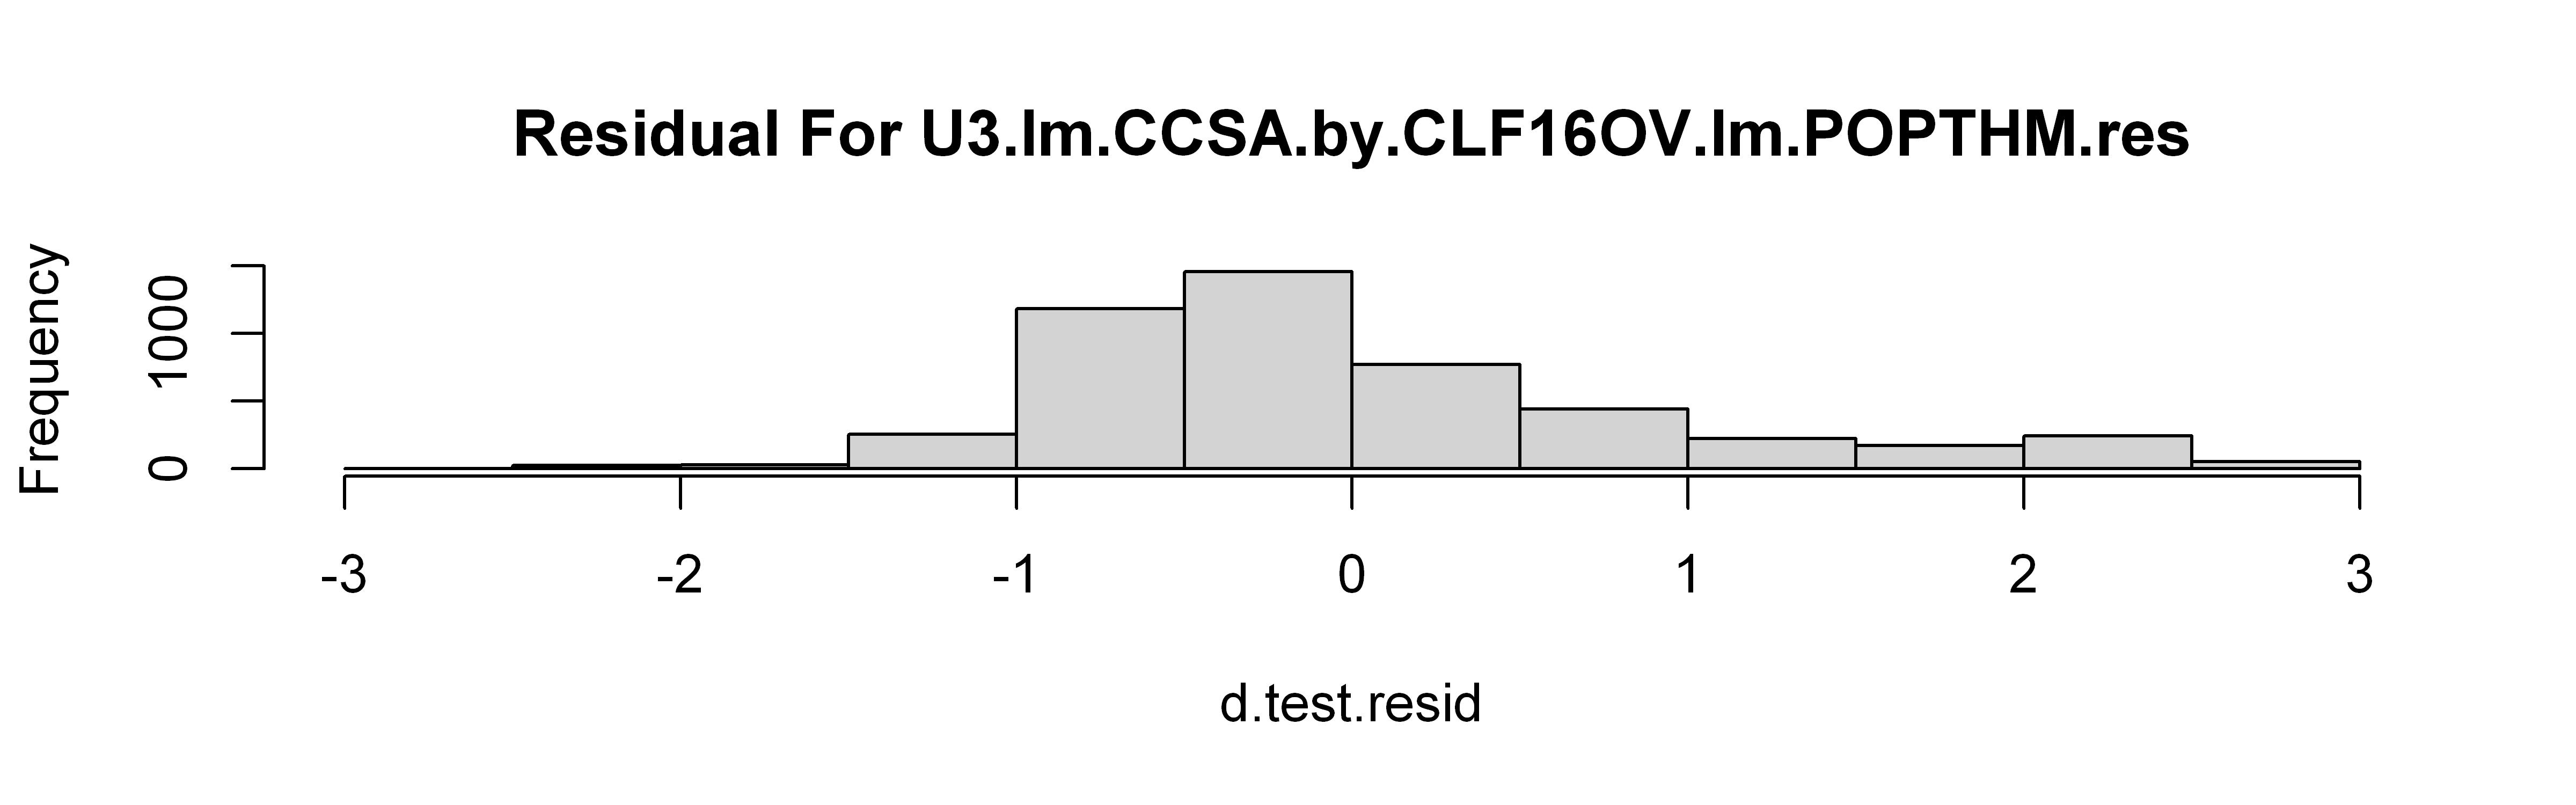

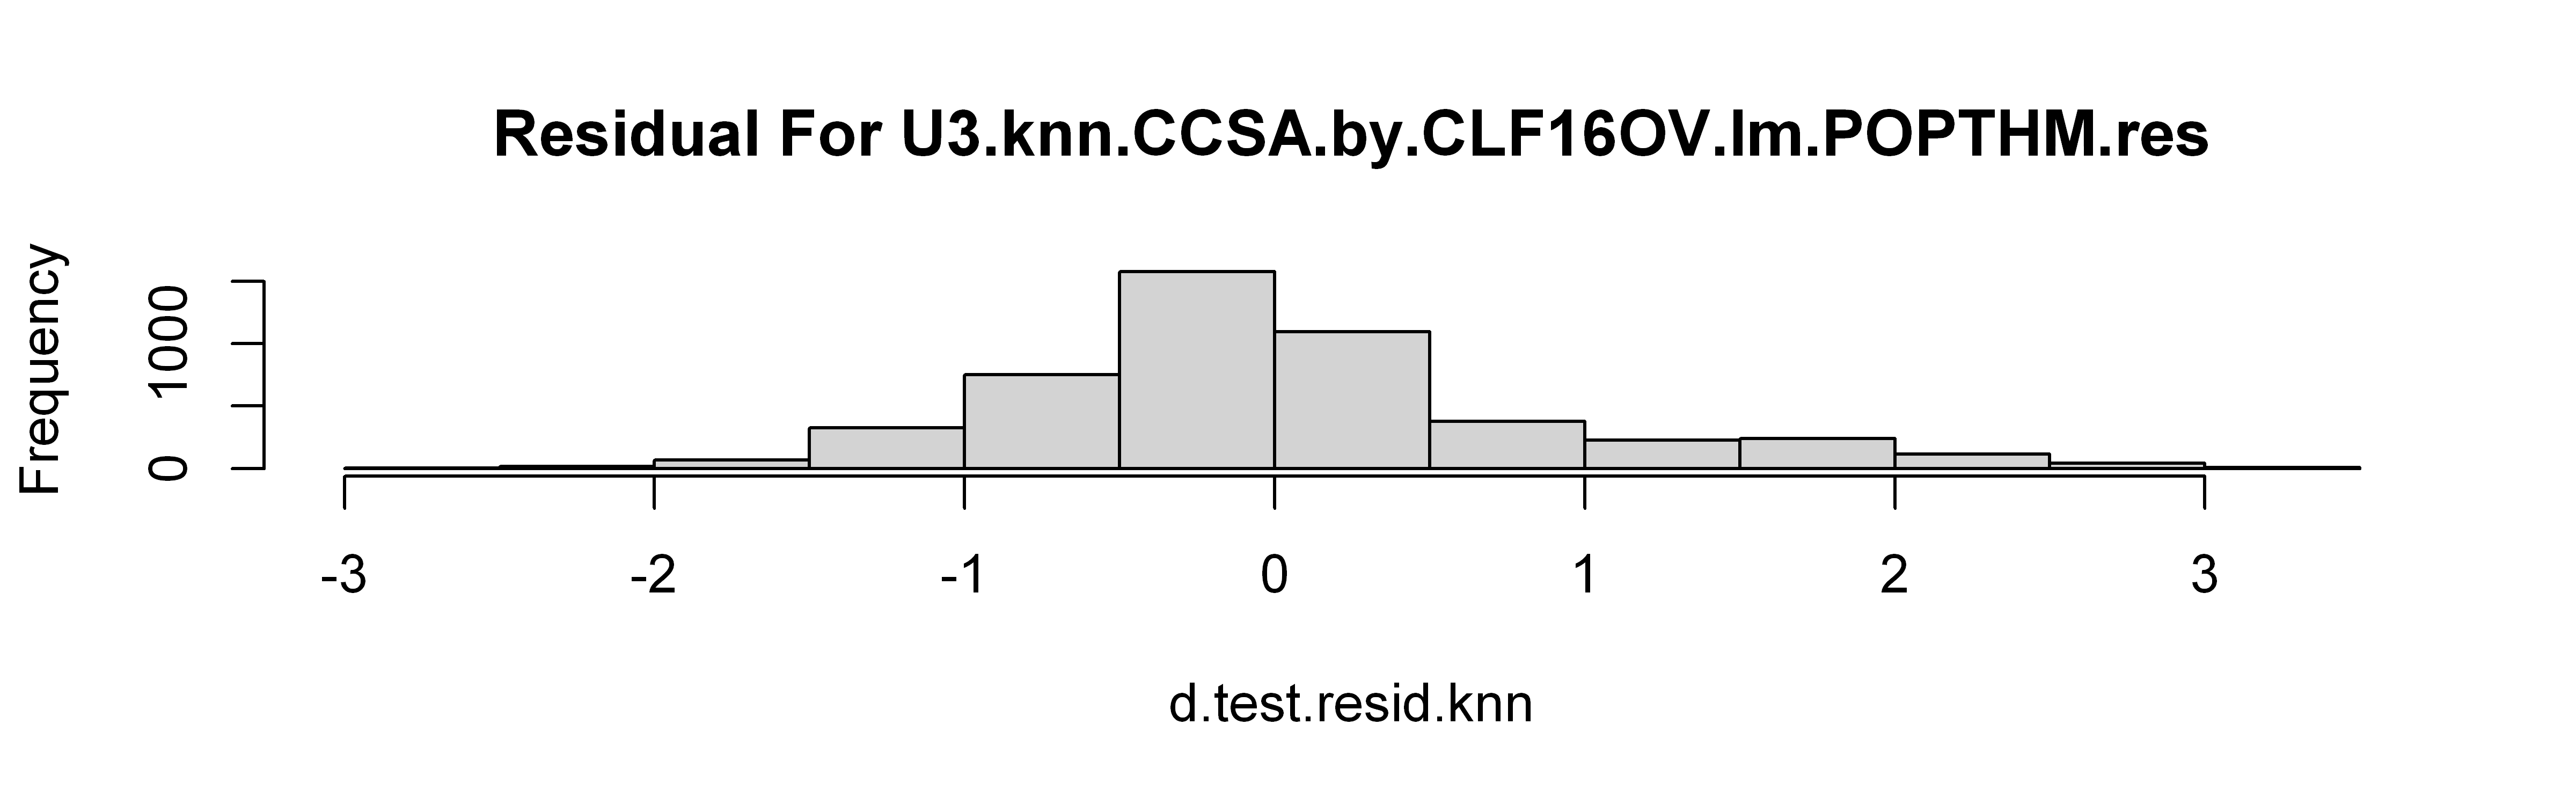

In [46]:
d.test.resid = (df.test$UNRATE - predict(list.fit.u3ccsa, newdata = df.test))
hist(d.test.resid, main=paste("Residual For", str.symbol.res, sep=" "))
sd.fit.u3ccsa = sd(d.test.resid)


d.test.resid.knn = (df.test$UNRATE - predict(list.fit.knn.u3ccsa, newdata = df.test))
hist(d.test.resid.knn, main=paste("Residual For", str.symbol.res.knn, sep=" "))
sd.fit.knn.u3ccsa = sd(d.test.resid.knn)
rm(list.fit.knn.u3ccsa)

Plot the measured U3 (UNRATE) to U3 predicted by a linear fit to CCSA.

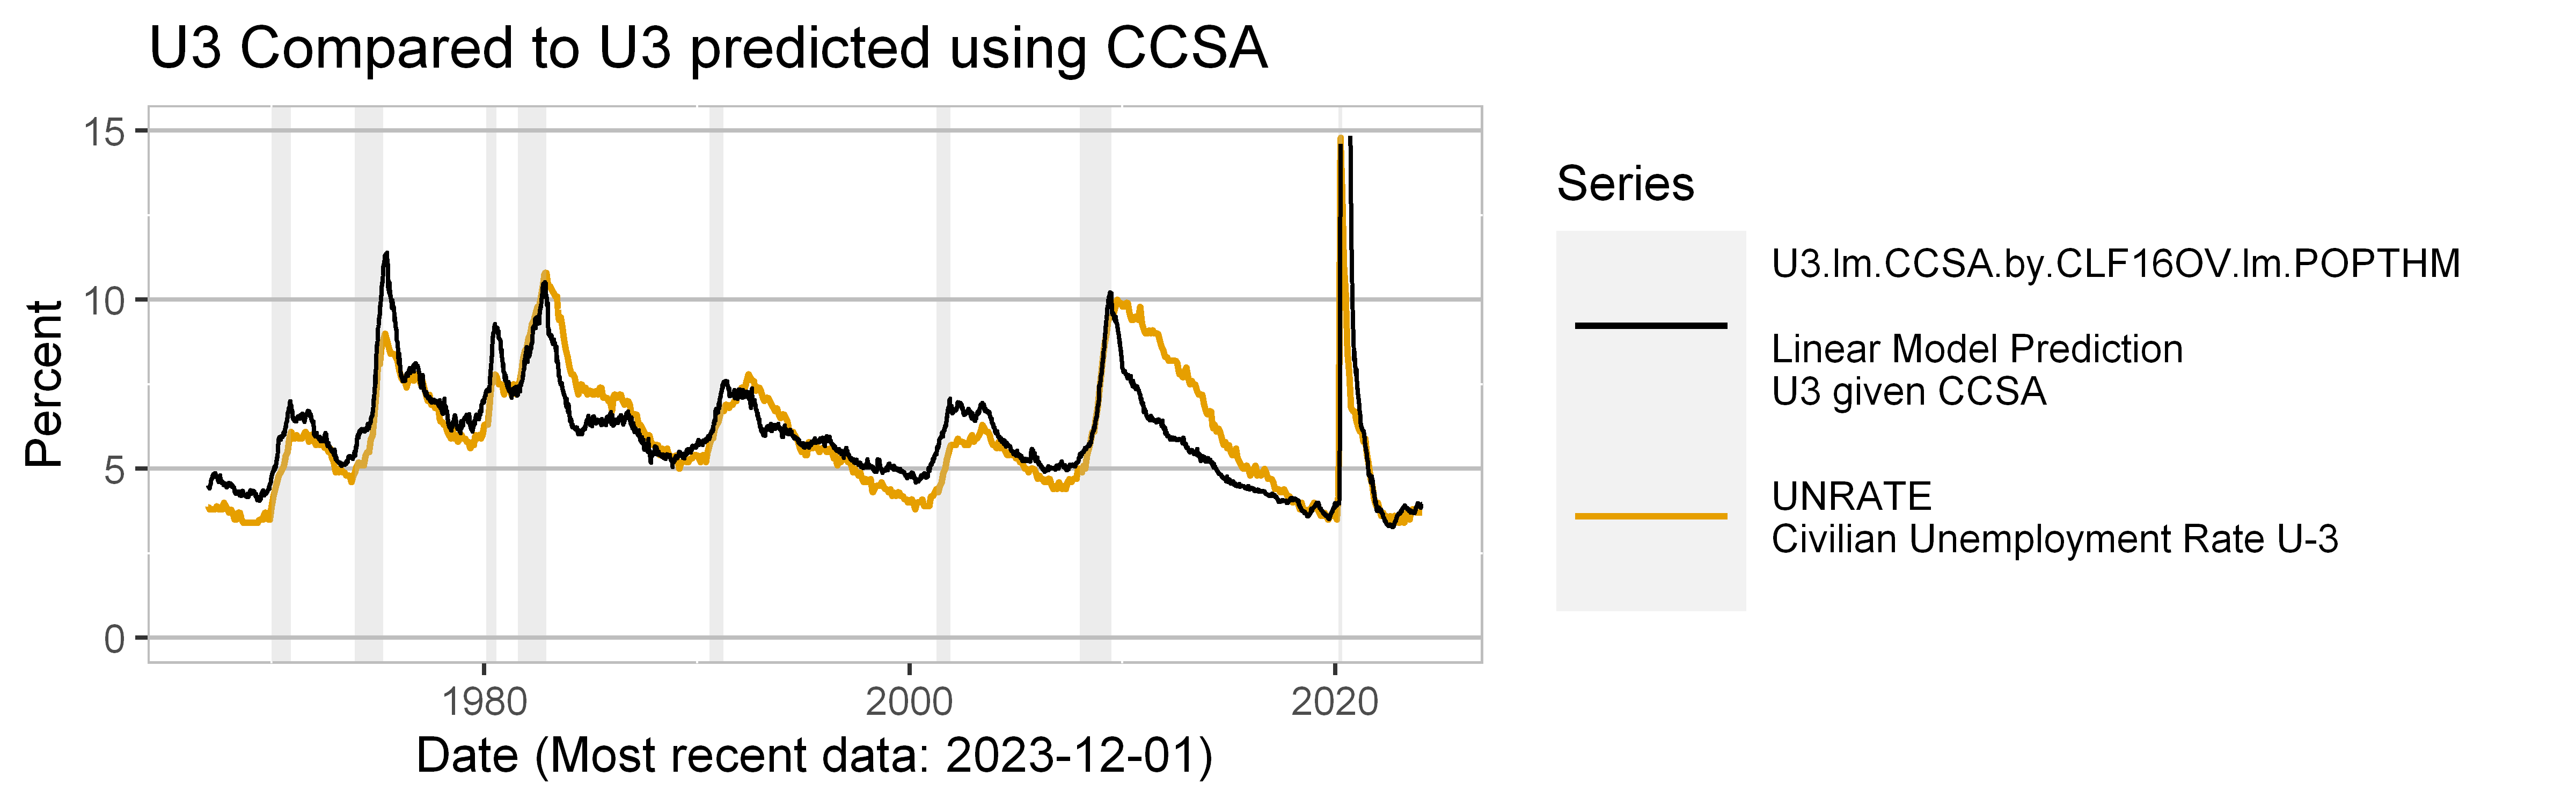

In [47]:
datay <- "UNRATE"
datay.aux <- "U3.lm.CCSA.by.CLF16OV.lm.POPTHM"
datay.aux.1 <- "U3.knn.CCSA.by.CLF16OV.lm.POPTHM"
ylim <- c(0, 15)
dt.end <- Sys.Date()
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "U3 Compared to U3 predicted using CCSA",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(index(CCSA[1]), dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )

myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

#myPlot <- myPlot + geom_line(
#  data = df.data,
#  aes_string(
#    x = "date",
#    y = datay.aux.1,
#    colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
#  ),
#  na.rm = TRUE
#)

myPlot


Zoom in a little. There is a lot of discussion about how valid the latest U3 numbers are.

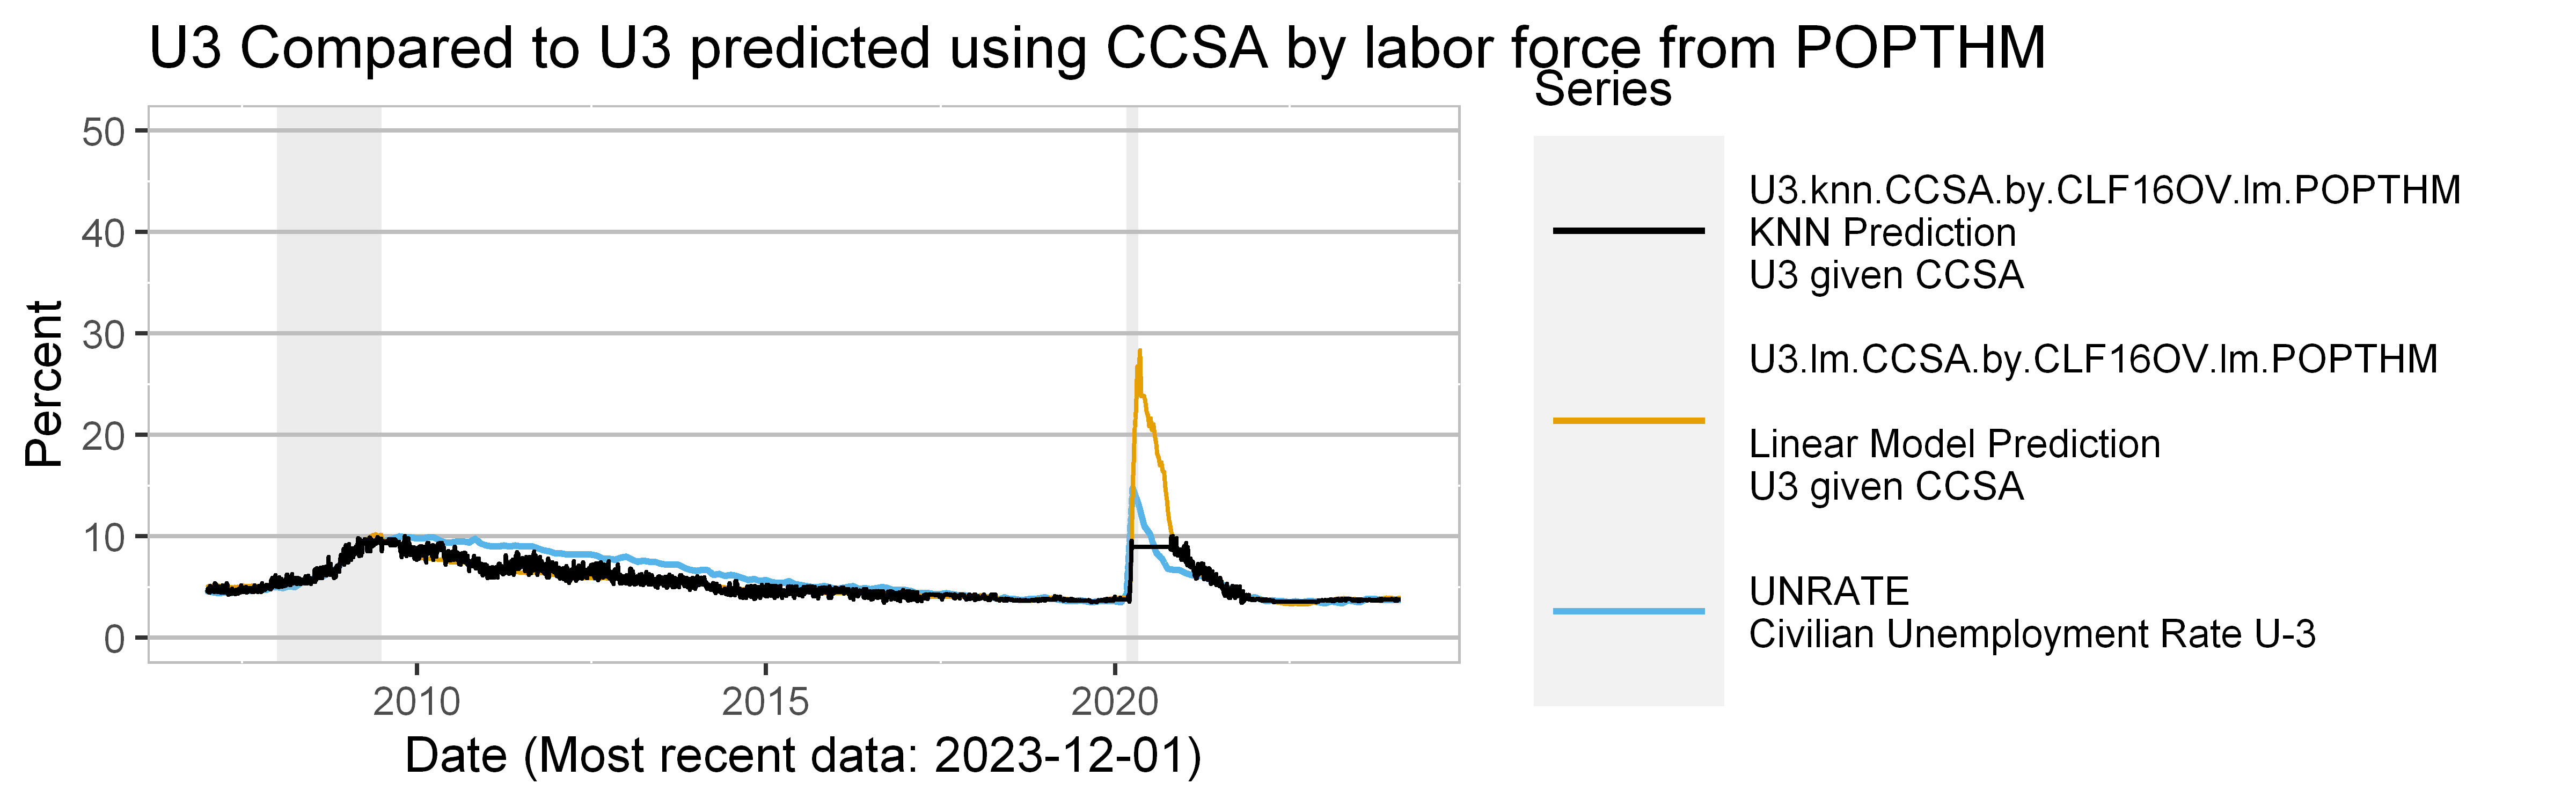

In [48]:
datay <- "UNRATE"
datay_aux <- "U3.lm.CCSA.by.CLF16OV.lm.POPTHM"
datay.aux.1 <- "U3.knn.CCSA.by.CLF16OV.lm.POPTHM"
ylim <- c(0, 50)
dt.end <- Sys.Date()
dt.start <- as.Date("2007-01-01")
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "U3 Compared to U3 predicted using CCSA by labor force from POPTHM",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay_aux,
    colour = shQuote(getPlotTitle(df.symbols, datay_aux))
  ),
  na.rm = TRUE
)

myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.1,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
  ),
  na.rm = TRUE
)

Plot the residual for the U3 linear fit. The residuals decrease quite a bit during the Covid numbers, at least as of Jun 2020. Probably indicates uncertainty in the numbers.

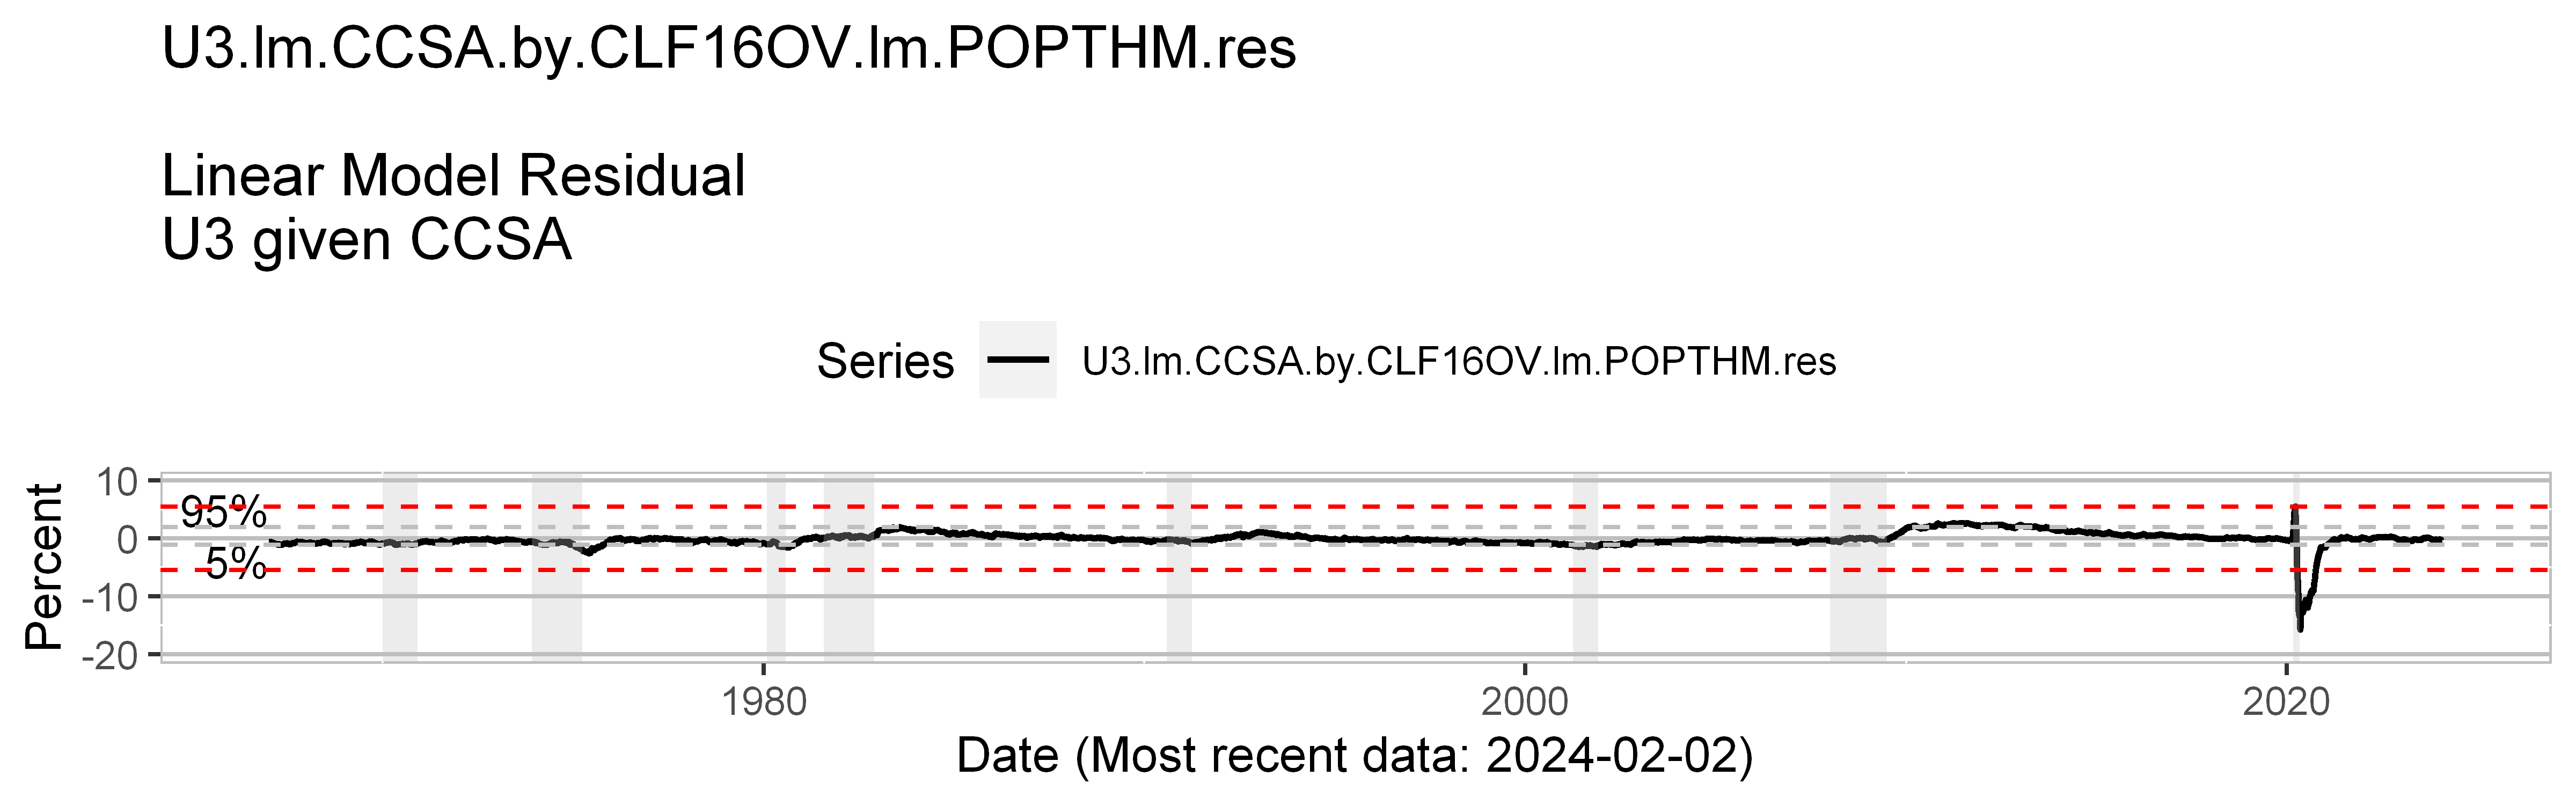

In [49]:
datay <- "U3.lm.CCSA.by.CLF16OV.lm.POPTHM.res"
ylim <- c(-20, 10)
myPlot <- plotSingle(
  dfRecession,
  df.data,
  "date",
  datay,
  getPlotTitle(df.symbols, datay),
  "Date",
  getPlotYLabel(df.symbols, datay),
  c(index(CCSA[1]), Sys.Date()),
  ylim,
  b.legend = TRUE,
  b.percentile = TRUE,
  b.long.legend = FALSE
)

myPlot <- myPlot + geom_hline(yintercept=(6*sd.fit.u3ccsa), color = "red", linetype="dashed")
myPlot <- myPlot + geom_hline(yintercept=(-6*sd.fit.u3ccsa), color = "red", linetype="dashed")

print(myPlot)

### Look at the difference between the linear prediction of U3 and the BLS numbers

In [50]:
df.data$U3Diff <- df.data$UNRATE - df.data$U3.lm.ICSA.by.CLF16OV.lm.POPTHM

In [51]:
# Add the difference prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = 'U3Diff',
      string.source = "calc",
      string.description = "U3 - U3.lm.ICSA.by.CLF16OV.lm.POPTHM",
      string.label.y = df.symbols[df.symbols$string.symbol=="UNRATE","string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


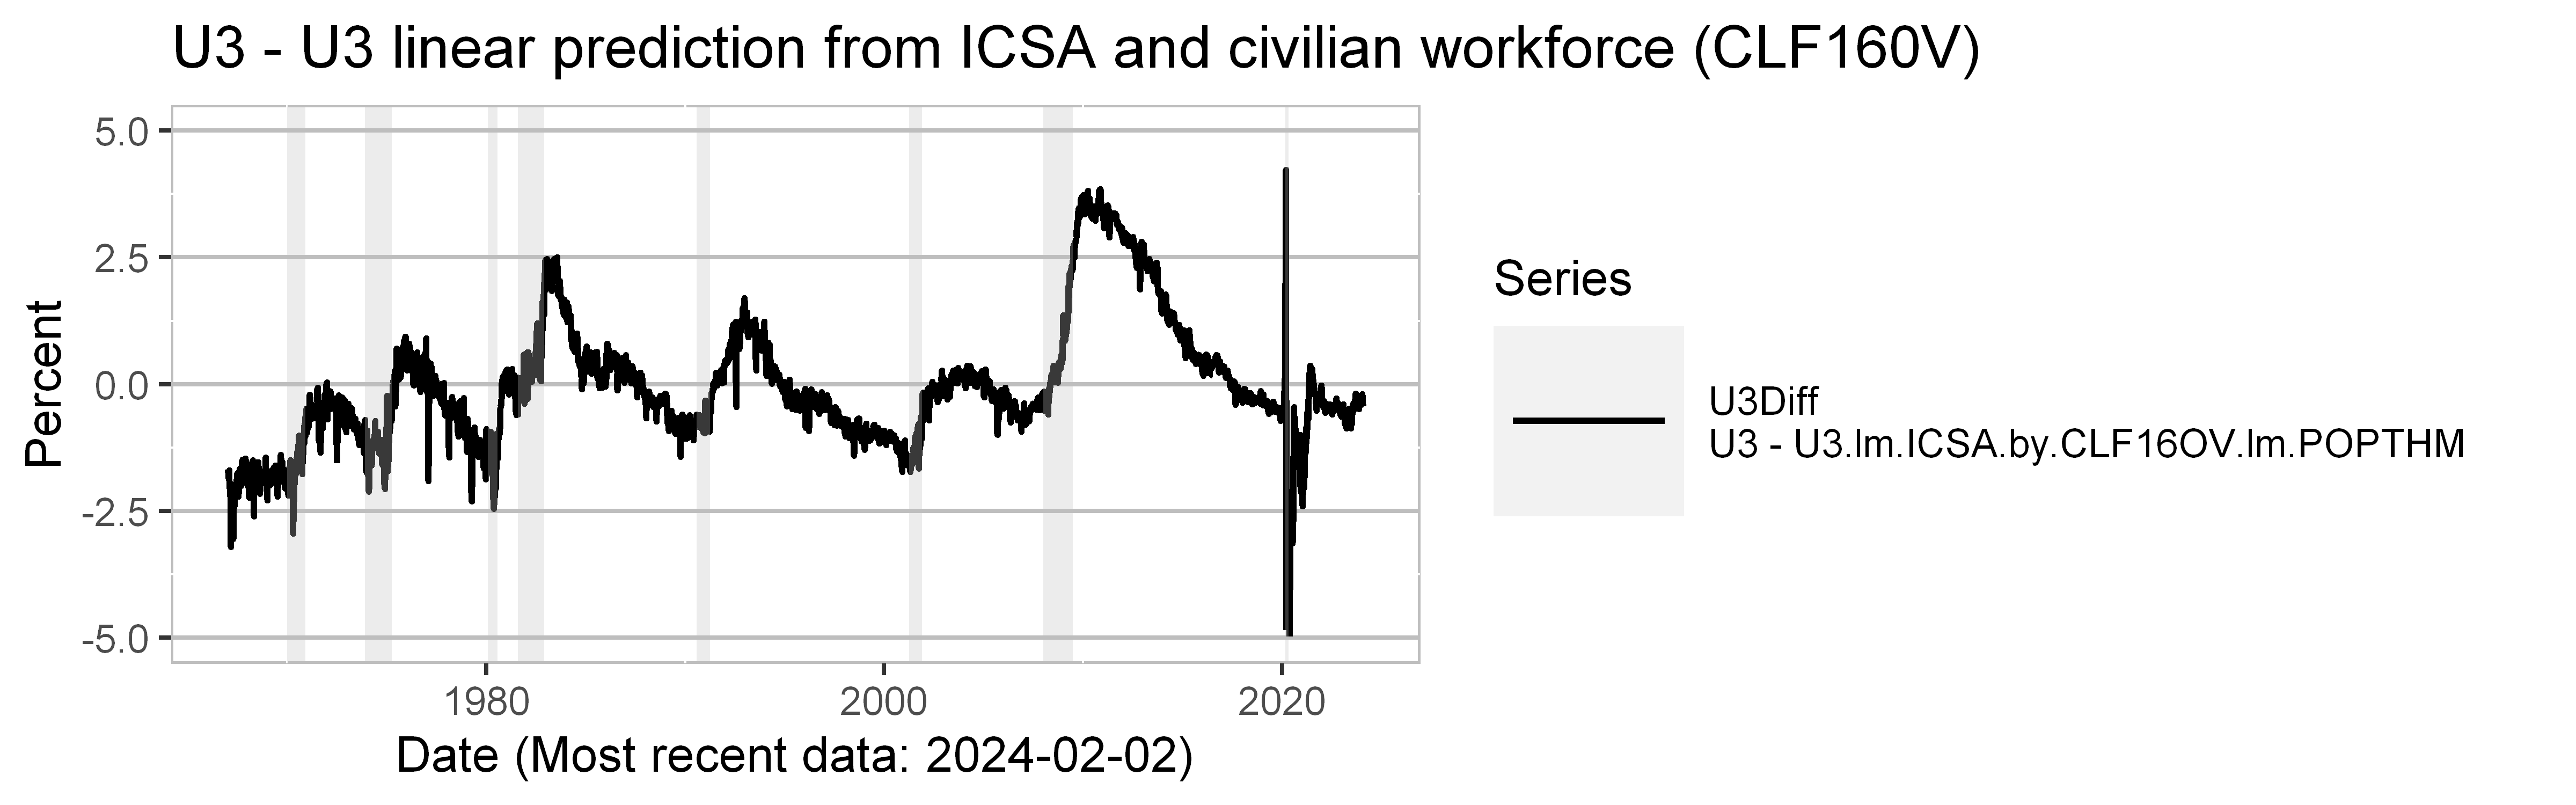

In [52]:
datay <- "U3Diff"
ylim <- c(-5, 5)
dt.end <- Sys.Date()
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "U3 - U3 linear prediction from ICSA and civilian workforce (CLF160V)",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(index(CCSA[1]), dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )

myPlot

### Employment Correlation, U3 (UNRATE) and NPPTTL (ADP) normalized 
Calculate linear model fit across the series. NPPTTL should be an accurate esimate of the actual number of people on payrolls.

In [53]:
# The U6 numbers do not have as much historical data as the U3 so valid data for fit
# begins early. I also exluded the Covid 16 mess of data.
dt.start.prediction <- as.Date("2002-04-01")
dt.end.prediction <- as.Date("2020-01-01")
df.emp.model <-
  df.data[df.data$date >= dt.start.prediction &
            df.data$date <= dt.end.prediction,]

# I break the data into three sets: 50% for training, 25% for testing, and 25% for validation.
set.seed(123456)
in.train <- createDataPartition(y=df.emp.model$ICSA, p = 0.50, list=FALSE)
df.train <- df.emp.model[in.train,]
df.data.rest <- df.emp.model[-in.train,]
in.val <- createDataPartition(y = df.data.rest$ICSA, p = 0.50, list = FALSE)
df.val <- df.data.rest[in.val,]
df.test <- df.data.rest[-in.val,]
rm(df.data.rest)

Perform the fit

In [54]:
# Perform the fit
list.fit.u3nppttl <- train(
  UNRATE ~ NPPTTL.by.CLF16OV.lm.POPTHM,
  data = df.emp.model,
  method = "lm",
  preProcess = c('center', 'scale')
)

list.fit.knn.u3nppttl <- train(
  UNRATE ~ NPPTTL.by.CLF16OV.lm.POPTHM,
  data = df.train,
  method = "knn",
  preProcess = c('center', 'scale')
)

rm(df.train)
rm(df.val)

Add the symbols

In [55]:

# Add linear model prediction to the dataframe
str.symbol <- "U3.lm.NPPTTL.by.CLF16OV.lm.POPTHM"
df.data[str.symbol] <-
  predict(list.fit.u3nppttl, newdata = df.data)

# Add the linear model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "Linear Model Prediction\nU3 given NPPTTL by POPTH",
      string.label.y = df.symbols[df.symbols$string.symbol=="UNRATE","string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Document the residual as well
str.symbol.res <- "U3.lm.NPPTTL.by.CLF16OV.lm.POPTHM.res"
df.data[str.symbol.res] <- df.data$UNRATE - df.data[str.symbol]

# Add the U3 linear model model prediction residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.res,
      string.source = "Predict Resid.",
      string.description = "Linear Model Residual\nU3 given NPPTTL by POPTHM",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Add KNN model prediction to the dataframe
str.symbol <- "U3.knn.NPPTTL.by.CLF16OV.lm.POPTHM"
df.data[str.symbol] <-
  predict(list.fit.knn.u3nppttl, newdata = df.data)

# Add the knn model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "KNN Prediction\nU3 given NPPTTL by POPTHM",
      string.label.y = df.symbols[df.symbols$string.symbol=="UNRATE","string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Document the residual as well
str.symbol.res.knn <- "U3.knn.NPPTTL.by.CLF16OV.lm.POPTHM.res"
df.data[str.symbol.res.knn] <- df.data$UNRATE - df.data[str.symbol]

# Add the U3 knn model prediction residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.res.knn,
      string.source = "Predict Resid.",
      string.description = "KNN Residual\nU3 given NPPTTL by POPTHM",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

Look at how the fits performed on the test data partition

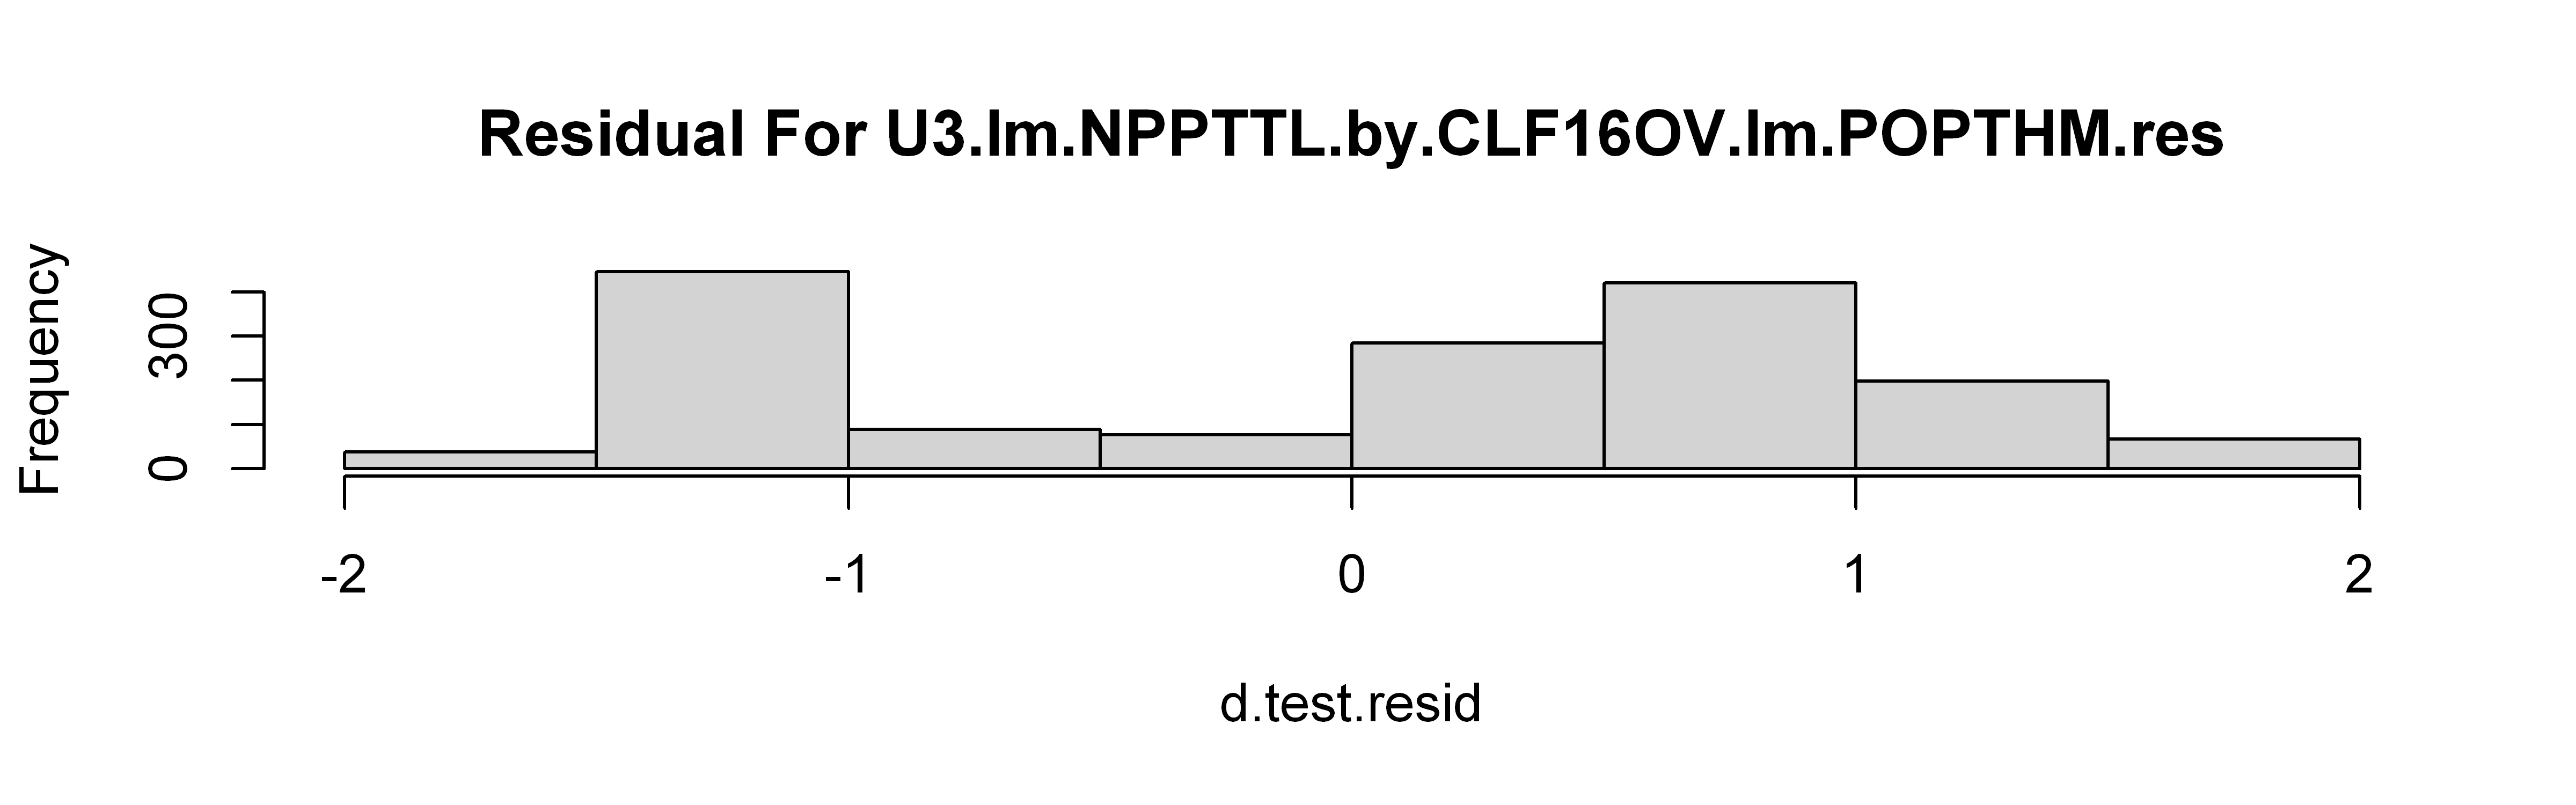

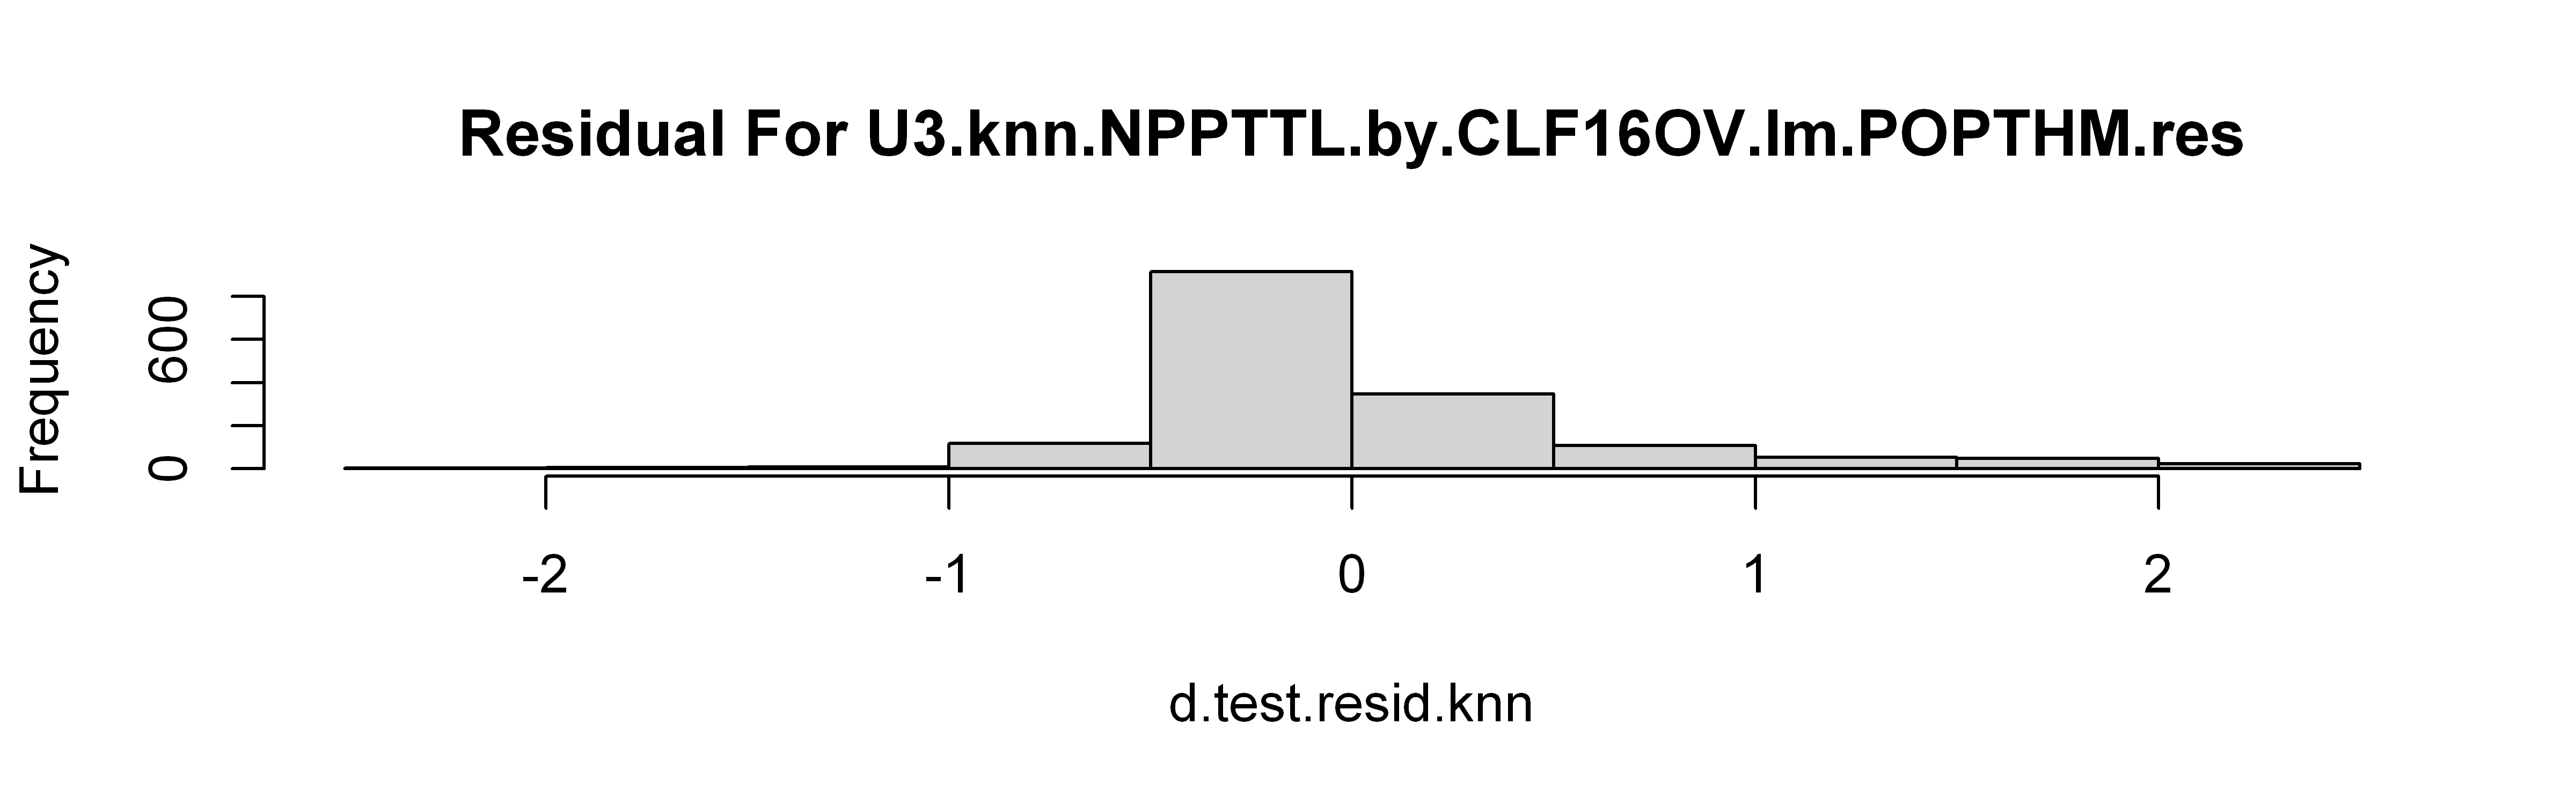

In [56]:
d.test.resid = (df.test$UNRATE - predict(list.fit.u3nppttl, newdata = df.test))
hist(d.test.resid, main=paste("Residual For", str.symbol.res, sep=" "))
sd.fit.u3nppttl = sd(d.test.resid)


d.test.resid.knn = (df.test$UNRATE - predict(list.fit.knn.u3nppttl, newdata = df.test))
hist(d.test.resid.knn, main=paste("Residual For", str.symbol.res.knn, sep=" "))
sd.fit.knn.u3nppttl = sd(d.test.resid.knn)
rm(list.fit.knn.u3nppttl)

The problem with ADP data is that it only goes back a few years so there really is not enough data. What there is does not have a linear relationship with the ADP numbers.

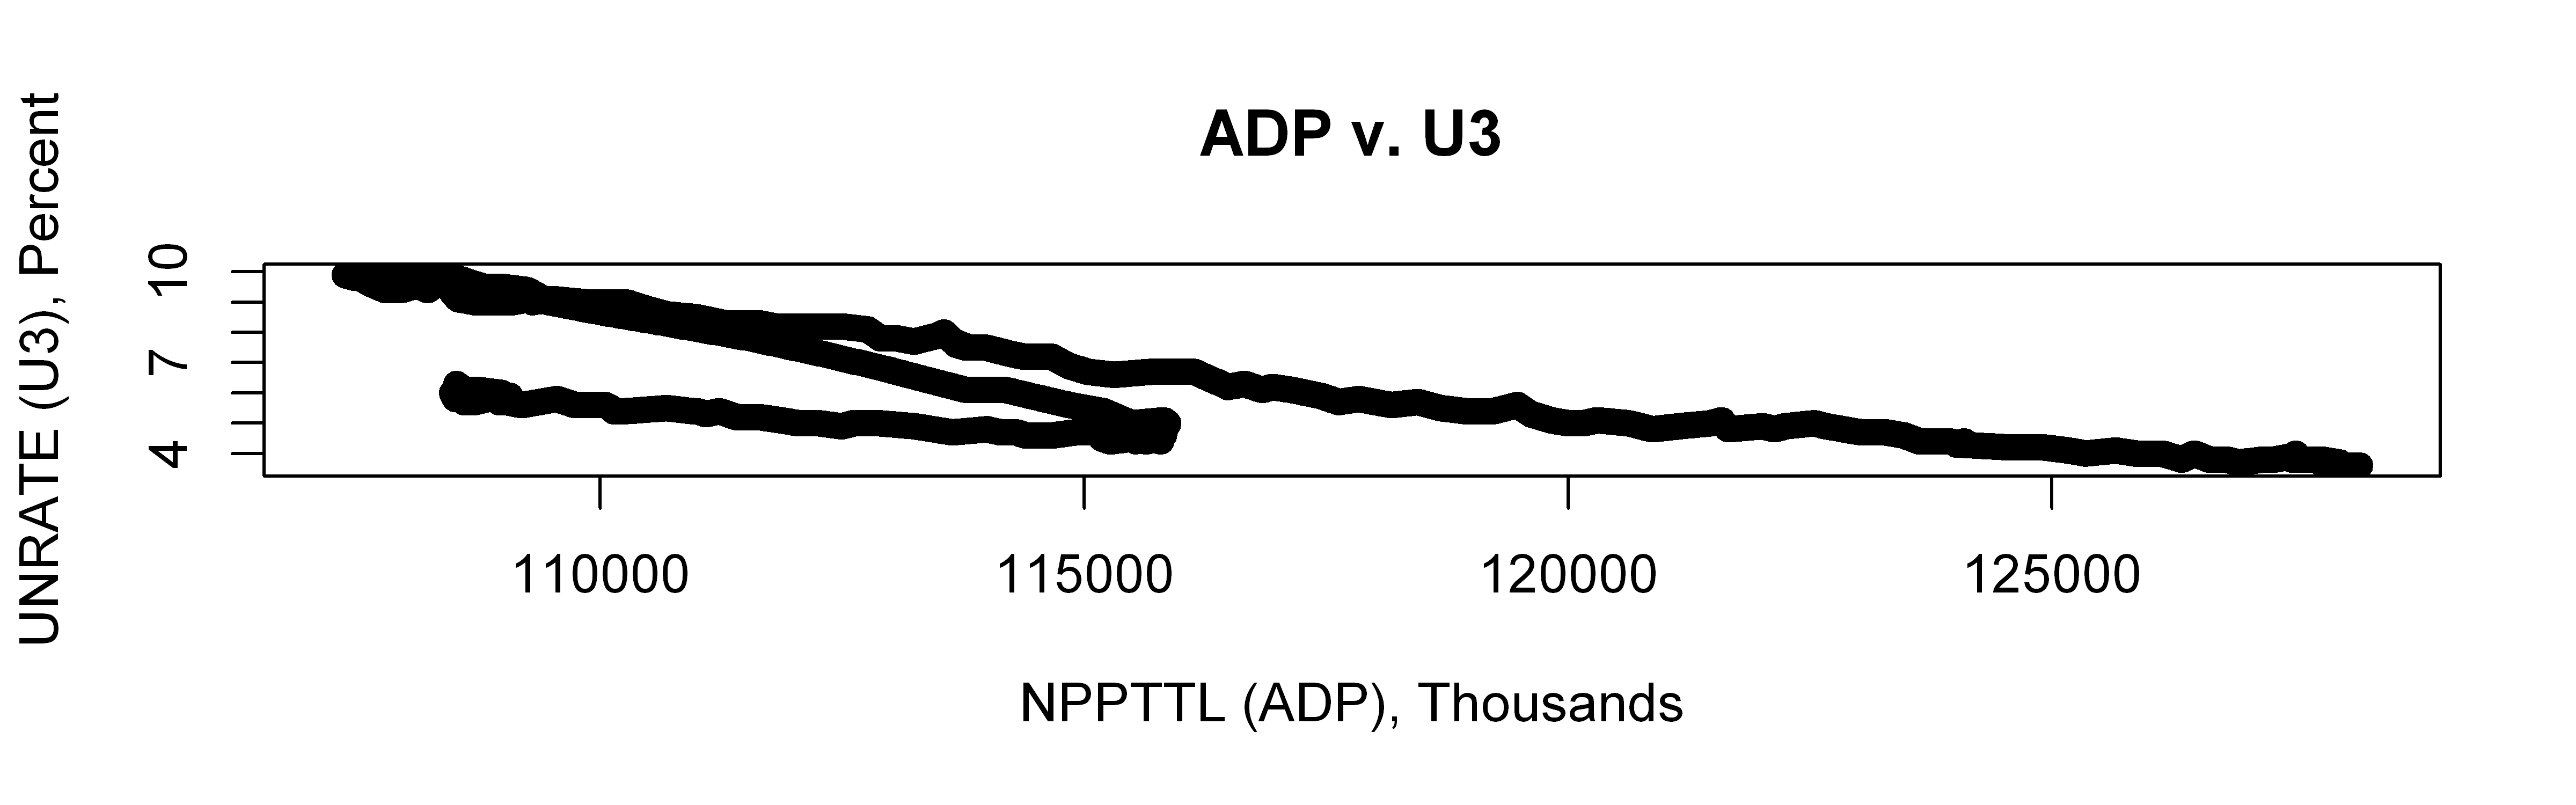

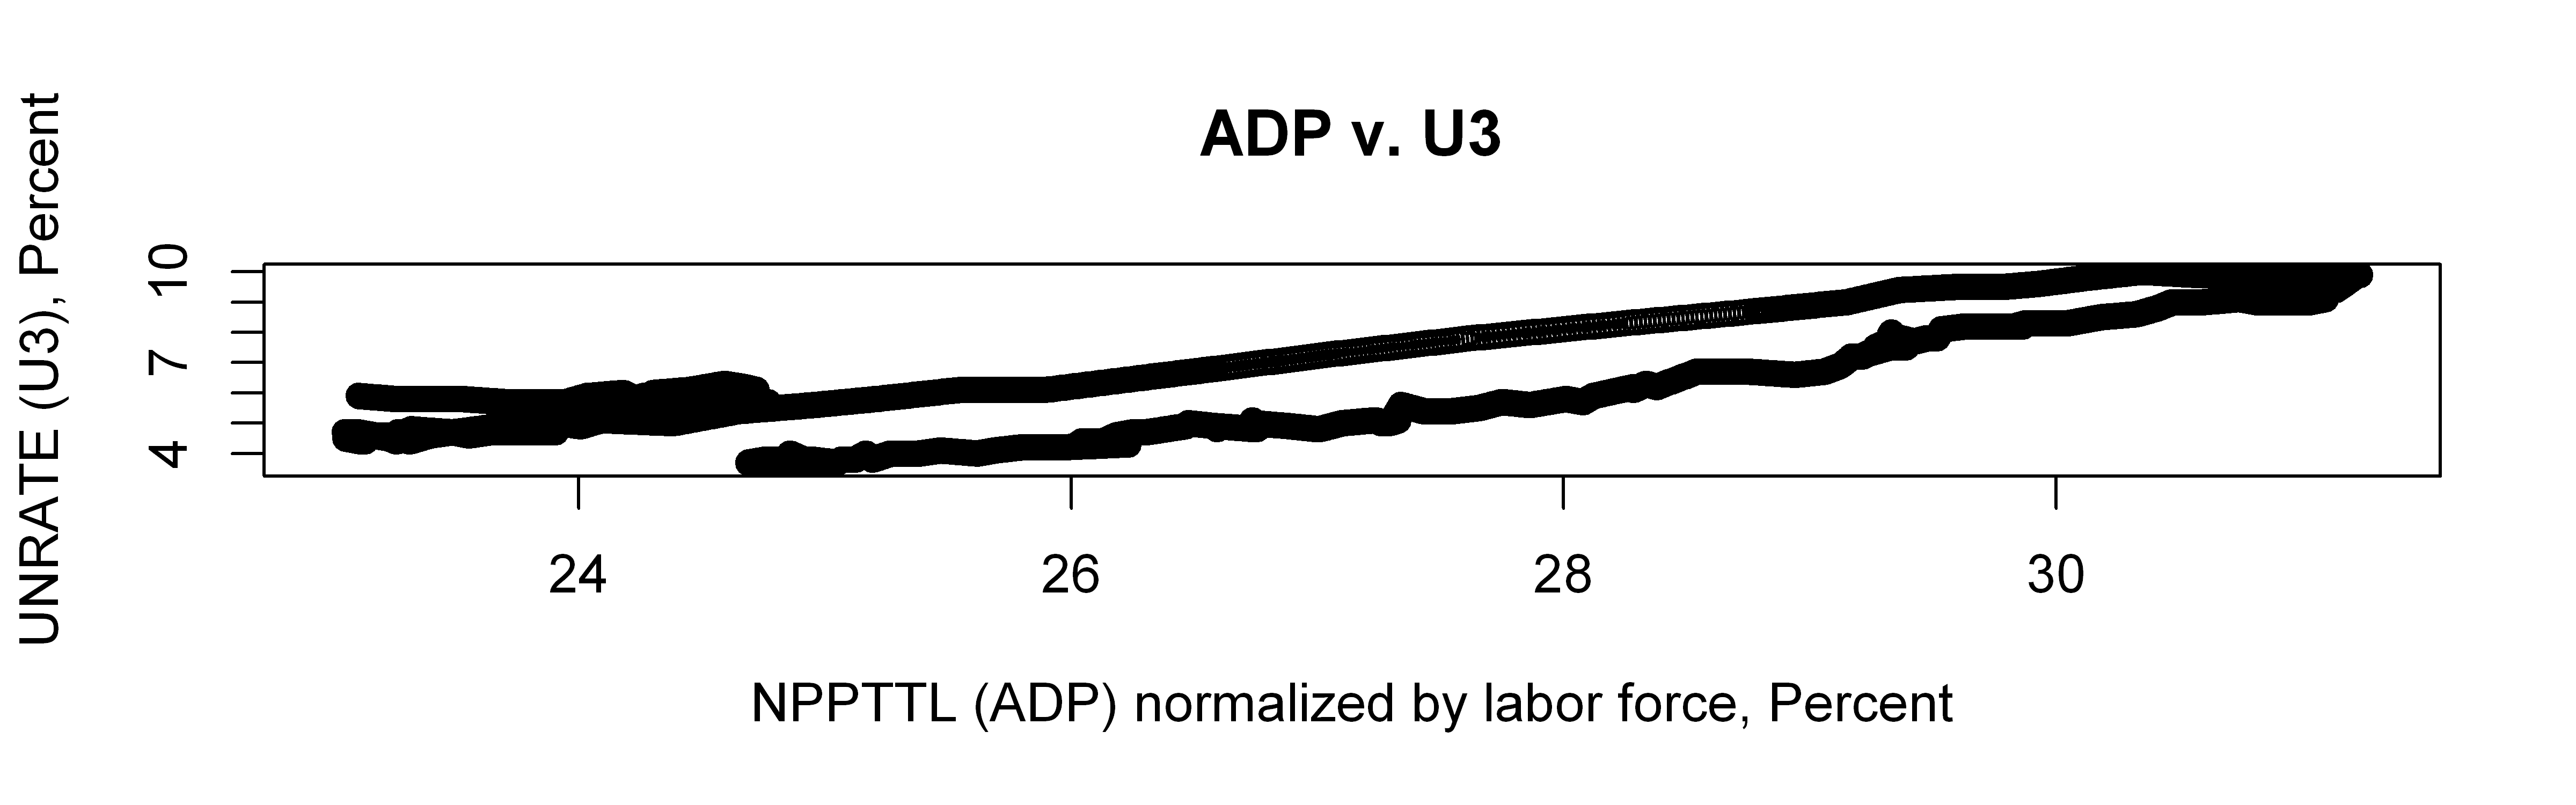

In [57]:
plot(df.emp.model$NPPTTL,
     df.emp.model$UNRATE,
     main = "ADP v. U3",
     xlab = "NPPTTL (ADP), Thousands",
     ylab = "UNRATE (U3), Percent")


plot( 100*( df.emp.model$CLF16OV.lm.POPTHM -  df.emp.model$NPPTTL ) / df.emp.model$CLF16OV.lm.POPTHM,
     df.emp.model$UNRATE,
     main = "ADP v. U3",
     xlab = "NPPTTL (ADP) normalized by labor force, Percent",
     ylab = "UNRATE (U3), Percent")

rm(df.emp.model)

Plot the measured U3 (UNRATE) to U3 predicted by a linear fit to NPPTTL normalized by labor force from POPTHM.


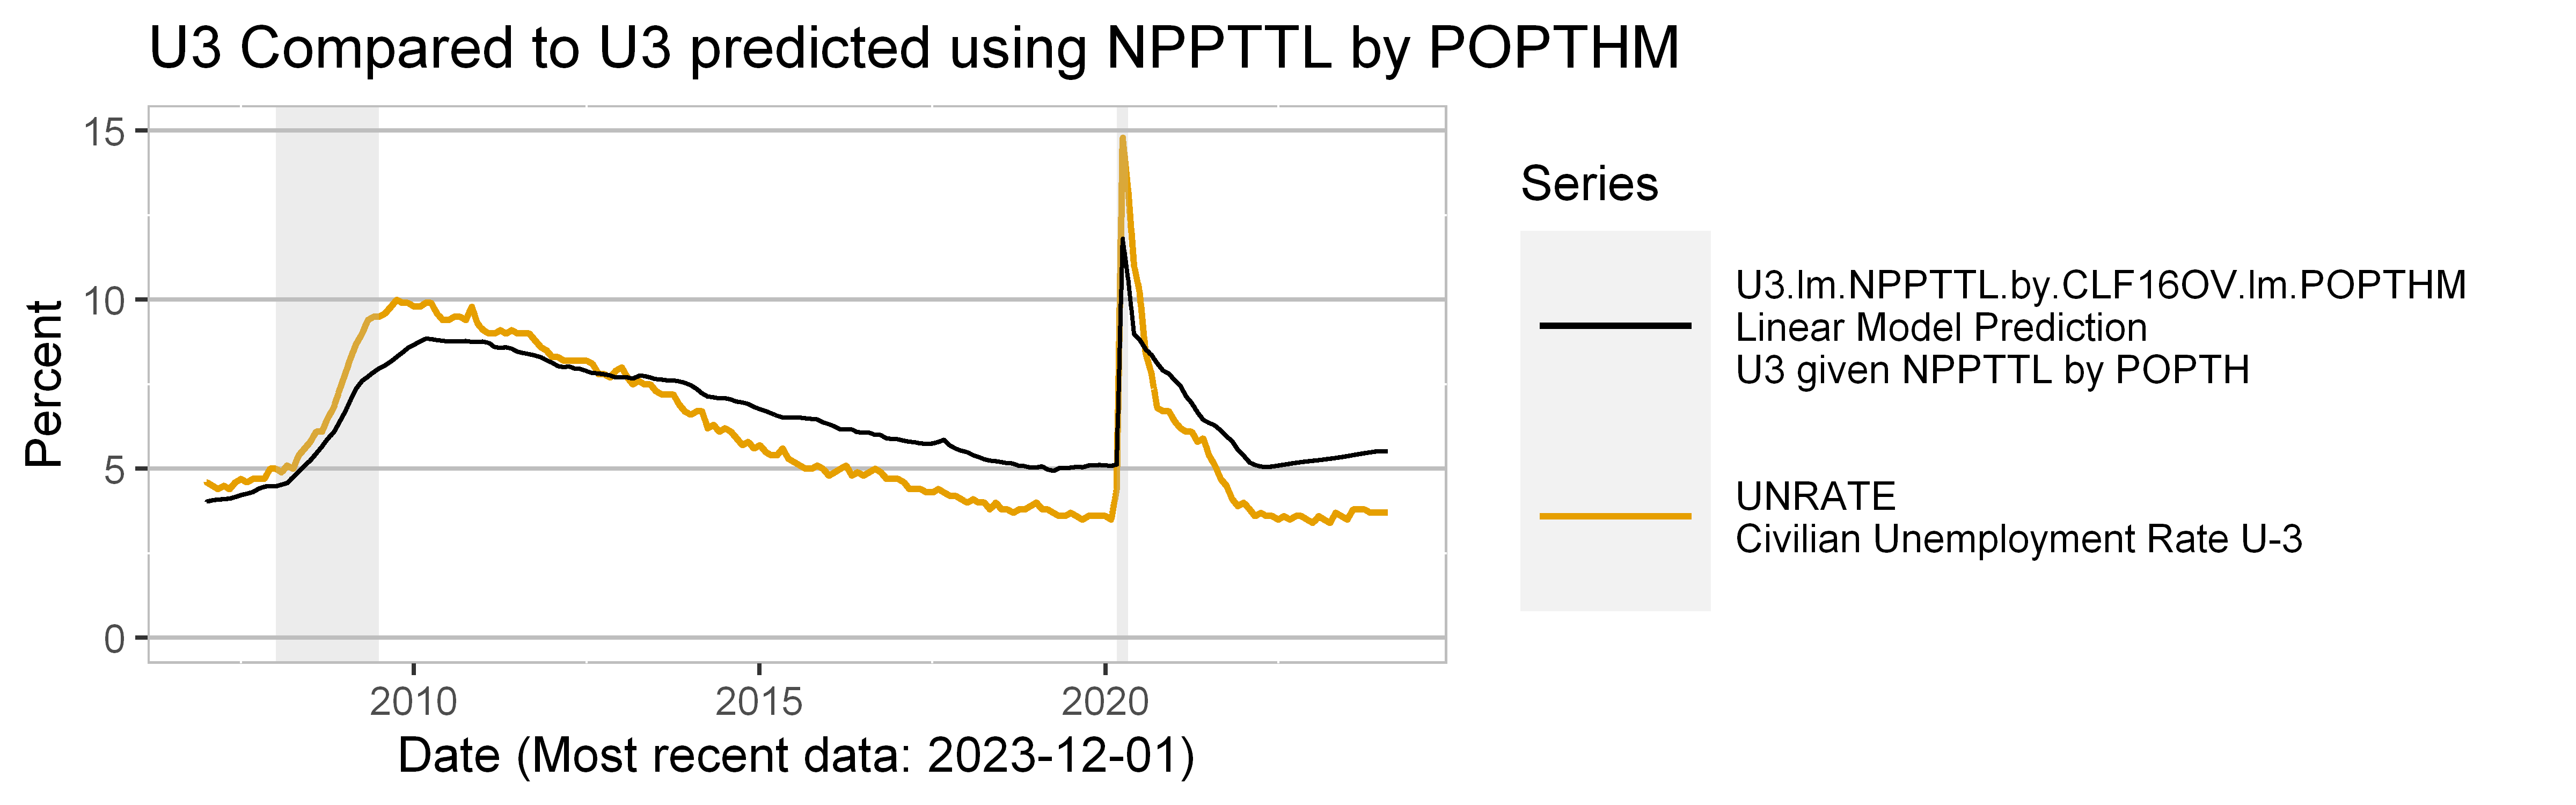

In [58]:
datay <- "UNRATE"
datay_aux <- "U3.lm.NPPTTL.by.CLF16OV.lm.POPTHM"
ylim <- c(0, 15)
dt.end <- Sys.Date()
dt.start <- as.Date("2007-01-01")
#dt.start <- dt.start.prediction

myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "U3 Compared to U3 predicted using NPPTTL by POPTHM",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay_aux,
    colour = shQuote(getPlotTitle(df.symbols, datay_aux))
  ),
  na.rm = TRUE
)


Plot the residual for the U3 linear fit. The residuals decrease quite a bit during the Covid numbers, at least as of Jun 2020. Probably indicates uncertainty in the numbers.

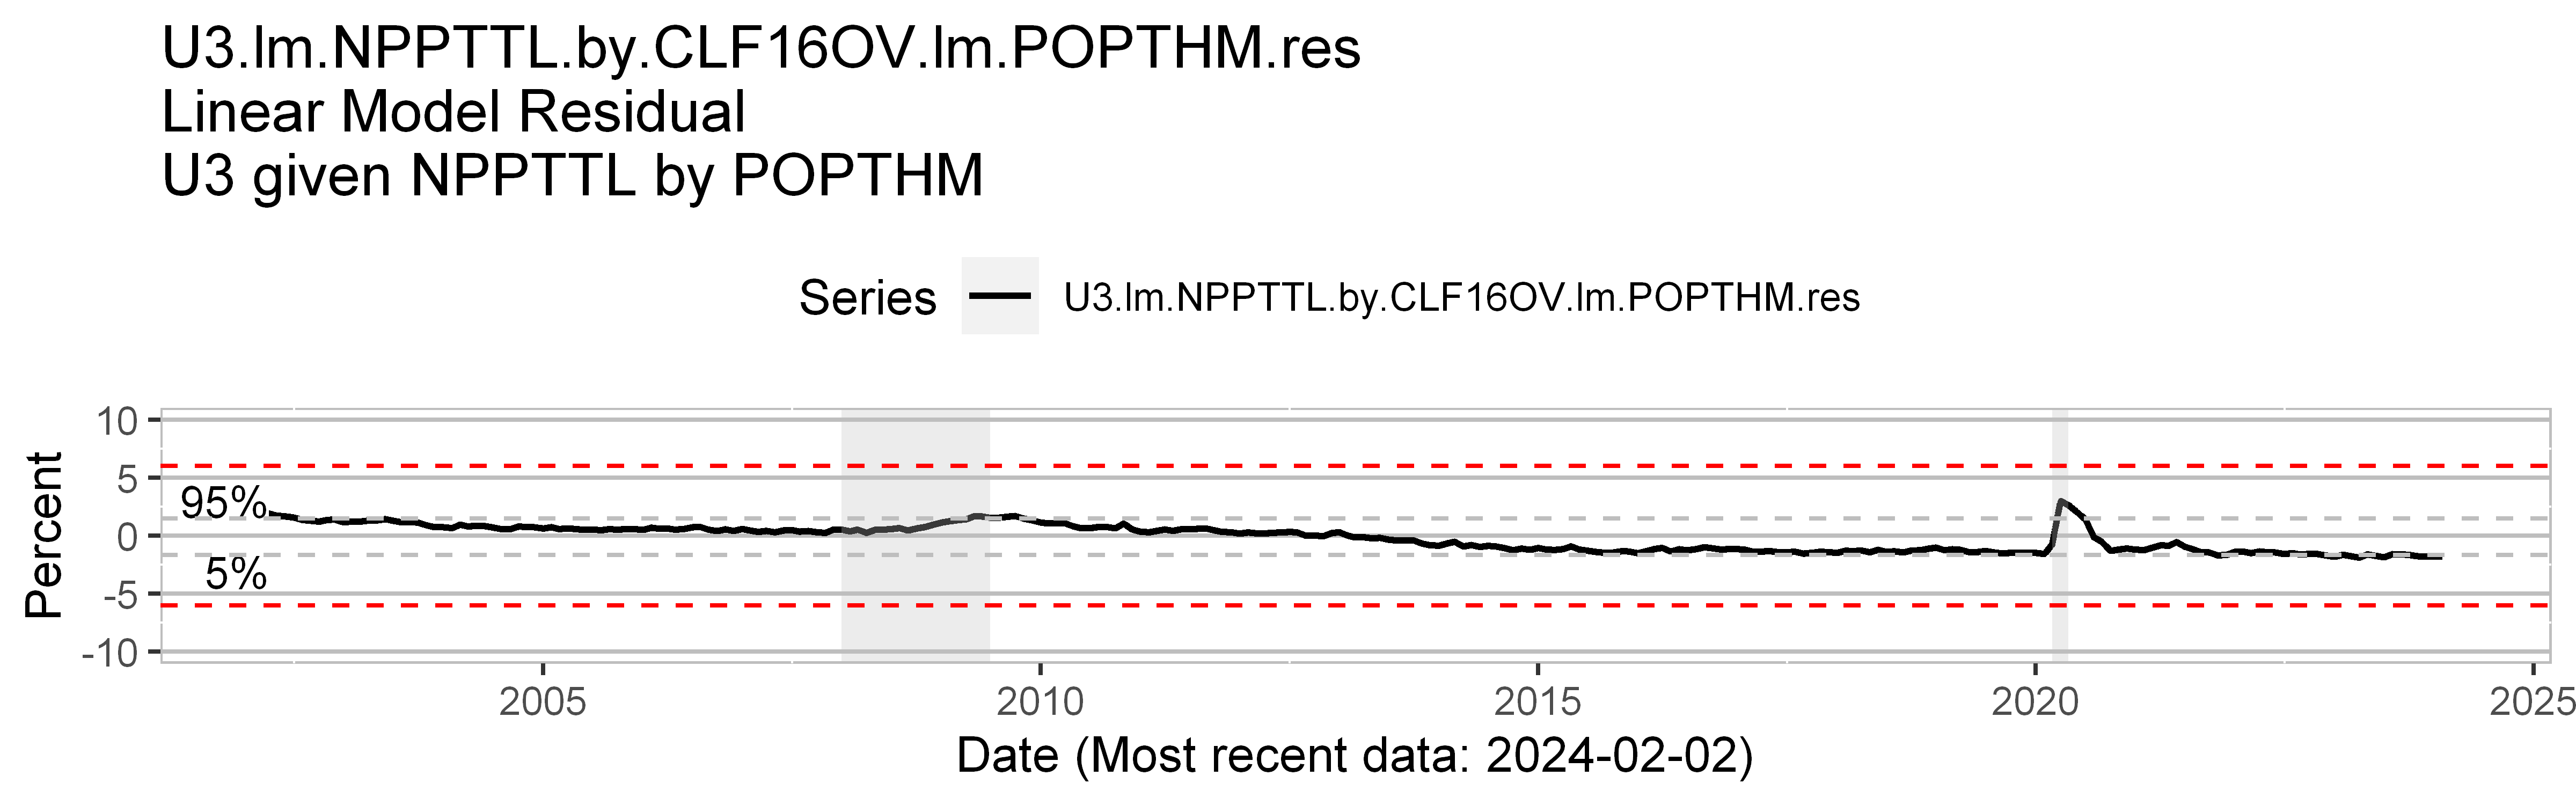

In [59]:
datay <- "U3.lm.NPPTTL.by.CLF16OV.lm.POPTHM.res"
ylim <- c(-10, 10)
myPlot <- plotSingle(
  dfRecession,
  df.data,
  "date",
  datay,
  getPlotTitle(df.symbols, datay),
  "Date",
  getPlotYLabel(df.symbols, datay),
  c(dt.start.prediction, Sys.Date()),
  ylim,
  b.legend = TRUE,
  b.percentile = TRUE,
  b.long.legend = FALSE
)

myPlot <- myPlot + geom_hline(yintercept=(6*sd.fit.u3nppttl), color = "red", linetype="dashed")
myPlot <- myPlot + geom_hline(yintercept=(-6*sd.fit.u3nppttl), color = "red", linetype="dashed")

print(myPlot)

### Correlation Summary

In [60]:
str.name <- c('U6 from U3','U3 from ICSA', 'U3 from CCSA', 'U3 from NPPTTL')
dt.list.start <- c(index(U6RATE[1]), index(ICSA[1]), index(CCSA[1]), index(NPPTTL[1]))
df.emp.cor <- data.frame("Relationship"=str.name, "Start Date"=as.Date(dt.list.start))

library(IRdisplay)

kt <- kable_styling(kable(df.emp.cor, format = "html") %>%
  kable_styling(bootstrap_options = c("striped", "hover")) %>%
  column_spec(column = 1, width = "1.5in; display: inline-block;") %>%
  column_spec(2, width = "10em"))
display_html(toString(kt))

Relationship,Start.Date
U6 from U3,1994-01-01
U3 from ICSA,1967-01-07
U3 from CCSA,1967-01-07
U3 from NPPTTL,2002-04-01
